To run this notebook, you have to download the CbCR_repository and run this notebook in a directory containing a directory "CbCR_repository"

# Imports

In [1]:
from PyPDF2 import PdfReader
import os
import random
import shutil
import pycountry
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import joblib

# Extract text from pdfs

In [2]:
def create_directory_if_not_exists(directory_path : str) -> bool:
    """Return True if a directory was created."""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
        return True
    else:
        print(f"Directory '{directory_path}' already exists.")
        return False
        
create_directory_if_not_exists("extracted_text")

Directory 'extracted_text' already exists.


False

In [3]:
def pages_containing_table(file_name : str) -> [int]:
    p = file_name.split("_")[-1].split(".")[0]
    if '-' in p:
        first_page = p.split("-")[0]
        last_page = p.split("-")[1]
        return list(range(int(first_page)-1,int(last_page)))
    return [int(p)-1]

In [4]:
files = os.listdir("CbCR_repository")

for f in tqdm(files,desc=f"Extracting text from input pdf files."):
    if 0 not in pages_containing_table(f): # we skip the pdf if the table was extracted from a full report
        if create_directory_if_not_exists("extracted_text/"+f):
            reader = PdfReader("CbCR_repository/"+f)
            for i in range(len(reader.pages)):
                with open("extracted_text/"+f+"/"+str(i)+".txt", 'w', encoding='utf-8') as out:
                    out.write(reader.pages[i].extract_text().lower())

Extracting text from input pdf files.:  75%|█████████████████████████████▏         | 309/413 [00:00<00:00, 2780.78it/s]

Directory 'extracted_text/Acciona_2021_CbCR_87.pdf' already exists.
Directory 'extracted_text/Acciona_2022_CbCR_127.pdf' already exists.
Directory 'extracted_text/ACS_2019_CbCR_3.pdf' already exists.
Directory 'extracted_text/ACS_2020_CbCR_2.pdf' already exists.
Directory 'extracted_text/ACS_2021_CbCR_2-3.pdf' already exists.
Directory 'extracted_text/Adecco_2021_CbCR_21.pdf' already exists.
Directory 'extracted_text/Adecco_2022_CbCR_23.pdf' already exists.
Directory 'extracted_text/Adyen_2020_CbCR_146.pdf' already exists.
Directory 'extracted_text/Adyen_2021_CbCR_165.pdf' already exists.
Directory 'extracted_text/Adyen_2022_CbCR_125.pdf' already exists.
Directory 'extracted_text/Aegon_2020_CbCR_13.pdf' already exists.
Directory 'extracted_text/Aegon_2021_CbCR_14.pdf' already exists.
Directory 'extracted_text/AkerSolutions_2014_CbCR_18.pdf' already exists.
Directory 'extracted_text/AkerSolutions_2015_CbCR_16.pdf' already exists.
Directory 'extracted_text/AkerSolutions_2016_CbCR_36.pdf'

Extracting text from input pdf files.: 100%|███████████████████████████████████████| 413/413 [00:00<00:00, 2897.74it/s]

Directory 'extracted_text/REPSOL_2020_CbCR_10.pdf' already exists.
Directory 'extracted_text/REPSOL_2021_CbCR_10.pdf' already exists.
Directory 'extracted_text/REPSOL_2022_CbCR_11.pdf' already exists.
Directory 'extracted_text/RIOTINTO_2018_CbCR_14.pdf' already exists.
Directory 'extracted_text/RIOTINTO_2019_CbCR_14-15.pdf' already exists.
Directory 'extracted_text/RIOTINTO_2020_CbCR_14-15.pdf' already exists.
Directory 'extracted_text/RIOTINTO_2021_CbCR_14-15.pdf' already exists.
Directory 'extracted_text/RoyalUnibrew_2021_CbCR_61.pdf' already exists.
Directory 'extracted_text/RoyalUnibrew_2022_CbCR_72.pdf' already exists.
Directory 'extracted_text/SAES_2020_CbCR_84-85.pdf' already exists.
Directory 'extracted_text/SAES_2021_CbCR_84-85.pdf' already exists.
Directory 'extracted_text/Saipem_2021_CbCR_107.pdf' already exists.
Directory 'extracted_text/SGR_2018_CbCR_62-63.pdf' already exists.
Directory 'extracted_text/SGR_2019_CbCR_62-63.pdf' already exists.
Directory 'extracted_text/SGR_

# Split into train test validate data sets

In [5]:
def split_train_test_validate_datasets():
    training_proportion = 0.8
    testing_proportion = 0.2
    validating_proportion = 0
    if create_directory_if_not_exists("training_dataset") and create_directory_if_not_exists("testing_dataset") and create_directory_if_not_exists("validating_dataset"):
        files = os.listdir("extracted_text")
        random.shuffle(files)
        cutoff1 = int(len(files)*training_proportion)
        cutoff2 = int(len(files)*testing_proportion)+cutoff1
        training_files = files[:cutoff1]
        testing_files = files[cutoff1:cutoff2]
        validating_files = files[cutoff2:]
        for f in training_files:
            shutil.copytree("extracted_text/"+f, "training_dataset/"+f)
        for f in testing_files:
            shutil.copytree("extracted_text/"+f, "testing_dataset/"+f)
        for f in validating_files:
            shutil.copytree("extracted_text/"+f, "validating_dataset/"+f)

In [6]:
split_train_test_validate_datasets()

Directory 'training_dataset' created.
Directory 'testing_dataset' created.
Directory 'validating_dataset' created.


# Extract features

## Extract number of country names in a page
### Extract all translations from pycountry

In [7]:
def extract_mo_from_po(input_mo_file_path, output_po_file_path):
    subprocess.run(['msgunfmt', input_mo_file_path, '-o', output_po_file_path])

create_directory_if_not_exists("translations_iso3166")
create_directory_if_not_exists("translations_iso3166_2")
create_directory_if_not_exists("translations_iso3166-1")
create_directory_if_not_exists("translations_iso3166-2")
    
for lang in os.listdir(pycountry.LOCALES_DIR):
    if "iso3166.mo" in os.listdir(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES"):
        if f"{lang}.po" not in os.listdir("translations_iso3166/"):
            extract_mo_from_po(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES/iso3166.mo",f"translations_iso3166/{lang}.po")
            
    if "iso3166_2.mo" in os.listdir(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES"):
        if f"{lang}.po" not in os.listdir("translations_iso3166_2/"):
            extract_mo_from_po(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES/iso3166_2.mo",f"translations_iso3166_2/{lang}.po")
    
    if "iso3166-1.mo" in os.listdir(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES"):
        if f"{lang}.po" not in os.listdir("translations_iso3166-1/"):
            extract_mo_from_po(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES/iso3166-1.mo",f"translations_iso3166-1/{lang}.po")
            
    if "iso3166-2.mo" in os.listdir(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES"):
        if f"{lang}.po" not in os.listdir("translations_iso3166-2/"):
            extract_mo_from_po(f"{pycountry.LOCALES_DIR}/{lang}/LC_MESSAGES/iso3166-2.mo",f"translations_iso3166-2/{lang}.po")

Directory 'translations_iso3166' created.
Directory 'translations_iso3166_2' created.
Directory 'translations_iso3166-1' created.
Directory 'translations_iso3166-2' created.


### Get all country names in all languages

In [8]:
def extract_all_words_from_po(file_path : str):
    with open(file_path,"r",encoding="utf-8") as f:
        result = set([l.replace("msgid ","").replace("msgstr ","").replace('"',"").replace("\n","").lower() for l in f.readlines() if "msgid" in l or "msgstr" in l])
    return result
        
def extract_all_country_names():
    result = set()
    for f in os.listdir(f"translations_iso3166"):
        result |= extract_all_words_from_po(f"translations_iso3166/{f}")
    
    """
    for f in os.listdir(f"translations_iso3166-1"):
        result |= extract_all_words_from_po(f"translations_iso3166-1/{f}")
    
    for f in os.listdir(f"translations_iso3166-2"):
        result |= extract_all_words_from_po(f"translations_iso3166-2/{f}")
    
    for f in os.listdir(f"translations_iso3166_2"):
        result |= extract_all_words_from_po(f"translations_iso3166_2/{f}")
    """
    
    return result
        
all_country_names = extract_all_country_names()
all_country_names |= set(map(lambda x:x.official_name.lower() if "official_name" in x.__dir__() else "", pycountry.countries))
all_country_names |= set(map(lambda x:x.flag, pycountry.countries))
all_country_names |= set(map(lambda x:x.name.lower(), pycountry.countries))
all_country_names = set(filter(lambda x:len(x) >= 2, all_country_names))
all_country_names |= set(["uk"])
len(all_country_names)



29627

### Number of country name in a page

In [9]:
def number_country_names(text : str) -> int:
    return sum([text.count(country) for country in all_country_names])

### Number of digits in a page

In [10]:
def number_digits(text : str) -> int:
    return sum([text.count(str(i)) for i in range(10)])

## Keywords

In [11]:
def keyword(text : str, keyword : str) -> int:
    return text.count(keyword)

## Variable of interest

In [12]:
def page_contains_table(file_name : str, page_number : int) -> bool:
    """Given the filename (not the filepath, only the filename with its extension), return the list of indices of pages with the CbC tables."""
    p = file_name.split("_")[-1].split(".")[0]
    if '-' in p:
        first_page = p.split("-")[0]
        last_page = p.split("-")[1]
        return page_number in range(int(first_page)-1,int(last_page))
    return page_number == int(p)-1

## Extract all features

In [13]:
 keywords = ["tax","countr","country by country","country-by-country","report","cbc",\
            "revenu","transparen","ethic","incom","employ","benefi","asset","contrib",\
            "profit","accrued","jurisdiction","sales","ebt","paid","stated","accu","tangible",\
            "fte", "expense", "related","headcount","capital","turnover","retained","current",\
            "plant","work","intragroup","remuneration","debt","contribution","per country"]

In [14]:
def extract_feature_of_a_page(dir_name : str, file_name : str, page_number : int) -> np.array:
    """
    The features we extract are:
        - nb_country: the number of country names in the page
        - keywords: how many times a string in the list of keywords is contained in the page, the list of keywords is as follows
        ["tax","countr","country by country","country-by-country","report","cbc",\
        "revenu","transparen","ethic","incom","employ","benefi","asset","contrib",\
        "profit","accrued","jurisdiction","sales","ebt","paid","stated","accu","tangible",\
        "fte", "expense", "related","headcount","capital","turnover","retained","current",\
        "plant","work","intragroup","remuneration","debt","contribution","per country"]
    Moreover, we also extract the same feature from the page before and after the current page.
    The last column of the array is a boolean indicating if the page contains a CbCR table.
    First column is the name of the file and the page number separated by a comma.
    """
    try:
        with open(f"{dir_name}/{file_name}/{str(page_number)}.txt",'r', encoding="utf-8") as f:
            text = f.read()
    except Exception as e:
        print(f"error reading {file_name} page {page_number} : {e}")
        text = ""  
    nb_columns_per_page = 1+len(keywords)
    new_row = np.zeros(nb_columns_per_page*3)
    for offset in range(-1,2):
        try:
            with open(f"{dir_name}/{file_name}/{str(page_number+offset)}.txt",'r', encoding="utf-8") as f:
                text = f.read()
        except FileNotFoundError as e:
            text = ""
        except Exception as e:
            print(f"error reading {file_name} page {page_number-1} : {e}")
            text = ""
        new_row[0+nb_columns_per_page*(offset+1)] = number_country_names(text)
        for i in range(len(keywords)):
            new_row[1+i+nb_columns_per_page*(offset+1)] = keyword(text,keywords[i])
    new_row = np.concatenate([np.array([file_name+","+str(page_number)]),new_row,np.array([page_contains_table(file_name,page_number)])])
    return new_row
    

## Extract features form the training data set

In [15]:
flatten = lambda l : [x for y in l for x in y]
column_names = np.array(["index"]+ flatten([["nb_country_names_page"+'{:+}'.format(offset)]+[k+"_page"+'{:+}'.format(offset) for k in keywords] for offset in range(-1,2)])+["page_contains_table"])

In [16]:
if "training_dataset.csv" not in os.listdir():
    rows = []
    for f in tqdm(os.listdir("training_dataset/"), desc="Extracting features from files"):
        for p in tqdm(range(len(os.listdir(f"training_dataset/{f}"))), desc=f"Extracting features from pages of file {f}"):
            rows += [extract_feature_of_a_page("training_dataset",f,p)]
    arr = np.vstack(rows)
    df_train = pd.DataFrame(arr[:,1:],columns=column_names[1:],index=arr[:,0])
    df_train.to_csv("training_dataset.csv")
df_train = pd.read_csv("training_dataset.csv", index_col=0)

Extracting features from files:   0%|                                                          | 0/234 [00:00<?, ?it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:   0%|                        | 0/227 [00:00<?, ?it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:   1%|▏               | 2/227 [00:00<00:11, 18.86it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:   2%|▎               | 4/227 [00:00<00:20, 10.72it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:   3%|▍               | 6/227 [00:00<00:24,  8.92it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:   4%|▌               | 8/227 [00:00<00:24,  8.81it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:   4%|▋               | 9/227 [00:00<00:26,  8.26it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:   4%|▋              | 10/227 [00:01<00:27,  8.01it/s]
Extracting features from pages of file A

Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  31%|████▋          | 70/227 [00:10<00:23,  6.62it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  31%|████▋          | 71/227 [00:10<00:24,  6.44it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  32%|████▊          | 72/227 [00:10<00:24,  6.32it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  32%|████▊          | 73/227 [00:10<00:24,  6.18it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  33%|████▉          | 74/227 [00:11<00:25,  6.12it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  33%|████▉          | 75/227 [00:11<00:23,  6.36it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  33%|█████          | 76/227 [00:11<00:22,  6.57it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  34%|█████          | 77/227 [00:11<00:21,  7.12it/s]
Extracting features from pages of file A

Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  60%|████████▍     | 137/227 [00:21<00:15,  5.66it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  61%|████████▌     | 138/227 [00:21<00:16,  5.39it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  61%|████████▌     | 139/227 [00:22<00:17,  5.10it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  62%|████████▋     | 140/227 [00:22<00:18,  4.81it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  62%|████████▋     | 141/227 [00:22<00:18,  4.72it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  63%|████████▊     | 142/227 [00:22<00:17,  4.98it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  63%|████████▊     | 143/227 [00:22<00:16,  5.19it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  63%|████████▉     | 144/227 [00:23<00:15,  5.48it/s]
Extracting features from pages of file A

Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  93%|█████████████ | 211/227 [00:33<00:03,  5.13it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  93%|█████████████ | 212/227 [00:33<00:02,  5.23it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  94%|█████████████▏| 213/227 [00:33<00:02,  5.65it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  94%|█████████████▏| 214/227 [00:33<00:02,  6.18it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  95%|█████████████▎| 216/227 [00:33<00:01,  7.63it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  96%|█████████████▍| 217/227 [00:33<00:01,  7.64it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  96%|█████████████▍| 218/227 [00:33<00:01,  7.70it/s]
Extracting features from pages of file Acciona_2022_CbCR_127.pdf:  96%|█████████████▌| 219/227 [00:34<00:01,  6.84it/s]
Extracting features from pages of file A

Extracting features from pages of file Adecco_2022_CbCR_23.pdf: 100%|██████████████████| 27/27 [00:02<00:00,  9.09it/s]
Extracting features from files:   2%|█                                                 | 5/234 [00:42<19:08,  5.01s/it]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:   0%|                          | 0/178 [00:00<?, ?it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:   2%|▎                 | 3/178 [00:00<00:09, 19.27it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:   3%|▌                 | 5/178 [00:00<00:08, 19.33it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:   4%|▋                 | 7/178 [00:00<00:12, 13.58it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:   5%|▉                 | 9/178 [00:00<00:13, 12.42it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:   6%|█                | 11/178 [00:00<00:13, 11.99it/s]
Extracting features from pages of file A

Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  54%|█████████▏       | 96/178 [00:10<00:07, 10.96it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  55%|█████████▎       | 98/178 [00:10<00:07, 10.84it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  57%|█████████       | 101/178 [00:10<00:06, 12.15it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  58%|█████████▎      | 103/178 [00:10<00:06, 11.67it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  59%|█████████▍      | 105/178 [00:11<00:05, 12.30it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  60%|█████████▌      | 107/178 [00:11<00:06, 11.72it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  61%|█████████▊      | 109/178 [00:11<00:07,  9.81it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  62%|█████████▉      | 111/178 [00:11<00:08,  7.83it/s]
Extracting features from pages of file A

Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  98%|███████████████▋| 175/178 [00:23<00:00,  4.32it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf:  99%|███████████████▊| 176/178 [00:24<00:00,  4.41it/s]
Extracting features from pages of file Adyen_2020_CbCR_146.pdf: 100%|████████████████| 178/178 [00:24<00:00,  7.32it/s]
Extracting features from files:   3%|█▎                                                | 6/234 [01:06<43:59, 11.58s/it]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:   0%|                          | 0/204 [00:00<?, ?it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:   1%|▏                 | 2/204 [00:00<00:11, 17.36it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:   2%|▎                 | 4/204 [00:00<00:12, 16.64it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:   3%|▌                 | 6/204 [00:00<00:14, 13.70it/s]
Extracting features from pages of file A

Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  44%|███████▍         | 89/204 [00:10<00:16,  6.83it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  44%|███████▌         | 90/204 [00:10<00:17,  6.67it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  45%|███████▌         | 91/204 [00:10<00:16,  6.77it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  45%|███████▋         | 92/204 [00:10<00:16,  6.63it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  46%|███████▊         | 93/204 [00:10<00:16,  6.74it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  46%|███████▊         | 94/204 [00:10<00:15,  7.04it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  47%|███████▉         | 95/204 [00:10<00:14,  7.52it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  48%|████████         | 97/204 [00:11<00:12,  8.39it/s]
Extracting features from pages of file A

Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  87%|█████████████▉  | 177/204 [00:19<00:02, 11.63it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  88%|██████████████  | 179/204 [00:19<00:02, 11.01it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  89%|██████████████▏ | 181/204 [00:20<00:02, 11.17it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  90%|██████████████▍ | 184/204 [00:20<00:01, 14.12it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  93%|██████████████▊ | 189/204 [00:20<00:00, 21.18it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  96%|███████████████▎| 195/204 [00:20<00:00, 29.09it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf:  98%|███████████████▋| 200/204 [00:20<00:00, 33.50it/s]
Extracting features from pages of file Adyen_2021_CbCR_165.pdf: 100%|████████████████| 204/204 [00:20<00:00,  9.80it/s]
Extracting features from files:   3%|█▍ 

Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  44%|███████▍         | 71/161 [00:10<00:16,  5.33it/s]
Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  45%|███████▌         | 72/161 [00:11<00:16,  5.40it/s]
Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  45%|███████▋         | 73/161 [00:11<00:15,  5.62it/s]
Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  46%|███████▊         | 74/161 [00:11<00:15,  5.62it/s]
Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  47%|███████▉         | 75/161 [00:11<00:15,  5.51it/s]
Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  47%|████████         | 76/161 [00:11<00:15,  5.57it/s]
Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  48%|████████▏        | 77/161 [00:12<00:14,  5.67it/s]
Extracting features from pages of file Adyen_2022_CbCR_125.pdf:  48%|████████▏        | 78/161 [00:12<00:13,  5.95it/s]
Extracting features from pages of file A

Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  33%|██████▋             | 6/18 [00:00<00:01,  7.62it/s]
Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  39%|███████▊            | 7/18 [00:00<00:01,  7.27it/s]
Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  44%|████████▉           | 8/18 [00:01<00:01,  7.01it/s]
Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  50%|██████████          | 9/18 [00:01<00:01,  6.82it/s]
Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  56%|██████████▌        | 10/18 [00:01<00:01,  7.11it/s]
Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  61%|███████████▌       | 11/18 [00:01<00:00,  7.25it/s]
Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  67%|████████████▋      | 12/18 [00:01<00:00,  6.97it/s]
Extracting features from pages of file Aegon_2020_CbCR_13.pdf:  72%|█████████████▋     | 13/18 [00:01<00:00,  6.58it/s]
Extracting features from pages of file A

Extracting features from files:   5%|██▎                                              | 11/234 [02:00<31:22,  8.44s/it]
Extracting features from pages of file AkerSolutions_2018_CbCR_38.pdf:   0%|                    | 0/51 [00:00<?, ?it/s]
Extracting features from pages of file AkerSolutions_2018_CbCR_38.pdf:   6%|▋           | 3/51 [00:00<00:02, 18.77it/s]
Extracting features from pages of file AkerSolutions_2018_CbCR_38.pdf:  10%|█▏          | 5/51 [00:00<00:03, 12.46it/s]
Extracting features from pages of file AkerSolutions_2018_CbCR_38.pdf:  14%|█▋          | 7/51 [00:00<00:03, 11.15it/s]
Extracting features from pages of file AkerSolutions_2018_CbCR_38.pdf:  18%|██          | 9/51 [00:00<00:04, 10.42it/s]
Extracting features from pages of file AkerSolutions_2018_CbCR_38.pdf:  22%|██▎        | 11/51 [00:01<00:04,  9.19it/s]
Extracting features from pages of file AkerSolutions_2018_CbCR_38.pdf:  25%|██▊        | 13/51 [00:01<00:03, 10.40it/s]
Extracting features from pages of file A

Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  54%|█████▉     | 44/82 [00:04<00:04,  8.64it/s]
Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  55%|██████     | 45/82 [00:05<00:04,  8.10it/s]
Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  56%|██████▏    | 46/82 [00:05<00:04,  8.06it/s]
Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  59%|██████▍    | 48/82 [00:05<00:03, 10.03it/s]
Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  60%|██████▌    | 49/82 [00:05<00:03,  9.79it/s]
Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  61%|██████▋    | 50/82 [00:05<00:03,  9.24it/s]
Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  62%|██████▊    | 51/82 [00:05<00:03,  8.18it/s]
Extracting features from pages of file AkerSolutions_2019_CbCR_76.pdf:  63%|██████▉    | 52/82 [00:05<00:03,  8.12it/s]
Extracting features from pages of file A

Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  71%|███████▊   | 55/78 [00:07<00:02,  7.82it/s]
Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  72%|███████▉   | 56/78 [00:07<00:02,  7.92it/s]
Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  73%|████████   | 57/78 [00:07<00:02,  7.44it/s]
Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  74%|████████▏  | 58/78 [00:07<00:02,  7.32it/s]
Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  76%|████████▎  | 59/78 [00:07<00:02,  7.24it/s]
Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  77%|████████▍  | 60/78 [00:07<00:02,  7.67it/s]
Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  78%|████████▌  | 61/78 [00:07<00:02,  8.02it/s]
Extracting features from pages of file AkerSolutions_2020_CbCR_77.pdf:  81%|████████▉  | 63/78 [00:08<00:01,  8.70it/s]
Extracting features from pages of file A

Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf:  85%|█████████▎ | 57/67 [00:09<00:02,  4.23it/s]
Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf:  87%|█████████▌ | 58/67 [00:09<00:01,  4.81it/s]
Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf:  88%|█████████▋ | 59/67 [00:09<00:01,  5.51it/s]
Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf:  91%|██████████ | 61/67 [00:09<00:00,  7.49it/s]
Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf:  94%|██████████▎| 63/67 [00:09<00:00,  8.52it/s]
Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf:  96%|██████████▌| 64/67 [00:09<00:00,  7.99it/s]
Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf:  97%|██████████▋| 65/67 [00:10<00:00,  7.43it/s]
Extracting features from pages of file AkerSolutions_2022_CbCR_66.pdf: 100%|███████████| 67/67 [00:10<00:00,  6.52it/s]
Extracting features from files:   6%|███

Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  58%|████████▏     | 14/24 [00:02<00:01,  6.58it/s]
Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  62%|████████▊     | 15/24 [00:02<00:01,  6.51it/s]
Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  67%|█████████▎    | 16/24 [00:02<00:01,  6.99it/s]
Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  71%|█████████▉    | 17/24 [00:02<00:00,  7.68it/s]
Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  75%|██████████▌   | 18/24 [00:02<00:00,  8.01it/s]
Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  79%|███████████   | 19/24 [00:03<00:00,  7.43it/s]
Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  83%|███████████▋  | 20/24 [00:03<00:00,  6.62it/s]
Extracting features from pages of file Allianz_2022_CbCR_15-16.pdf:  88%|████████████▎ | 21/24 [00:03<00:00,  5.62it/s]
Extracting features from pages of file A

Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  50%|███   | 80/160 [00:08<00:10,  7.61it/s]
Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  51%|███   | 81/160 [00:09<00:12,  6.55it/s]
Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  51%|███   | 82/160 [00:09<00:12,  6.06it/s]
Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  52%|███   | 83/160 [00:09<00:13,  5.67it/s]
Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  52%|███▏  | 84/160 [00:09<00:13,  5.60it/s]
Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  53%|███▏  | 85/160 [00:09<00:13,  5.51it/s]
Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  54%|███▏  | 86/160 [00:09<00:13,  5.40it/s]
Extracting features from pages of file AmericaMovil_2021_CbCR_147-148.pdf:  54%|███▎  | 87/160 [00:10<00:14,  5.13it/s]
Extracting features from pages of file A

Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  47%|█████▏     | 55/118 [00:05<00:08,  7.51it/s]
Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  47%|█████▏     | 56/118 [00:05<00:09,  6.72it/s]
Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  48%|█████▎     | 57/118 [00:06<00:10,  6.07it/s]
Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  49%|█████▍     | 58/118 [00:06<00:10,  5.67it/s]
Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  50%|█████▌     | 59/118 [00:06<00:11,  5.29it/s]
Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  51%|█████▌     | 60/118 [00:06<00:11,  5.13it/s]
Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  52%|█████▋     | 61/118 [00:07<00:11,  5.06it/s]
Extracting features from pages of file Amorepacific_2021_CbCR_57.pdf:  53%|█████▊     | 62/118 [00:07<00:11,  4.93it/s]
Extracting features from pages of file A

Extracting features from pages of file AngloAmerican_2018_CbCR_4-5.pdf:  69%|██████▉   | 20/29 [00:01<00:00, 13.45it/s]
Extracting features from pages of file AngloAmerican_2018_CbCR_4-5.pdf:  76%|███████▌  | 22/29 [00:01<00:00, 13.65it/s]
Extracting features from pages of file AngloAmerican_2018_CbCR_4-5.pdf:  83%|████████▎ | 24/29 [00:02<00:00, 14.30it/s]
Extracting features from pages of file AngloAmerican_2018_CbCR_4-5.pdf:  90%|████████▉ | 26/29 [00:02<00:00, 14.73it/s]
Extracting features from pages of file AngloAmerican_2018_CbCR_4-5.pdf: 100%|██████████| 29/29 [00:02<00:00, 11.95it/s]
Extracting features from files:  10%|████▊                                            | 23/234 [03:18<26:24,  7.51s/it]
Extracting features from pages of file AngloAmerican_2019_CbCR_4-5.pdf:   0%|                   | 0/24 [00:00<?, ?it/s]
Extracting features from pages of file AngloAmerican_2019_CbCR_4-5.pdf:   8%|▉          | 2/24 [00:00<00:02,  9.75it/s]
Extracting features from pages of file A

Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:   9%|█▍              | 15/168 [00:01<00:14, 10.47it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  10%|█▌              | 17/168 [00:01<00:14, 10.39it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  11%|█▊              | 19/168 [00:01<00:14, 10.46it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  12%|██              | 21/168 [00:02<00:13, 11.08it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  14%|██▏             | 23/168 [00:02<00:11, 12.22it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  15%|██▍             | 25/168 [00:02<00:12, 11.04it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  16%|██▌             | 27/168 [00:02<00:14,  9.42it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  17%|██▊             | 29/168 [00:03<00:16,  8.40it/s]
Extracting features from pages of file A

Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  57%|█████████       | 95/168 [00:12<00:11,  6.23it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  57%|█████████▏      | 96/168 [00:12<00:11,  6.47it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  58%|█████████▎      | 98/168 [00:12<00:08,  8.30it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  60%|█████████      | 101/168 [00:12<00:05, 11.28it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  61%|█████████▏     | 103/168 [00:12<00:05, 11.65it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  62%|█████████▍     | 105/168 [00:12<00:05, 12.19it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  64%|█████████▌     | 107/168 [00:13<00:05, 11.74it/s]
Extracting features from pages of file ASTM_2020_CbCR_66-67.pdf:  65%|█████████▋     | 109/168 [00:13<00:05, 11.17it/s]
Extracting features from pages of file A

Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  12%|█▎        | 52/416 [00:04<00:45,  7.91it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  13%|█▎        | 53/416 [00:04<00:44,  8.08it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  13%|█▎        | 54/416 [00:04<00:44,  8.17it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  13%|█▎        | 56/416 [00:04<00:40,  8.96it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  14%|█▎        | 57/416 [00:04<00:39,  8.99it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  14%|█▍        | 58/416 [00:05<00:41,  8.73it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  14%|█▍        | 59/416 [00:05<00:40,  8.82it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  15%|█▍        | 61/416 [00:05<00:37,  9.49it/s]
Extracting features from pages of file A

Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  35%|███      | 144/416 [00:15<00:37,  7.17it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  35%|███▏     | 145/416 [00:16<00:37,  7.23it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  35%|███▏     | 146/416 [00:16<00:39,  6.91it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  35%|███▏     | 147/416 [00:16<00:39,  6.87it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  36%|███▏     | 148/416 [00:16<00:36,  7.29it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  36%|███▏     | 149/416 [00:16<00:37,  7.10it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  36%|███▏     | 150/416 [00:16<00:40,  6.64it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  36%|███▎     | 151/416 [00:16<00:42,  6.18it/s]
Extracting features from pages of file A

Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  57%|█████    | 236/416 [00:26<00:23,  7.80it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  57%|█████▏   | 237/416 [00:26<00:27,  6.51it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  57%|█████▏   | 238/416 [00:26<00:28,  6.26it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  57%|█████▏   | 239/416 [00:27<00:30,  5.79it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  58%|█████▏   | 240/416 [00:27<00:35,  4.91it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  58%|█████▏   | 241/416 [00:27<00:36,  4.79it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  58%|█████▏   | 242/416 [00:27<00:36,  4.81it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  58%|█████▎   | 243/416 [00:27<00:36,  4.72it/s]
Extracting features from pages of file A

Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  73%|██████▌  | 302/416 [00:37<00:16,  6.83it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  73%|██████▌  | 303/416 [00:37<00:17,  6.57it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  73%|██████▌  | 304/416 [00:37<00:16,  6.68it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  73%|██████▌  | 305/416 [00:37<00:15,  7.07it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  74%|██████▌  | 306/416 [00:38<00:14,  7.60it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  74%|██████▋  | 307/416 [00:38<00:14,  7.78it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  74%|██████▋  | 308/416 [00:38<00:14,  7.59it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  74%|██████▋  | 309/416 [00:38<00:14,  7.27it/s]
Extracting features from pages of file A

Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  88%|███████▉ | 368/416 [00:48<00:06,  7.94it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  89%|███████▉ | 369/416 [00:48<00:06,  7.12it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  89%|████████ | 370/416 [00:48<00:07,  6.30it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  89%|████████ | 371/416 [00:48<00:07,  5.94it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  89%|████████ | 372/416 [00:49<00:07,  5.88it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  90%|████████ | 373/416 [00:49<00:07,  6.00it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  90%|████████ | 374/416 [00:49<00:07,  5.93it/s]
Extracting features from pages of file Atlantia_2021_CbCR_152-153.pdf:  90%|████████ | 375/416 [00:49<00:06,  6.05it/s]
Extracting features from pages of file A

Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  23%|▋  | 21/90 [00:03<00:12,  5.60it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  24%|▋  | 22/90 [00:03<00:13,  5.03it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  26%|▊  | 23/90 [00:03<00:14,  4.70it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  27%|▊  | 24/90 [00:04<00:14,  4.66it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  28%|▊  | 25/90 [00:04<00:14,  4.46it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  29%|▊  | 26/90 [00:04<00:14,  4.47it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  30%|▉  | 27/90 [00:04<00:14,  4.36it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  31%|▉  | 28/90 [00:04<00:13,  4.50it/s]
Extracting features from pages of file A

Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf:  97%|██▉| 87/90 [00:17<00:00,  6.38it/s]
Extracting features from pages of file AutostradePerL_Italia_2022_CbCR_78.pdf: 100%|███| 90/90 [00:17<00:00,  5.24it/s]
Extracting features from files:  12%|█████▊                                         | 29/234 [05:00<1:13:52, 21.62s/it]
Extracting features from pages of file AXA_2018_CbCR_15.pdf:   0%|                              | 0/18 [00:00<?, ?it/s]
Extracting features from pages of file AXA_2018_CbCR_15.pdf:  11%|██▍                   | 2/18 [00:00<00:01, 14.43it/s]
Extracting features from pages of file AXA_2018_CbCR_15.pdf:  22%|████▉                 | 4/18 [00:00<00:00, 15.24it/s]
Extracting features from pages of file AXA_2018_CbCR_15.pdf:  33%|███████▎              | 6/18 [00:00<00:00, 12.50it/s]
Extracting features from pages of file AXA_2018_CbCR_15.pdf:  44%|█████████▊            | 8/18 [00:00<00:00, 11.14it/s]
Extracting features from pages of file A

Extracting features from pages of file BayWa_2020_CbCR_25.pdf:   9%|█▌                | 10/111 [00:01<00:13,  7.49it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  10%|█▊                | 11/111 [00:01<00:14,  7.11it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  11%|█▉                | 12/111 [00:01<00:13,  7.10it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  12%|██                | 13/111 [00:01<00:12,  7.58it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  13%|██▎               | 14/111 [00:01<00:12,  8.03it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  14%|██▍               | 15/111 [00:01<00:11,  8.02it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  14%|██▌               | 16/111 [00:02<00:13,  7.18it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  15%|██▊               | 17/111 [00:02<00:14,  6.49it/s]
Extracting features from pages of file B

Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  73%|█████████████▏    | 81/111 [00:11<00:03,  8.35it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  74%|█████████████▎    | 82/111 [00:11<00:03,  8.49it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  75%|█████████████▍    | 83/111 [00:11<00:03,  8.32it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  76%|█████████████▌    | 84/111 [00:11<00:03,  7.93it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  77%|█████████████▊    | 85/111 [00:12<00:03,  7.40it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  77%|█████████████▉    | 86/111 [00:12<00:03,  7.05it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  78%|██████████████    | 87/111 [00:12<00:03,  6.81it/s]
Extracting features from pages of file BayWa_2020_CbCR_25.pdf:  79%|██████████████▎   | 88/111 [00:12<00:03,  6.77it/s]
Extracting features from pages of file B

Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  35%|██████▏           | 42/121 [00:06<00:12,  6.17it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  36%|██████▍           | 43/121 [00:06<00:11,  6.84it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  36%|██████▌           | 44/121 [00:06<00:10,  7.04it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  37%|██████▋           | 45/121 [00:06<00:10,  7.08it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  38%|██████▊           | 46/121 [00:07<00:11,  6.60it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  39%|██████▉           | 47/121 [00:07<00:10,  7.03it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  40%|███████▏          | 48/121 [00:07<00:10,  7.06it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  40%|███████▎          | 49/121 [00:07<00:09,  7.51it/s]
Extracting features from pages of file B

Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  91%|███████████████▍ | 110/121 [00:16<00:01,  6.61it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  92%|███████████████▌ | 111/121 [00:16<00:01,  6.53it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  93%|███████████████▋ | 112/121 [00:16<00:01,  6.67it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  94%|████████████████ | 114/121 [00:16<00:00,  7.79it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  96%|████████████████▎| 116/121 [00:17<00:00,  8.70it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  97%|████████████████▍| 117/121 [00:17<00:00,  8.86it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf:  98%|████████████████▌| 118/121 [00:17<00:00,  8.82it/s]
Extracting features from pages of file BayWa_2021_CbCR_30.pdf: 100%|█████████████████| 121/121 [00:17<00:00,  6.91it/s]
Extracting features from files:  15%|███

Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  23%|██▋         | 36/158 [00:05<00:16,  7.19it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  23%|██▊         | 37/158 [00:05<00:18,  6.44it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  24%|██▉         | 38/158 [00:05<00:19,  6.05it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  25%|██▉         | 39/158 [00:05<00:20,  5.91it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  25%|███         | 40/158 [00:05<00:20,  5.62it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  26%|███         | 41/158 [00:06<00:21,  5.43it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  27%|███▏        | 42/158 [00:06<00:21,  5.31it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  27%|███▎        | 43/158 [00:06<00:20,  5.72it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  65%|███████▏   | 103/158 [00:18<00:11,  4.97it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  66%|███████▏   | 104/158 [00:19<00:13,  4.11it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  66%|███████▎   | 105/158 [00:19<00:14,  3.64it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  67%|███████▍   | 106/158 [00:19<00:14,  3.67it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  68%|███████▍   | 107/158 [00:20<00:12,  4.09it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  68%|███████▌   | 108/158 [00:20<00:10,  4.77it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  69%|███████▌   | 109/158 [00:20<00:09,  4.99it/s]
Extracting features from pages of file Bonava_2019_CbCR_139-140.pdf:  70%|███████▋   | 110/158 [00:20<00:09,  4.90it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  10%|█▏          | 16/158 [00:01<00:20,  6.86it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  11%|█▎          | 17/158 [00:02<00:19,  7.39it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  11%|█▎          | 18/158 [00:02<00:19,  7.06it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  12%|█▍          | 19/158 [00:02<00:20,  6.63it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  13%|█▌          | 20/158 [00:02<00:21,  6.36it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  13%|█▌          | 21/158 [00:02<00:20,  6.56it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  14%|█▋          | 22/158 [00:02<00:21,  6.31it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  15%|█▋          | 23/158 [00:03<00:20,  6.71it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  53%|██████▍     | 84/158 [00:15<00:12,  5.71it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  54%|██████▍     | 85/158 [00:15<00:12,  6.05it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  54%|██████▌     | 86/158 [00:15<00:11,  6.14it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  55%|██████▌     | 87/158 [00:15<00:12,  5.85it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  56%|██████▋     | 88/158 [00:15<00:12,  5.53it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  56%|██████▊     | 89/158 [00:16<00:13,  5.19it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  57%|██████▊     | 90/158 [00:16<00:12,  5.36it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  58%|██████▉     | 91/158 [00:16<00:12,  5.48it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  96%|██████████▌| 151/158 [00:28<00:01,  5.87it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  96%|██████████▌| 152/158 [00:28<00:01,  5.69it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  97%|██████████▋| 153/158 [00:28<00:00,  5.16it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  97%|██████████▋| 154/158 [00:29<00:00,  5.19it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf:  98%|██████████▊| 155/158 [00:29<00:00,  5.39it/s]
Extracting features from pages of file Bonava_2020_CbCR_139-140.pdf: 100%|███████████| 158/158 [00:29<00:00,  5.37it/s]
Extracting features from files:  17%|███████▊                                       | 39/234 [06:45<1:00:19, 18.56s/it]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:   0%|                     | 0/164 [00:00<?, ?it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  38%|████▌       | 63/164 [00:11<00:21,  4.75it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  39%|████▋       | 64/164 [00:11<00:19,  5.20it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  40%|████▊       | 65/164 [00:11<00:18,  5.34it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  40%|████▊       | 66/164 [00:11<00:18,  5.26it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  41%|████▉       | 67/164 [00:12<00:19,  5.07it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  41%|████▉       | 68/164 [00:12<00:18,  5.33it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  42%|█████       | 69/164 [00:12<00:16,  5.75it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  43%|█████       | 70/164 [00:12<00:15,  6.27it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  79%|████████▋  | 130/164 [00:25<00:08,  4.00it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  80%|████████▊  | 131/164 [00:25<00:07,  4.14it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  80%|████████▊  | 132/164 [00:25<00:07,  4.26it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  81%|████████▉  | 133/164 [00:25<00:07,  4.09it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  82%|████████▉  | 134/164 [00:26<00:07,  4.05it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  82%|█████████  | 135/164 [00:26<00:06,  4.18it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  83%|█████████  | 136/164 [00:26<00:06,  4.47it/s]
Extracting features from pages of file Bonava_2022_CbCR_144-145.pdf:  84%|█████████▏ | 137/164 [00:26<00:05,  4.79it/s]
Extracting features from pages of file B

Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  66%|████████████▌      | 37/56 [00:05<00:02,  6.52it/s]
Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  68%|████████████▉      | 38/56 [00:05<00:02,  6.28it/s]
Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  70%|█████████████▏     | 39/56 [00:05<00:02,  6.23it/s]
Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  71%|█████████████▌     | 40/56 [00:05<00:02,  6.30it/s]
Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  73%|█████████████▉     | 41/56 [00:06<00:02,  6.49it/s]
Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  75%|██████████████▎    | 42/56 [00:06<00:02,  6.87it/s]
Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  77%|██████████████▌    | 43/56 [00:06<00:01,  6.93it/s]
Extracting features from pages of file BP_2019_CbCR_28-31.pdf:  79%|██████████████▉    | 44/56 [00:06<00:01,  6.73it/s]
Extracting features from pages of file B

Extracting features from pages of file BP_2020_CbCR_29-32.pdf:  93%|█████████████████▌ | 51/55 [00:07<00:00,  6.56it/s]
Extracting features from pages of file BP_2020_CbCR_29-32.pdf:  95%|█████████████████▉ | 52/55 [00:07<00:00,  5.54it/s]
Extracting features from pages of file BP_2020_CbCR_29-32.pdf:  96%|██████████████████▎| 53/55 [00:07<00:00,  5.16it/s]
Extracting features from pages of file BP_2020_CbCR_29-32.pdf: 100%|███████████████████| 55/55 [00:07<00:00,  7.00it/s]
Extracting features from files:  18%|████████▊                                        | 42/234 [07:32<48:07, 15.04s/it]
Extracting features from pages of file BP_2021_CbCR_30-33.pdf:   0%|                            | 0/52 [00:00<?, ?it/s]
Extracting features from pages of file BP_2021_CbCR_30-33.pdf:   4%|▊                   | 2/52 [00:00<00:03, 14.04it/s]
Extracting features from pages of file BP_2021_CbCR_30-33.pdf:   8%|█▌                  | 4/52 [00:00<00:04, 11.40it/s]
Extracting features from pages of file B

Extracting features from pages of file BT_2019_CbCR_11.pdf:  83%|██████████████████▎   | 10/12 [00:00<00:00, 14.46it/s]
Extracting features from pages of file BT_2019_CbCR_11.pdf: 100%|██████████████████████| 12/12 [00:00<00:00, 14.75it/s]
Extracting features from files:  19%|█████████▍                                       | 45/234 [07:41<20:58,  6.66s/it]
Extracting features from pages of file BT_2020_CbCR_11-13.pdf:   0%|                            | 0/14 [00:00<?, ?it/s]
Extracting features from pages of file BT_2020_CbCR_11-13.pdf:  14%|██▊                 | 2/14 [00:00<00:00, 15.90it/s]
Extracting features from pages of file BT_2020_CbCR_11-13.pdf:  29%|█████▋              | 4/14 [00:00<00:00, 14.82it/s]
Extracting features from pages of file BT_2020_CbCR_11-13.pdf:  43%|████████▌           | 6/14 [00:00<00:00, 13.27it/s]
Extracting features from pages of file BT_2020_CbCR_11-13.pdf:  57%|███████████▍        | 8/14 [00:00<00:00, 13.47it/s]
Extracting features from pages of file B

Extracting features from files:  21%|██████████                                       | 48/234 [07:52<15:56,  5.14s/it]
Extracting features from pages of file BuzziUnicem_2020_CbCR_98-99.pdf:   0%|                  | 0/133 [00:00<?, ?it/s]
Extracting features from pages of file BuzziUnicem_2020_CbCR_98-99.pdf:   2%|▏         | 3/133 [00:00<00:04, 26.59it/s]
Extracting features from pages of file BuzziUnicem_2020_CbCR_98-99.pdf:   5%|▍         | 6/133 [00:00<00:06, 20.44it/s]
Extracting features from pages of file BuzziUnicem_2020_CbCR_98-99.pdf:   7%|▋         | 9/133 [00:00<00:09, 12.60it/s]
Extracting features from pages of file BuzziUnicem_2020_CbCR_98-99.pdf:   9%|▊        | 12/133 [00:00<00:07, 15.48it/s]
Extracting features from pages of file BuzziUnicem_2020_CbCR_98-99.pdf:  11%|▉        | 14/133 [00:00<00:07, 16.12it/s]
Extracting features from pages of file BuzziUnicem_2020_CbCR_98-99.pdf:  12%|█        | 16/133 [00:00<00:07, 16.68it/s]
Extracting features from pages of file B

Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:   8%|█▏            | 6/72 [00:00<00:08,  8.19it/s]
Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:  11%|█▌            | 8/72 [00:00<00:06, 10.31it/s]
Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:  14%|█▊           | 10/72 [00:00<00:05, 11.89it/s]
Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:  17%|██▏          | 12/72 [00:01<00:05, 11.77it/s]
Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:  19%|██▌          | 14/72 [00:01<00:04, 12.91it/s]
Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:  22%|██▉          | 16/72 [00:01<00:05, 10.47it/s]
Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:  25%|███▎         | 18/72 [00:01<00:07,  7.51it/s]
Extracting features from pages of file BuzziUnicem_2021_CbCR_51.pdf:  26%|███▍         | 19/72 [00:02<00:07,  7.39it/s]
Extracting features from pages of file B

Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  13%|██              | 16/125 [00:02<00:14,  7.72it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  14%|██▏             | 17/125 [00:02<00:13,  8.21it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  14%|██▎             | 18/125 [00:02<00:12,  8.24it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  16%|██▌             | 20/125 [00:02<00:11,  9.50it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  18%|██▊             | 22/125 [00:02<00:10,  9.78it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  18%|██▉             | 23/125 [00:02<00:10,  9.71it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  19%|███             | 24/125 [00:02<00:10,  9.26it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  20%|███▏            | 25/125 [00:02<00:10,  9.19it/s]
Extracting features from pages of file C

Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  75%|████████████    | 94/125 [00:11<00:04,  7.53it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  76%|████████████▏   | 95/125 [00:11<00:03,  8.12it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  77%|████████████▎   | 96/125 [00:12<00:03,  8.50it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  78%|████████████▍   | 97/125 [00:12<00:03,  8.47it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  78%|████████████▌   | 98/125 [00:12<00:03,  8.12it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  79%|████████████▋   | 99/125 [00:12<00:03,  7.72it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  80%|████████████   | 100/125 [00:12<00:03,  7.29it/s]
Extracting features from pages of file Canacol_2020_CbCR_17.pdf:  81%|████████████   | 101/125 [00:12<00:03,  7.68it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  22%|██▊          | 41/188 [00:06<00:26,  5.54it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  22%|██▉          | 42/188 [00:06<00:26,  5.47it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  23%|██▉          | 43/188 [00:06<00:26,  5.41it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  23%|███          | 44/188 [00:06<00:23,  6.16it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  24%|███          | 45/188 [00:06<00:20,  6.82it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  24%|███▏         | 46/188 [00:07<00:19,  7.13it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  25%|███▎         | 47/188 [00:07<00:19,  7.12it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  26%|███▎         | 48/188 [00:07<00:19,  7.34it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  57%|██████▉     | 108/188 [00:18<00:14,  5.46it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  58%|██████▉     | 109/188 [00:18<00:14,  5.28it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  59%|███████     | 110/188 [00:18<00:15,  5.16it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  59%|███████     | 111/188 [00:18<00:14,  5.33it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  60%|███████▏    | 112/188 [00:18<00:13,  5.46it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  60%|███████▏    | 113/188 [00:19<00:14,  5.15it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  61%|███████▎    | 114/188 [00:19<00:14,  5.07it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  61%|███████▎    | 115/188 [00:19<00:14,  4.90it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  94%|███████████▎| 177/188 [00:32<00:02,  4.80it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  95%|███████████▎| 178/188 [00:32<00:01,  5.30it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  95%|███████████▍| 179/188 [00:32<00:01,  5.72it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  96%|███████████▍| 180/188 [00:33<00:01,  6.12it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  96%|███████████▌| 181/188 [00:33<00:01,  6.28it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  97%|███████████▌| 182/188 [00:33<00:00,  6.28it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  97%|███████████▋| 183/188 [00:33<00:00,  6.32it/s]
Extracting features from pages of file Castellum_2020_CbCR_175.pdf:  98%|███████████▋| 184/188 [00:33<00:00,  6.00it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  30%|███▉         | 62/204 [00:09<00:26,  5.45it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  31%|████         | 63/204 [00:10<00:24,  5.70it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  31%|████         | 64/204 [00:10<00:23,  5.87it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  32%|████▏        | 65/204 [00:10<00:23,  6.00it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  32%|████▏        | 66/204 [00:10<00:20,  6.66it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  33%|████▎        | 67/204 [00:10<00:19,  7.17it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  33%|████▎        | 68/204 [00:10<00:17,  7.83it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  34%|████▍        | 69/204 [00:10<00:16,  8.03it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  65%|███████▊    | 132/204 [00:22<00:16,  4.37it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  65%|███████▊    | 133/204 [00:23<00:16,  4.36it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  66%|███████▉    | 134/204 [00:23<00:15,  4.41it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  66%|███████▉    | 135/204 [00:23<00:16,  4.31it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  67%|████████    | 136/204 [00:23<00:15,  4.31it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  67%|████████    | 137/204 [00:24<00:15,  4.37it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  68%|████████    | 138/204 [00:24<00:14,  4.53it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  68%|████████▏   | 139/204 [00:24<00:13,  4.86it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  97%|███████████▋| 198/204 [00:36<00:01,  5.58it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  98%|███████████▋| 199/204 [00:36<00:00,  5.82it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  98%|███████████▊| 200/204 [00:36<00:00,  5.81it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  99%|███████████▊| 201/204 [00:37<00:00,  5.49it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf:  99%|███████████▉| 202/204 [00:37<00:00,  5.29it/s]
Extracting features from pages of file Castellum_2021_CbCR_188.pdf: 100%|████████████| 204/204 [00:37<00:00,  5.45it/s]
Extracting features from files:  23%|██████████▊                                    | 54/234 [09:39<1:07:50, 22.61s/it]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:   0%|                       | 0/184 [00:00<?, ?it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  33%|████▌         | 60/184 [00:10<00:20,  6.03it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  33%|████▋         | 61/184 [00:10<00:22,  5.36it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  34%|████▋         | 62/184 [00:10<00:23,  5.30it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  34%|████▊         | 63/184 [00:11<00:23,  5.23it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  35%|████▊         | 64/184 [00:11<00:23,  5.18it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  35%|████▉         | 65/184 [00:11<00:24,  4.85it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  36%|█████         | 66/184 [00:11<00:26,  4.52it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  36%|█████         | 67/184 [00:11<00:26,  4.37it/s]
Extracting features from pages of file C

Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  68%|████████▉    | 126/184 [00:25<00:14,  3.90it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  69%|████████▉    | 127/184 [00:25<00:14,  4.07it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  70%|█████████    | 128/184 [00:25<00:13,  4.20it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  70%|█████████    | 129/184 [00:25<00:13,  4.20it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  71%|█████████▏   | 130/184 [00:26<00:12,  4.35it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  71%|█████████▎   | 131/184 [00:26<00:11,  4.51it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  72%|█████████▎   | 132/184 [00:26<00:10,  4.76it/s]
Extracting features from pages of file Castellum_2022_CbCR_84.pdf:  72%|█████████▍   | 133/184 [00:26<00:10,  4.71it/s]
Extracting features from pages of file C

Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  19%|███▎              | 14/75 [00:01<00:05, 10.51it/s]
Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  21%|███▊              | 16/75 [00:01<00:05, 11.77it/s]
Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  24%|████▎             | 18/75 [00:01<00:05, 11.06it/s]
Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  27%|████▊             | 20/75 [00:01<00:05,  9.87it/s]
Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  29%|█████▎            | 22/75 [00:02<00:05,  9.62it/s]
Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  32%|█████▊            | 24/75 [00:02<00:06,  8.49it/s]
Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  33%|██████            | 25/75 [00:02<00:05,  8.38it/s]
Extracting features from pages of file Cembre_2021_CbCR_55.pdf:  36%|██████▍           | 27/75 [00:02<00:05,  9.00it/s]
Extracting features from pages of file C

Extracting features from files:  25%|████████████▏                                    | 58/234 [10:28<33:11, 11.32s/it]
Extracting features from pages of file Cipla_2023_CbCR_20.pdf:   0%|                            | 0/22 [00:00<?, ?it/s]
Extracting features from pages of file Cipla_2023_CbCR_20.pdf:   9%|█▊                  | 2/22 [00:00<00:01, 19.47it/s]
Extracting features from pages of file Cipla_2023_CbCR_20.pdf:  18%|███▋                | 4/22 [00:00<00:01, 10.91it/s]
Extracting features from pages of file Cipla_2023_CbCR_20.pdf:  27%|█████▍              | 6/22 [00:00<00:01,  8.03it/s]
Extracting features from pages of file Cipla_2023_CbCR_20.pdf:  32%|██████▎             | 7/22 [00:00<00:02,  7.44it/s]
Extracting features from pages of file Cipla_2023_CbCR_20.pdf:  36%|███████▎            | 8/22 [00:00<00:01,  7.22it/s]
Extracting features from pages of file Cipla_2023_CbCR_20.pdf:  41%|████████▏           | 9/22 [00:01<00:01,  7.40it/s]
Extracting features from pages of file C

Extracting features from pages of file Corwin_2019_CbCR_97.pdf:  89%|██████████████▏ | 102/115 [00:08<00:01, 12.45it/s]
Extracting features from pages of file Corwin_2019_CbCR_97.pdf:  90%|██████████████▍ | 104/115 [00:08<00:00, 12.53it/s]
Extracting features from pages of file Corwin_2019_CbCR_97.pdf:  92%|██████████████▋ | 106/115 [00:09<00:00, 12.94it/s]
Extracting features from pages of file Corwin_2019_CbCR_97.pdf:  94%|███████████████ | 108/115 [00:09<00:00, 13.27it/s]
Extracting features from pages of file Corwin_2019_CbCR_97.pdf:  96%|███████████████▎| 110/115 [00:09<00:00, 13.53it/s]
Extracting features from pages of file Corwin_2019_CbCR_97.pdf:  97%|███████████████▌| 112/115 [00:09<00:00, 13.70it/s]
Extracting features from pages of file Corwin_2019_CbCR_97.pdf: 100%|████████████████| 115/115 [00:09<00:00, 12.02it/s]
Extracting features from files:  26%|████████████▌                                    | 60/234 [10:39<25:42,  8.87s/it]
Extracting features from pages of file C

Extracting features from pages of file Corwin_2021_CbCR_97.pdf:   3%|▍                 | 3/115 [00:00<00:05, 19.12it/s]
Extracting features from pages of file Corwin_2021_CbCR_97.pdf:   4%|▊                 | 5/115 [00:00<00:07, 15.34it/s]
Extracting features from pages of file Corwin_2021_CbCR_97.pdf:   6%|█                 | 7/115 [00:00<00:07, 13.55it/s]
Extracting features from pages of file Corwin_2021_CbCR_97.pdf:   9%|█▍               | 10/115 [00:00<00:06, 16.86it/s]
Extracting features from pages of file Corwin_2021_CbCR_97.pdf:  10%|█▊               | 12/115 [00:00<00:05, 17.38it/s]
Extracting features from pages of file Corwin_2021_CbCR_97.pdf:  12%|██               | 14/115 [00:00<00:06, 15.65it/s]
Extracting features from pages of file Corwin_2021_CbCR_97.pdf:  14%|██▎              | 16/115 [00:01<00:07, 13.16it/s]
Extracting features from pages of file Corwin_2021_CbCR_97.pdf:  16%|██▋              | 18/115 [00:01<00:08, 11.60it/s]
Extracting features from pages of file C

Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  46%|████████▎         | 12/26 [00:01<00:02,  6.69it/s]
Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  50%|█████████         | 13/26 [00:01<00:02,  6.43it/s]
Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  54%|█████████▋        | 14/26 [00:01<00:01,  6.49it/s]
Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  58%|██████████▍       | 15/26 [00:02<00:01,  5.81it/s]
Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  62%|███████████       | 16/26 [00:02<00:01,  5.71it/s]
Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  65%|███████████▊      | 17/26 [00:02<00:01,  5.25it/s]
Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  69%|████████████▍     | 18/26 [00:02<00:01,  5.43it/s]
Extracting features from pages of file CSL_2020_CbCR_17-21.pdf:  73%|█████████████▏    | 19/26 [00:02<00:01,  5.52it/s]
Extracting features from pages of file C

Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  13%|█▎        | 68/508 [00:09<00:49,  8.94it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  14%|█▎        | 69/508 [00:09<00:50,  8.69it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  14%|█▍        | 70/508 [00:09<00:52,  8.39it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  14%|█▍        | 71/508 [00:09<00:52,  8.27it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  14%|█▍        | 73/508 [00:09<00:46,  9.42it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  15%|█▍        | 74/508 [00:09<00:46,  9.34it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  15%|█▍        | 75/508 [00:10<00:46,  9.27it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  15%|█▌        | 77/508 [00:10<00:44,  9.79it/s]
Extracting features from pages of file D

Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  28%|██▍      | 140/508 [00:20<01:01,  5.95it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  28%|██▍      | 141/508 [00:20<01:03,  5.81it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  28%|██▌      | 142/508 [00:20<01:03,  5.74it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  28%|██▌      | 143/508 [00:20<01:02,  5.82it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  28%|██▌      | 144/508 [00:20<01:00,  5.97it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  29%|██▌      | 145/508 [00:20<00:54,  6.64it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  29%|██▌      | 146/508 [00:21<00:50,  7.20it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  29%|██▌      | 148/508 [00:21<00:45,  7.94it/s]
Extracting features from pages of file D

Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  43%|███▊     | 216/508 [00:30<00:39,  7.40it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  43%|███▊     | 217/508 [00:30<00:39,  7.34it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  43%|███▊     | 218/508 [00:30<00:40,  7.17it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  43%|███▉     | 219/508 [00:30<00:39,  7.37it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  43%|███▉     | 220/508 [00:30<00:38,  7.58it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  44%|███▉     | 221/508 [00:30<00:38,  7.47it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  44%|███▉     | 222/508 [00:31<00:40,  7.03it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  44%|███▉     | 223/508 [00:31<00:43,  6.61it/s]
Extracting features from pages of file D

Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  61%|█████▍   | 310/508 [00:40<00:27,  7.21it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  61%|█████▌   | 311/508 [00:40<00:26,  7.48it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  61%|█████▌   | 312/508 [00:40<00:26,  7.45it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  62%|█████▌   | 313/508 [00:40<00:26,  7.33it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  62%|█████▌   | 314/508 [00:40<00:26,  7.43it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  62%|█████▌   | 315/508 [00:41<00:25,  7.59it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  62%|█████▌   | 316/508 [00:41<00:24,  7.91it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  62%|█████▌   | 317/508 [00:41<00:24,  7.66it/s]
Extracting features from pages of file D

Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  78%|██████▉  | 394/508 [00:49<00:09, 11.46it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  78%|███████  | 396/508 [00:49<00:11,  9.88it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  78%|███████  | 398/508 [00:49<00:12,  9.00it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  79%|███████  | 400/508 [00:50<00:11,  9.49it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  79%|███████  | 402/508 [00:50<00:11,  8.87it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  79%|███████▏ | 403/508 [00:50<00:12,  8.70it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  80%|███████▏ | 404/508 [00:50<00:12,  8.55it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  80%|███████▏ | 405/508 [00:50<00:11,  8.65it/s]
Extracting features from pages of file D

Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  93%|████████▍| 473/508 [00:58<00:02, 14.41it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  94%|████████▍| 475/508 [00:58<00:02, 14.77it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  94%|████████▍| 477/508 [00:58<00:01, 15.69it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  95%|████████▌| 481/508 [00:58<00:01, 20.68it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  95%|████████▌| 485/508 [00:58<00:00, 25.24it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  96%|████████▋| 490/508 [00:58<00:00, 29.73it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  97%|████████▊| 495/508 [00:58<00:00, 32.86it/s]
Extracting features from pages of file Diasorin_2021_CbCR_264-265.pdf:  98%|████████▊| 499/508 [00:59<00:00, 33.82it/s]
Extracting features from pages of file D

Extracting features from pages of file DNO_2022_CbCR_87.pdf:  67%|██████████████       | 66/99 [00:11<00:04,  6.92it/s]
Extracting features from pages of file DNO_2022_CbCR_87.pdf:  68%|██████████████▏      | 67/99 [00:11<00:04,  6.60it/s]
Extracting features from pages of file DNO_2022_CbCR_87.pdf:  69%|██████████████▍      | 68/99 [00:11<00:05,  6.01it/s]
Extracting features from pages of file DNO_2022_CbCR_87.pdf:  70%|██████████████▋      | 69/99 [00:12<00:05,  5.89it/s]
Extracting features from pages of file DNO_2022_CbCR_87.pdf:  71%|██████████████▊      | 70/99 [00:12<00:04,  6.25it/s]
Extracting features from pages of file DNO_2022_CbCR_87.pdf:  72%|███████████████      | 71/99 [00:12<00:04,  6.80it/s]
Extracting features from pages of file DNO_2022_CbCR_87.pdf:  74%|███████████████▍     | 73/99 [00:12<00:03,  8.25it/s]
Extracting features from pages of file DNO_2022_CbCR_87.pdf:  76%|███████████████▉     | 75/99 [00:12<00:02, 10.51it/s]
Extracting features from pages of file D

Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  39%|██████▌          | 41/106 [00:06<00:09,  6.89it/s]
Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  41%|██████▉          | 43/106 [00:07<00:08,  7.54it/s]
Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  42%|███████          | 44/106 [00:07<00:08,  7.19it/s]
Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  42%|███████▏         | 45/106 [00:07<00:09,  6.74it/s]
Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  43%|███████▍         | 46/106 [00:07<00:09,  6.64it/s]
Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  44%|███████▌         | 47/106 [00:07<00:08,  6.96it/s]
Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  45%|███████▋         | 48/106 [00:07<00:08,  6.48it/s]
Extracting features from pages of file Dundee_2020_CbCR_77.pdf:  46%|███████▊         | 49/106 [00:08<00:08,  6.43it/s]
Extracting features from pages of file D

Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  18%|███▏              | 17/96 [00:03<00:15,  5.10it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  19%|███▍              | 18/96 [00:03<00:13,  5.66it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  20%|███▌              | 19/96 [00:03<00:12,  6.15it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  21%|███▊              | 20/96 [00:03<00:11,  6.62it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  22%|███▉              | 21/96 [00:03<00:10,  7.03it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  23%|████▏             | 22/96 [00:03<00:10,  7.27it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  24%|████▎             | 23/96 [00:03<00:11,  6.42it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  25%|████▌             | 24/96 [00:04<00:13,  5.48it/s]
Extracting features from pages of file D

Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  90%|████████████████▏ | 86/96 [00:13<00:01,  7.34it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  91%|████████████████▎ | 87/96 [00:13<00:01,  7.03it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  92%|████████████████▌ | 88/96 [00:13<00:01,  6.40it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  93%|████████████████▋ | 89/96 [00:14<00:01,  6.03it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  94%|████████████████▉ | 90/96 [00:14<00:01,  5.78it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  95%|█████████████████ | 91/96 [00:14<00:00,  6.11it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  96%|█████████████████▎| 92/96 [00:14<00:00,  6.57it/s]
Extracting features from pages of file Dundee_2022_CbCR_25.pdf:  97%|█████████████████▍| 93/96 [00:14<00:00,  6.91it/s]
Extracting features from pages of file D

Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  55%|████████▋       | 60/110 [00:09<00:08,  6.01it/s]
Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  55%|████████▊       | 61/110 [00:09<00:07,  6.29it/s]
Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  57%|█████████▏      | 63/110 [00:09<00:06,  7.74it/s]
Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  58%|█████████▎      | 64/110 [00:09<00:05,  7.79it/s]
Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  59%|█████████▍      | 65/110 [00:09<00:06,  7.10it/s]
Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  60%|█████████▌      | 66/110 [00:09<00:06,  6.70it/s]
Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  61%|█████████▋      | 67/110 [00:09<00:06,  6.23it/s]
Extracting features from pages of file Duratex_2020_CbCR_80.pdf:  62%|█████████▉      | 68/110 [00:10<00:06,  6.64it/s]
Extracting features from pages of file D

Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  22%|█▊      | 31/139 [00:04<00:15,  7.17it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  23%|█▊      | 32/139 [00:04<00:14,  7.14it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  24%|█▉      | 33/139 [00:05<00:15,  6.89it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  24%|█▉      | 34/139 [00:05<00:16,  6.31it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  25%|██      | 35/139 [00:05<00:17,  5.96it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  26%|██      | 36/139 [00:05<00:18,  5.44it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  27%|██▏     | 37/139 [00:06<00:20,  4.91it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  27%|██▏     | 38/139 [00:06<00:22,  4.58it/s]
Extracting features from pages of file E

Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  70%|█████▌  | 97/139 [00:16<00:07,  5.78it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  71%|█████▋  | 98/139 [00:16<00:07,  5.78it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  71%|█████▋  | 99/139 [00:17<00:07,  5.62it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  72%|█████  | 100/139 [00:17<00:06,  5.62it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  73%|█████  | 101/139 [00:17<00:06,  5.88it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  73%|█████▏ | 102/139 [00:17<00:05,  6.57it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  74%|█████▏ | 103/139 [00:17<00:05,  6.71it/s]
Extracting features from pages of file ElCorteInglés_2021_CbCR_125.pdf:  75%|█████▏ | 104/139 [00:17<00:06,  5.56it/s]
Extracting features from pages of file E

Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  24%|▉   | 34/139 [00:05<00:16,  6.41it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  25%|█   | 35/139 [00:05<00:16,  6.17it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  26%|█   | 36/139 [00:05<00:20,  5.10it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  27%|█   | 37/139 [00:05<00:21,  4.67it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  27%|█   | 38/139 [00:06<00:22,  4.50it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  28%|█   | 39/139 [00:06<00:23,  4.29it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  29%|█▏  | 40/139 [00:06<00:21,  4.52it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  29%|█▏  | 41/139 [00:06<00:19,  4.93it/s]
Extracting features from pages of file E

Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  72%|██▏| 100/139 [00:16<00:06,  5.76it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  73%|██▏| 101/139 [00:16<00:06,  6.13it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  73%|██▏| 102/139 [00:16<00:05,  6.84it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  74%|██▏| 103/139 [00:17<00:05,  6.98it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  75%|██▏| 104/139 [00:17<00:05,  6.12it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  76%|██▎| 105/139 [00:17<00:06,  5.28it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  76%|██▎| 106/139 [00:17<00:06,  5.16it/s]
Extracting features from pages of file ElCorteInglés_2022_CbCR_123-124.pdf:  77%|██▎| 107/139 [00:17<00:05,  5.34it/s]
Extracting features from pages of file E

Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  37%|███▋      | 57/156 [00:05<00:08, 11.32it/s]
Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  38%|███▊      | 59/156 [00:05<00:08, 11.55it/s]
Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  39%|███▉      | 61/156 [00:06<00:10,  9.00it/s]
Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  40%|███▉      | 62/156 [00:06<00:10,  8.66it/s]
Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  40%|████      | 63/156 [00:06<00:10,  8.68it/s]
Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  42%|████▏     | 65/156 [00:06<00:09, 10.03it/s]
Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  43%|████▎     | 67/156 [00:06<00:08, 10.30it/s]
Extracting features from pages of file EmpresasCopec_2020_CbCR_58.pdf:  44%|████▍     | 69/156 [00:07<00:08,  9.88it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:   6%|▉             | 14/216 [00:01<00:19, 10.53it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:   7%|█             | 16/216 [00:01<00:20,  9.53it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:   8%|█▏            | 18/216 [00:01<00:22,  8.95it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:   9%|█▎            | 20/216 [00:01<00:20,  9.73it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  10%|█▍            | 22/216 [00:01<00:18, 10.65it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  11%|█▌            | 24/216 [00:02<00:20,  9.50it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  12%|█▋            | 26/216 [00:02<00:22,  8.58it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  12%|█▊            | 27/216 [00:02<00:21,  8.66it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  51%|██████▌      | 110/216 [00:12<00:12,  8.44it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  51%|██████▋      | 111/216 [00:12<00:12,  8.13it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  52%|██████▋      | 112/216 [00:12<00:13,  7.69it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  52%|██████▊      | 113/216 [00:12<00:13,  7.60it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  53%|██████▊      | 114/216 [00:13<00:14,  7.22it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  53%|██████▉      | 115/216 [00:13<00:14,  7.01it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  54%|██████▉      | 116/216 [00:13<00:14,  7.09it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  55%|███████      | 118/216 [00:13<00:10,  8.95it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  96%|████████████▌| 208/216 [00:21<00:00, 14.39it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  97%|████████████▋| 210/216 [00:22<00:00, 14.23it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf:  98%|████████████▊| 212/216 [00:22<00:00, 11.09it/s]
Extracting features from pages of file ENAV_2018_CbCR_179-180.pdf: 100%|█████████████| 216/216 [00:22<00:00,  9.56it/s]
Extracting features from files:  31%|███████████████▎                                 | 73/234 [14:24<51:40, 19.26s/it]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:   0%|                       | 0/216 [00:00<?, ?it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:   1%|▏              | 2/216 [00:00<00:14, 15.27it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:   2%|▎              | 4/216 [00:00<00:13, 16.30it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  44%|██████        | 94/216 [00:10<00:18,  6.59it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  44%|██████▏       | 95/216 [00:10<00:17,  6.92it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  44%|██████▏       | 96/216 [00:10<00:17,  6.95it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  45%|██████▎       | 97/216 [00:10<00:17,  6.97it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  45%|██████▎       | 98/216 [00:10<00:16,  7.15it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  46%|██████▍       | 99/216 [00:10<00:16,  7.18it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  46%|██████       | 100/216 [00:11<00:15,  7.66it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  47%|██████▏      | 102/216 [00:11<00:10, 10.38it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  86%|███████████▏ | 186/216 [00:19<00:02, 14.66it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  87%|███████████▎ | 188/216 [00:20<00:01, 14.14it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  88%|███████████▍ | 190/216 [00:20<00:01, 15.12it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  89%|███████████▌ | 192/216 [00:20<00:01, 15.62it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  90%|███████████▋ | 195/216 [00:20<00:01, 17.86it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  91%|███████████▊ | 197/216 [00:20<00:01, 16.72it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  92%|███████████▉ | 199/216 [00:20<00:01, 15.37it/s]
Extracting features from pages of file ENAV_2019_CbCR_179-180.pdf:  93%|████████████ | 201/216 [00:20<00:01, 14.56it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  42%|█████▉        | 77/183 [00:08<00:10, 10.30it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  43%|██████        | 79/183 [00:08<00:10,  9.53it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  44%|██████        | 80/183 [00:09<00:11,  9.27it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  44%|██████▏       | 81/183 [00:09<00:10,  9.37it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  45%|██████▎       | 83/183 [00:09<00:10,  9.86it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  46%|██████▍       | 84/183 [00:09<00:10,  9.79it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  46%|██████▌       | 85/183 [00:09<00:10,  9.60it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  47%|██████▌       | 86/183 [00:09<00:10,  9.47it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  96%|████████████▌| 176/183 [00:19<00:00, 11.42it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  97%|████████████▋| 178/183 [00:19<00:00, 10.44it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf:  98%|████████████▊| 180/183 [00:20<00:00, 10.82it/s]
Extracting features from pages of file ENAV_2021_CbCR_149-151.pdf: 100%|█████████████| 183/183 [00:20<00:00,  8.95it/s]
Extracting features from files:  32%|███████████████▋                                 | 75/234 [15:06<53:25, 20.16s/it]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:   0%|                       | 0/183 [00:00<?, ?it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:   1%|               | 1/183 [00:00<00:21,  8.31it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:   1%|▏              | 2/183 [00:00<00:27,  6.57it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  52%|███████▎      | 96/183 [00:10<00:09,  9.13it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  54%|███████▍      | 98/183 [00:10<00:08,  9.46it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  55%|███████      | 100/183 [00:10<00:07, 11.37it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  56%|███████▏     | 102/183 [00:10<00:07, 10.63it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  57%|███████▍     | 104/183 [00:11<00:09,  8.34it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  57%|███████▍     | 105/183 [00:11<00:10,  7.21it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  58%|███████▌     | 106/183 [00:11<00:11,  6.54it/s]
Extracting features from pages of file ENAV_2022_CbCR_149-151.pdf:  58%|███████▌     | 107/183 [00:11<00:12,  6.21it/s]
Extracting features from pages of file E

Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   6%|▉               | 24/435 [00:01<00:30, 13.27it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   6%|▉               | 26/435 [00:02<00:35, 11.61it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   6%|█               | 28/435 [00:02<00:32, 12.43it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   7%|█               | 30/435 [00:02<00:34, 11.85it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   7%|█▏              | 32/435 [00:02<00:35, 11.46it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   8%|█▎              | 34/435 [00:02<00:37, 10.66it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   8%|█▎              | 36/435 [00:03<00:36, 10.90it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:   9%|█▍              | 38/435 [00:03<00:40,  9.84it/s]
Extracting features from pages of file E

Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  30%|████▍          | 130/435 [00:14<00:52,  5.82it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  30%|████▌          | 131/435 [00:14<00:55,  5.47it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  30%|████▌          | 132/435 [00:15<00:55,  5.47it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  31%|████▌          | 133/435 [00:15<00:57,  5.28it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  31%|████▌          | 134/435 [00:15<00:57,  5.27it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  31%|████▋          | 135/435 [00:15<00:49,  6.03it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  31%|████▋          | 137/435 [00:15<00:35,  8.42it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  32%|████▊          | 139/435 [00:15<00:32,  9.17it/s]
Extracting features from pages of file E

Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  49%|███████▍       | 214/435 [00:25<00:26,  8.20it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  50%|███████▍       | 216/435 [00:25<00:23,  9.13it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  50%|███████▍       | 217/435 [00:25<00:23,  9.12it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  50%|███████▌       | 218/435 [00:25<00:25,  8.37it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  50%|███████▌       | 219/435 [00:25<00:32,  6.62it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  51%|███████▌       | 220/435 [00:26<00:32,  6.54it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  51%|███████▌       | 221/435 [00:26<00:33,  6.47it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  51%|███████▋       | 222/435 [00:26<00:29,  7.20it/s]
Extracting features from pages of file E

Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  66%|█████████▊     | 286/435 [00:35<00:22,  6.60it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  66%|█████████▉     | 287/435 [00:36<00:21,  6.80it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  66%|█████████▉     | 288/435 [00:36<00:21,  6.74it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  66%|█████████▉     | 289/435 [00:36<00:22,  6.39it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  67%|██████████     | 290/435 [00:36<00:23,  6.13it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  67%|██████████     | 291/435 [00:36<00:24,  5.99it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  67%|██████████     | 292/435 [00:36<00:22,  6.26it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  67%|██████████     | 293/435 [00:37<00:20,  6.85it/s]
Extracting features from pages of file E

Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  82%|████████████▎  | 357/435 [00:45<00:10,  7.12it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  82%|████████████▎  | 358/435 [00:45<00:10,  7.57it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  83%|████████████▍  | 359/435 [00:46<00:09,  7.90it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  83%|████████████▍  | 360/435 [00:46<00:09,  7.93it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  83%|████████████▍  | 361/435 [00:46<00:10,  7.36it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  83%|████████████▍  | 362/435 [00:46<00:10,  7.28it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  83%|████████████▌  | 363/435 [00:46<00:09,  7.47it/s]
Extracting features from pages of file Endesa_2022_CbCR_368.pdf:  84%|████████████▌  | 364/435 [00:46<00:09,  7.34it/s]
Extracting features from pages of file E

Extracting features from pages of file Enel_2018_CbCR_41.pdf:  27%|█████▎              | 12/45 [00:00<00:01, 20.71it/s]
Extracting features from pages of file Enel_2018_CbCR_41.pdf:  33%|██████▋             | 15/45 [00:00<00:01, 22.39it/s]
Extracting features from pages of file Enel_2018_CbCR_41.pdf:  40%|████████            | 18/45 [00:00<00:01, 23.07it/s]
Extracting features from pages of file Enel_2018_CbCR_41.pdf:  47%|█████████▎          | 21/45 [00:00<00:01, 22.38it/s]
Extracting features from pages of file Enel_2018_CbCR_41.pdf:  53%|██████████▋         | 24/45 [00:01<00:00, 22.27it/s]
Extracting features from pages of file Enel_2018_CbCR_41.pdf:  60%|████████████        | 27/45 [00:01<00:00, 23.17it/s]
Extracting features from pages of file Enel_2018_CbCR_41.pdf:  67%|█████████████▎      | 30/45 [00:01<00:00, 22.48it/s]
Extracting features from pages of file Enel_2018_CbCR_41.pdf:  73%|██████████████▋     | 33/45 [00:01<00:00, 18.73it/s]
Extracting features from pages of file E

Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  77%|██████████▋   | 99/129 [00:07<00:01, 15.49it/s]
Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  78%|██████████▏  | 101/129 [00:07<00:01, 16.18it/s]
Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  80%|██████████▍  | 103/129 [00:07<00:01, 15.14it/s]
Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  81%|██████████▌  | 105/129 [00:07<00:01, 15.62it/s]
Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  83%|██████████▊  | 107/129 [00:07<00:01, 15.66it/s]
Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  84%|██████████▉  | 109/129 [00:08<00:01, 15.66it/s]
Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  86%|███████████▏ | 111/129 [00:08<00:01, 14.61it/s]
Extracting features from pages of file Enel_2020_CbCR_123-126.pdf:  88%|███████████▍ | 113/129 [00:08<00:01, 14.44it/s]
Extracting features from pages of file E

Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  74%|████████████▌    | 62/84 [00:07<00:02,  7.52it/s]
Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  75%|████████████▊    | 63/84 [00:07<00:02,  7.36it/s]
Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  76%|████████████▉    | 64/84 [00:07<00:02,  6.76it/s]
Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  77%|█████████████▏   | 65/84 [00:07<00:03,  6.11it/s]
Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  79%|█████████████▎   | 66/84 [00:08<00:03,  5.57it/s]
Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  80%|█████████████▌   | 67/84 [00:08<00:03,  5.56it/s]
Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  81%|█████████████▊   | 68/84 [00:08<00:02,  5.42it/s]
Extracting features from pages of file Enel_2022_CbCR_71-77.pdf:  82%|█████████████▉   | 69/84 [00:08<00:02,  5.03it/s]
Extracting features from pages of file E

Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  65%|███████████▋      | 22/34 [00:03<00:02,  5.72it/s]
Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  68%|████████████▏     | 23/34 [00:03<00:01,  5.73it/s]
Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  71%|████████████▋     | 24/34 [00:03<00:01,  5.59it/s]
Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  74%|█████████████▏    | 25/34 [00:03<00:01,  5.48it/s]
Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  76%|█████████████▊    | 26/34 [00:03<00:01,  5.48it/s]
Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  79%|██████████████▎   | 27/34 [00:04<00:01,  5.52it/s]
Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  82%|██████████████▊   | 28/34 [00:04<00:01,  5.61it/s]
Extracting features from pages of file ENI_2018_CbCR_12-13.pdf:  85%|███████████████▎  | 29/34 [00:04<00:00,  5.75it/s]
Extracting features from pages of file E

Extracting features from pages of file ENI_2021_CbCR_12-13.pdf:  92%|████████████████▌ | 33/36 [00:05<00:00,  6.09it/s]
Extracting features from pages of file ENI_2021_CbCR_12-13.pdf: 100%|██████████████████| 36/36 [00:05<00:00,  6.85it/s]
Extracting features from files:  36%|█████████████████▊                               | 85/234 [17:05<17:19,  6.97s/it]
Extracting features from pages of file ENI_2022_CbCR_12-13.pdf:   0%|                           | 0/46 [00:00<?, ?it/s]
Extracting features from pages of file ENI_2022_CbCR_12-13.pdf:   7%|█▏                 | 3/46 [00:00<00:02, 16.65it/s]
Extracting features from pages of file ENI_2022_CbCR_12-13.pdf:  11%|██                 | 5/46 [00:00<00:03, 10.97it/s]
Extracting features from pages of file ENI_2022_CbCR_12-13.pdf:  15%|██▉                | 7/46 [00:00<00:04,  9.54it/s]
Extracting features from pages of file ENI_2022_CbCR_12-13.pdf:  17%|███▎               | 8/46 [00:00<00:04,  8.30it/s]
Extracting features from pages of file E

Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  36%|█████▍         | 9/25 [00:00<00:01,  8.32it/s]
Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  40%|█████▌        | 10/25 [00:01<00:01,  7.68it/s]
Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  44%|██████▏       | 11/25 [00:01<00:01,  7.81it/s]
Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  48%|██████▋       | 12/25 [00:01<00:01,  7.39it/s]
Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  52%|███████▎      | 13/25 [00:01<00:01,  7.13it/s]
Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  56%|███████▊      | 14/25 [00:01<00:01,  6.58it/s]
Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  60%|████████▍     | 15/25 [00:01<00:01,  6.38it/s]
Extracting features from pages of file Equinor_2021_CbCR_22-23.pdf:  64%|████████▉     | 16/25 [00:02<00:01,  5.97it/s]
Extracting features from pages of file E

Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  30%|███▌        | 41/136 [00:05<00:15,  6.08it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  31%|███▋        | 42/136 [00:05<00:14,  6.67it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  32%|███▊        | 43/136 [00:05<00:13,  6.98it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  32%|███▉        | 44/136 [00:05<00:12,  7.57it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  33%|███▉        | 45/136 [00:05<00:11,  7.96it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  34%|████        | 46/136 [00:05<00:10,  8.34it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  35%|████▏       | 47/136 [00:05<00:10,  8.14it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  35%|████▏       | 48/136 [00:05<00:11,  7.48it/s]
Extracting features from pages of file E

Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  95%|██████████▍| 129/136 [00:15<00:00, 12.34it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  97%|██████████▋| 132/136 [00:15<00:00, 16.00it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf:  99%|██████████▊| 134/136 [00:16<00:00, 12.35it/s]
Extracting features from pages of file Esprinet_2019_CbCR_45-46.pdf: 100%|███████████| 136/136 [00:16<00:00,  8.30it/s]
Extracting features from files:  39%|███████████████████                              | 91/234 [17:37<17:20,  7.28s/it]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:   0%|                     | 0/136 [00:00<?, ?it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:   2%|▎            | 3/136 [00:00<00:06, 22.00it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:   4%|▌            | 6/136 [00:00<00:11, 11.71it/s]
Extracting features from pages of file E

Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  71%|████████▍   | 96/136 [00:10<00:04,  8.56it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  71%|████████▌   | 97/136 [00:11<00:04,  8.40it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  72%|████████▋   | 98/136 [00:11<00:04,  7.91it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  73%|████████▋   | 99/136 [00:11<00:04,  8.20it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  74%|████████▏  | 101/136 [00:11<00:03, 10.47it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  76%|████████▎  | 103/136 [00:11<00:02, 11.60it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  77%|████████▍  | 105/136 [00:11<00:02, 10.98it/s]
Extracting features from pages of file Esprinet_2020_CbCR_45-46.pdf:  79%|████████▋  | 107/136 [00:12<00:03,  9.31it/s]
Extracting features from pages of file E

Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  46%|█████▍      | 62/136 [00:07<00:07,  9.53it/s]
Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  47%|█████▋      | 64/136 [00:07<00:08,  8.51it/s]
Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  48%|█████▋      | 65/136 [00:07<00:08,  8.18it/s]
Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  49%|█████▊      | 66/136 [00:07<00:08,  8.12it/s]
Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  49%|█████▉      | 67/136 [00:08<00:08,  8.32it/s]
Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  50%|██████      | 68/136 [00:08<00:08,  7.70it/s]
Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  51%|██████      | 69/136 [00:08<00:08,  7.51it/s]
Extracting features from pages of file Esprinet_2021_CbCR_45-46.pdf:  51%|██████▏     | 70/136 [00:08<00:09,  7.28it/s]
Extracting features from pages of file E

Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   0%|                       | 0/183 [00:00<?, ?it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   1%|▏              | 2/183 [00:00<00:12, 14.00it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   2%|▎              | 4/183 [00:00<00:26,  6.65it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   3%|▍              | 5/183 [00:00<00:28,  6.31it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   3%|▍              | 6/183 [00:00<00:25,  6.93it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   4%|▌              | 7/183 [00:00<00:23,  7.44it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   4%|▋              | 8/183 [00:01<00:23,  7.58it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:   5%|▊             | 10/183 [00:01<00:18,  9.30it/s]
Extracting features from pages of file F

Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  45%|██████▎       | 82/183 [00:11<00:17,  5.67it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  45%|██████▎       | 83/183 [00:11<00:17,  5.69it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  46%|██████▍       | 84/183 [00:11<00:18,  5.29it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  46%|██████▌       | 85/183 [00:11<00:19,  5.03it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  47%|██████▌       | 86/183 [00:11<00:19,  4.99it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  48%|██████▋       | 87/183 [00:12<00:21,  4.43it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  48%|██████▋       | 88/183 [00:12<00:23,  4.03it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  49%|██████▊       | 89/183 [00:12<00:23,  3.97it/s]
Extracting features from pages of file F

Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  81%|██████████▌  | 148/183 [00:25<00:06,  5.83it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  81%|██████████▌  | 149/183 [00:25<00:05,  6.33it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  82%|██████████▋  | 150/183 [00:25<00:05,  5.97it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  83%|██████████▋  | 151/183 [00:25<00:05,  5.58it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  83%|██████████▊  | 152/183 [00:25<00:05,  5.36it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  84%|██████████▊  | 153/183 [00:25<00:05,  5.62it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  84%|██████████▉  | 154/183 [00:26<00:04,  5.97it/s]
Extracting features from pages of file Fedrigoni_2021_CbCR_42.pdf:  85%|███████████  | 155/183 [00:26<00:04,  6.26it/s]
Extracting features from pages of file F

Extracting features from pages of file FILA_2022_CbCR_137.pdf:  25%|████▍             | 40/162 [00:04<00:16,  7.32it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  25%|████▌             | 41/162 [00:04<00:15,  7.64it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  26%|████▋             | 42/162 [00:04<00:15,  7.64it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  27%|████▊             | 43/162 [00:04<00:15,  7.79it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  27%|████▉             | 44/162 [00:05<00:14,  8.15it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  28%|█████             | 45/162 [00:05<00:14,  7.83it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  28%|█████             | 46/162 [00:05<00:14,  8.02it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  29%|█████▏            | 47/162 [00:05<00:14,  7.97it/s]
Extracting features from pages of file F

Extracting features from pages of file FILA_2022_CbCR_137.pdf:  65%|███████████      | 106/162 [00:15<00:09,  5.82it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  66%|███████████▏     | 107/162 [00:15<00:08,  6.28it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  67%|███████████▎     | 108/162 [00:15<00:08,  6.51it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  67%|███████████▍     | 109/162 [00:15<00:07,  6.88it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  68%|███████████▌     | 110/162 [00:15<00:07,  6.93it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  69%|███████████▋     | 111/162 [00:16<00:07,  7.21it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  69%|███████████▊     | 112/162 [00:16<00:07,  6.79it/s]
Extracting features from pages of file FILA_2022_CbCR_137.pdf:  70%|███████████▊     | 113/162 [00:16<00:07,  6.58it/s]
Extracting features from pages of file F

Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  15%|██▎            | 23/153 [00:03<00:21,  6.18it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  16%|██▎            | 24/153 [00:03<00:22,  5.76it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  16%|██▍            | 25/153 [00:03<00:24,  5.33it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  17%|██▌            | 26/153 [00:04<00:26,  4.76it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  18%|██▋            | 27/153 [00:04<00:27,  4.52it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  18%|██▋            | 28/153 [00:04<00:29,  4.25it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  19%|██▊            | 29/153 [00:04<00:28,  4.41it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  20%|██▉            | 30/153 [00:04<00:25,  4.82it/s]
Extracting features from pages of file F

Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  59%|████████▊      | 90/153 [00:19<00:17,  3.67it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  59%|████████▉      | 91/153 [00:19<00:15,  4.08it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  60%|█████████      | 92/153 [00:19<00:14,  4.13it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  61%|█████████      | 93/153 [00:19<00:14,  4.16it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  61%|█████████▏     | 94/153 [00:20<00:14,  4.09it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  62%|█████████▎     | 95/153 [00:20<00:12,  4.58it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  63%|█████████▍     | 96/153 [00:20<00:11,  5.11it/s]
Extracting features from pages of file Finnair_2022_CbCR_144.pdf:  63%|█████████▌     | 97/153 [00:20<00:10,  5.57it/s]
Extracting features from pages of file F

Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  40%|██████▍         | 6/15 [00:00<00:01,  6.24it/s]
Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  47%|███████▍        | 7/15 [00:01<00:01,  6.06it/s]
Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  53%|████████▌       | 8/15 [00:01<00:01,  5.95it/s]
Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  60%|█████████▌      | 9/15 [00:01<00:01,  5.71it/s]
Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  67%|██████████     | 10/15 [00:01<00:00,  5.54it/s]
Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  73%|███████████    | 11/15 [00:01<00:00,  5.43it/s]
Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  80%|████████████   | 12/15 [00:01<00:00,  5.65it/s]
Extracting features from pages of file Fortum_2019_CbCR_12-13.pdf:  87%|█████████████  | 13/15 [00:02<00:00,  5.86it/s]
Extracting features from pages of file F

Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  56%|████████▍      | 14/25 [00:02<00:02,  4.65it/s]
Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  60%|█████████      | 15/25 [00:02<00:02,  4.52it/s]
Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  64%|█████████▌     | 16/25 [00:02<00:02,  4.44it/s]
Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  68%|██████████▏    | 17/25 [00:03<00:01,  4.47it/s]
Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  72%|██████████▊    | 18/25 [00:03<00:01,  4.55it/s]
Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  76%|███████████▍   | 19/25 [00:03<00:01,  4.58it/s]
Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  80%|████████████   | 20/25 [00:03<00:01,  4.47it/s]
Extracting features from pages of file Fortum_2022_CbCR_21-23.pdf:  84%|████████████▌  | 21/25 [00:04<00:00,  4.79it/s]
Extracting features from pages of file F

Extracting features from pages of file GVS_2020_CbCR_12.pdf:  69%|██████████████▌      | 34/49 [00:04<00:02,  5.44it/s]
Extracting features from pages of file GVS_2020_CbCR_12.pdf:  71%|███████████████      | 35/49 [00:05<00:02,  5.24it/s]
Extracting features from pages of file GVS_2020_CbCR_12.pdf:  73%|███████████████▍     | 36/49 [00:05<00:02,  5.41it/s]
Extracting features from pages of file GVS_2020_CbCR_12.pdf:  76%|███████████████▊     | 37/49 [00:05<00:02,  5.51it/s]
Extracting features from pages of file GVS_2020_CbCR_12.pdf:  78%|████████████████▎    | 38/49 [00:05<00:01,  6.09it/s]
Extracting features from pages of file GVS_2020_CbCR_12.pdf:  82%|█████████████████▏   | 40/49 [00:05<00:01,  7.44it/s]
Extracting features from pages of file GVS_2020_CbCR_12.pdf:  86%|██████████████████   | 42/49 [00:05<00:00,  7.48it/s]
Extracting features from pages of file GVS_2020_CbCR_12.pdf:  88%|██████████████████▍  | 43/49 [00:06<00:00,  7.80it/s]
Extracting features from pages of file G

Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  34%|████        | 59/174 [00:10<00:22,  5.03it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  34%|████▏       | 60/174 [00:10<00:25,  4.45it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  35%|████▏       | 61/174 [00:11<00:24,  4.63it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  36%|████▎       | 62/174 [00:11<00:23,  4.69it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  36%|████▎       | 63/174 [00:11<00:24,  4.58it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  37%|████▍       | 64/174 [00:11<00:24,  4.56it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  37%|████▍       | 65/174 [00:11<00:22,  4.87it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  38%|████▌       | 66/174 [00:12<00:20,  5.37it/s]
Extracting features from pages of file H

Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  75%|████████▏  | 130/174 [16:40<00:06,  6.54it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  75%|████████▎  | 131/174 [16:40<00:06,  6.89it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  76%|████████▎  | 132/174 [16:40<00:05,  7.17it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  77%|████████▍  | 134/174 [16:40<00:04,  8.16it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  78%|████████▌  | 135/174 [16:40<00:04,  8.30it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  78%|████████▌  | 136/174 [16:41<00:05,  7.54it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  79%|████████▋  | 137/174 [16:41<00:05,  6.81it/s]
Extracting features from pages of file Heimstaden_2021_CbCR_138.pdf:  79%|████████▋  | 138/174 [16:41<00:05,  6.49it/s]
Extracting features from pages of file H

Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:   8%|█▌                | 1/12 [00:00<00:01,  9.02it/s]
Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:  17%|███               | 2/12 [00:00<00:01,  7.24it/s]
Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:  25%|████▌             | 3/12 [00:00<00:01,  7.15it/s]
Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:  33%|██████            | 4/12 [00:00<00:01,  7.45it/s]
Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:  42%|███████▌          | 5/12 [00:00<00:00,  7.06it/s]
Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:  50%|█████████         | 6/12 [00:00<00:00,  6.28it/s]
Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:  58%|██████████▌       | 7/12 [00:01<00:00,  6.08it/s]
Extracting features from pages of file Hydro_2019_CbCR_6-11.pdf:  67%|████████████      | 8/12 [00:01<00:00,  5.79it/s]
Extracting features from pages of file H

Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  41%|██████▏        | 42/102 [00:07<00:11,  5.35it/s]
Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  42%|██████▎        | 43/102 [00:07<00:09,  6.00it/s]
Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  43%|██████▍        | 44/102 [00:08<00:10,  5.75it/s]
Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  44%|██████▌        | 45/102 [00:08<00:10,  5.45it/s]
Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  45%|██████▊        | 46/102 [00:08<00:10,  5.11it/s]
Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  46%|██████▉        | 47/102 [00:08<00:11,  4.93it/s]
Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  47%|███████        | 48/102 [00:08<00:10,  5.16it/s]
Extracting features from pages of file Indra_2019_CbCR_41-42.pdf:  48%|███████▏       | 49/102 [00:09<00:09,  5.40it/s]
Extracting features from pages of file I

Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:   8%|█▎             | 13/154 [00:01<00:18,  7.63it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:   9%|█▎             | 14/154 [00:01<00:18,  7.58it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  10%|█▍             | 15/154 [00:01<00:17,  7.94it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  10%|█▌             | 16/154 [00:01<00:16,  8.45it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  11%|█▋             | 17/154 [00:02<00:17,  8.05it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  12%|█▊             | 18/154 [00:02<00:18,  7.52it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  12%|█▊             | 19/154 [00:02<00:19,  7.10it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  13%|█▉             | 20/154 [00:02<00:19,  6.75it/s]
Extracting features from pages of file I

Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  51%|███████▋       | 79/154 [00:13<00:12,  5.95it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  52%|███████▊       | 80/154 [00:13<00:11,  6.41it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  53%|███████▉       | 81/154 [00:13<00:10,  6.76it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  53%|███████▉       | 82/154 [00:13<00:10,  7.09it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  54%|████████       | 83/154 [00:14<00:11,  6.44it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  55%|████████▏      | 84/154 [00:14<00:11,  6.03it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  55%|████████▎      | 85/154 [00:14<00:10,  6.31it/s]
Extracting features from pages of file Indra_2021_CbCR_32-34.pdf:  56%|████████▍      | 86/154 [00:14<00:13,  4.92it/s]
Extracting features from pages of file I

Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   6%|▋           | 16/273 [00:01<00:25, 10.03it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   7%|▊           | 18/273 [00:02<00:27,  9.18it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   7%|▊           | 19/273 [00:02<00:31,  8.17it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   7%|▉           | 20/273 [00:02<00:33,  7.65it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   8%|▉           | 21/273 [00:02<00:33,  7.51it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   8%|▉           | 22/273 [00:02<00:34,  7.38it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   8%|█           | 23/273 [00:02<00:33,  7.52it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:   9%|█           | 24/273 [00:02<00:32,  7.63it/s]
Extracting features from pages of file I

Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  33%|███▉        | 90/273 [00:12<00:20,  9.13it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  33%|████        | 91/273 [00:13<00:19,  9.26it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  34%|████        | 92/273 [00:13<00:19,  9.07it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  34%|████        | 93/273 [00:13<00:19,  9.09it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  35%|████▏       | 95/273 [00:13<00:17, 10.42it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  36%|████▎       | 97/273 [00:13<00:16, 10.80it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  36%|████▎       | 99/273 [00:13<00:18,  9.56it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  37%|████       | 100/273 [00:14<00:18,  9.20it/s]
Extracting features from pages of file I

Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  63%|██████▉    | 172/273 [00:23<00:12,  7.91it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  63%|██████▉    | 173/273 [00:23<00:12,  8.23it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  64%|███████    | 175/273 [00:23<00:10,  9.46it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  64%|███████    | 176/273 [00:23<00:10,  9.37it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  65%|███████▏   | 177/273 [00:23<00:10,  9.30it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  65%|███████▏   | 178/273 [00:23<00:10,  8.90it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  66%|███████▎   | 180/273 [00:23<00:08, 10.60it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  67%|███████▎   | 182/273 [00:23<00:08, 10.27it/s]
Extracting features from pages of file I

Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  95%|██████████▍| 259/273 [00:34<00:01,  9.35it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  96%|██████████▌| 261/273 [00:34<00:01, 10.30it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  96%|██████████▌| 263/273 [00:35<00:00, 11.93it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  97%|██████████▋| 265/273 [00:35<00:00, 12.87it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  98%|██████████▊| 267/273 [00:35<00:00, 12.57it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf:  99%|██████████▊| 269/273 [00:35<00:00, 12.34it/s]
Extracting features from pages of file InPost_2022_CbCR_243-244.pdf: 100%|███████████| 273/273 [00:35<00:00,  7.61it/s]
Extracting features from files:  48%|██████████████████████▏                       | 113/234 [38:07<1:27:55, 43.60s/it]
Extracting features from pages of file I

Extracting features from pages of file Interpump_2021_CbCR_81.pdf:   8%|█▏             | 8/104 [00:00<00:10,  9.24it/s]
Extracting features from pages of file Interpump_2021_CbCR_81.pdf:  10%|█▎            | 10/104 [00:00<00:09,  9.95it/s]
Extracting features from pages of file Interpump_2021_CbCR_81.pdf:  12%|█▌            | 12/104 [00:01<00:09,  9.74it/s]
Extracting features from pages of file Interpump_2021_CbCR_81.pdf:  13%|█▉            | 14/104 [00:01<00:10,  8.84it/s]
Extracting features from pages of file Interpump_2021_CbCR_81.pdf:  15%|██▏           | 16/104 [00:01<00:09,  9.33it/s]
Extracting features from pages of file Interpump_2021_CbCR_81.pdf:  17%|██▍           | 18/104 [00:01<00:09,  9.46it/s]
Extracting features from pages of file Interpump_2021_CbCR_81.pdf:  18%|██▌           | 19/104 [00:01<00:09,  8.70it/s]
Extracting features from pages of file Interpump_2021_CbCR_81.pdf:  19%|██▋           | 20/104 [00:02<00:11,  7.30it/s]
Extracting features from pages of file I

Extracting features from pages of file Interpump_2021_CbCR_81.pdf: 100%|█████████████| 104/104 [00:13<00:00,  7.90it/s]
Extracting features from files:  49%|███████████████████████▌                        | 115/234 [38:29<54:04, 27.27s/it]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:   0%|                      | 0/313 [00:00<?, ?it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:   1%|              | 2/313 [00:00<00:17, 17.38it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:   1%|▏             | 4/313 [00:00<00:21, 14.49it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:   2%|▎             | 6/313 [00:00<00:30, 10.07it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:   3%|▎             | 8/313 [00:00<00:36,  8.43it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:   3%|▍             | 9/313 [00:01<00:39,  7.67it/s]
Extracting features from pages of file K

Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  22%|██▉          | 70/313 [00:10<00:42,  5.74it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  23%|██▉          | 71/313 [00:10<00:40,  5.92it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  23%|██▉          | 72/313 [00:10<00:39,  6.03it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  23%|███          | 73/313 [00:11<00:39,  6.12it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  24%|███          | 74/313 [00:11<00:36,  6.56it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  24%|███          | 75/313 [00:11<00:33,  7.13it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  24%|███▏         | 76/313 [00:11<00:33,  7.14it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  25%|███▏         | 77/313 [00:11<00:35,  6.66it/s]
Extracting features from pages of file K

Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  44%|█████▎      | 139/313 [00:22<00:56,  3.07it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  45%|█████▎      | 140/313 [00:23<00:49,  3.47it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  45%|█████▍      | 141/313 [00:23<00:44,  3.85it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  45%|█████▍      | 142/313 [00:23<00:41,  4.12it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  46%|█████▍      | 143/313 [00:23<00:49,  3.42it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  46%|█████▌      | 144/313 [00:24<00:45,  3.72it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  46%|█████▌      | 145/313 [00:24<00:54,  3.11it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  47%|█████▌      | 146/313 [00:24<00:57,  2.91it/s]
Extracting features from pages of file K

Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  66%|███████▉    | 206/313 [00:37<00:27,  3.90it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  66%|███████▉    | 207/313 [00:37<00:25,  4.17it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  66%|███████▉    | 208/313 [00:37<00:24,  4.35it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  67%|████████    | 209/313 [00:37<00:22,  4.60it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  67%|████████    | 210/313 [00:37<00:22,  4.63it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  67%|████████    | 211/313 [00:38<00:20,  4.88it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  68%|████████▏   | 212/313 [00:38<00:19,  5.18it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  68%|████████▏   | 213/313 [00:38<00:17,  5.82it/s]
Extracting features from pages of file K

Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  87%|██████████▍ | 273/313 [00:50<00:06,  6.50it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  88%|██████████▌ | 274/313 [00:50<00:05,  7.24it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  88%|██████████▌ | 275/313 [00:50<00:05,  7.34it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  88%|██████████▌ | 276/313 [00:50<00:04,  7.59it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  88%|██████████▌ | 277/313 [00:50<00:04,  7.37it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  89%|██████████▋ | 278/313 [00:51<00:04,  7.26it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  89%|██████████▋ | 279/313 [00:51<00:04,  6.85it/s]
Extracting features from pages of file Kesko_2022_CbCR_113-114.pdf:  89%|██████████▋ | 280/313 [00:51<00:05,  6.08it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2019_CbCR_220.pdf:  15%|██▊                | 35/232 [00:05<00:41,  4.73it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  16%|██▉                | 36/232 [00:05<00:36,  5.35it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  16%|███                | 37/232 [00:05<00:35,  5.50it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  16%|███                | 38/232 [00:05<00:34,  5.58it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  17%|███▏               | 39/232 [00:05<00:32,  5.88it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  17%|███▎               | 40/232 [00:06<00:30,  6.39it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  18%|███▎               | 41/232 [00:06<00:29,  6.47it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  18%|███▍               | 42/232 [00:06<00:31,  6.08it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2019_CbCR_220.pdf:  45%|████████          | 104/232 [00:20<00:19,  6.50it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  46%|████████▏         | 106/232 [00:20<00:15,  8.23it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  47%|████████▍         | 108/232 [00:20<00:13,  9.16it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  47%|████████▌         | 110/232 [00:20<00:12,  9.85it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  48%|████████▋         | 112/232 [00:21<00:14,  8.01it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  49%|████████▊         | 113/232 [00:21<00:22,  5.31it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  49%|████████▊         | 114/232 [00:21<00:26,  4.37it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  50%|████████▉         | 115/232 [00:22<00:24,  4.73it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2019_CbCR_220.pdf:  76%|█████████████▋    | 176/232 [00:33<00:19,  2.92it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  76%|█████████████▋    | 177/232 [00:33<00:16,  3.38it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  77%|█████████████▊    | 178/232 [00:33<00:15,  3.50it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  77%|█████████████▉    | 179/232 [00:34<00:16,  3.29it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  78%|█████████████▉    | 180/232 [00:34<00:17,  2.93it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  78%|██████████████    | 181/232 [00:34<00:14,  3.55it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  78%|██████████████    | 182/232 [00:34<00:11,  4.34it/s]
Extracting features from pages of file KPN_2019_CbCR_220.pdf:  79%|██████████████▎   | 184/232 [00:34<00:08,  5.96it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2020_CbCR_220.pdf:  13%|██▍                | 30/232 [00:04<00:43,  4.65it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  13%|██▌                | 31/232 [00:04<00:40,  4.98it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  14%|██▌                | 32/232 [00:04<00:36,  5.41it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  14%|██▋                | 33/232 [00:04<00:36,  5.50it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  15%|██▊                | 34/232 [00:05<00:46,  4.24it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  15%|██▊                | 35/232 [00:05<00:40,  4.89it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  16%|██▉                | 36/232 [00:05<00:35,  5.59it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  16%|███                | 37/232 [00:05<00:35,  5.57it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2020_CbCR_220.pdf:  42%|████████           | 98/232 [00:17<00:24,  5.41it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  43%|████████           | 99/232 [00:17<00:24,  5.39it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  43%|███████▊          | 100/232 [00:17<00:24,  5.36it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  44%|███████▊          | 101/232 [00:17<00:23,  5.61it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  44%|███████▉          | 102/232 [00:17<00:21,  6.13it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  45%|████████          | 104/232 [00:18<00:19,  6.49it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  46%|████████▏         | 106/232 [00:18<00:15,  8.23it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  47%|████████▍         | 108/232 [00:18<00:12,  9.68it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2020_CbCR_220.pdf:  74%|█████████████▎    | 172/232 [00:29<00:09,  6.34it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  75%|█████████████▍    | 173/232 [00:29<00:13,  4.30it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  75%|█████████████▌    | 174/232 [00:30<00:16,  3.58it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  75%|█████████████▌    | 175/232 [00:30<00:18,  3.06it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  76%|█████████████▋    | 176/232 [00:31<00:20,  2.77it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  76%|█████████████▋    | 177/232 [00:31<00:17,  3.21it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  77%|█████████████▊    | 178/232 [00:31<00:15,  3.39it/s]
Extracting features from pages of file KPN_2020_CbCR_220.pdf:  77%|█████████████▉    | 179/232 [00:31<00:14,  3.75it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2021_CbCR_211.pdf:  10%|█▊                 | 22/229 [00:03<00:40,  5.15it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  10%|█▉                 | 23/229 [00:04<00:36,  5.59it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  10%|█▉                 | 24/229 [00:04<00:35,  5.80it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  11%|██                 | 25/229 [00:04<00:36,  5.65it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  11%|██▏                | 26/229 [00:04<00:37,  5.40it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  12%|██▏                | 27/229 [00:04<00:48,  4.13it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  12%|██▎                | 28/229 [00:05<00:45,  4.42it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  13%|██▍                | 29/229 [00:05<00:40,  4.93it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2021_CbCR_211.pdf:  38%|███████▎           | 88/229 [00:18<00:23,  5.92it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  39%|███████▍           | 89/229 [00:18<00:24,  5.62it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  39%|███████▍           | 90/229 [00:19<00:24,  5.68it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  40%|███████▌           | 91/229 [00:19<00:24,  5.69it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  40%|███████▋           | 92/229 [00:19<00:21,  6.23it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  41%|███████▊           | 94/229 [00:19<00:20,  6.73it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  42%|███████▉           | 96/229 [00:19<00:16,  8.21it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  43%|████████▏          | 98/229 [00:19<00:14,  9.12it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2021_CbCR_211.pdf:  69%|████████████▍     | 159/229 [00:32<00:10,  6.67it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  70%|████████████▋     | 161/229 [00:32<00:08,  7.63it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  71%|████████████▋     | 162/229 [00:32<00:09,  7.44it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  71%|████████████▊     | 163/229 [00:32<00:08,  7.37it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  72%|████████████▉     | 164/229 [00:32<00:09,  6.70it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  72%|████████████▉     | 165/229 [00:33<00:10,  5.87it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  72%|█████████████     | 166/229 [00:33<00:15,  4.08it/s]
Extracting features from pages of file KPN_2021_CbCR_211.pdf:  73%|█████████████▏    | 167/229 [00:33<00:18,  3.35it/s]
Extracting features from pages of file K

Extracting features from pages of file L&G_2021_CbCR_8.pdf:   0%|                               | 0/15 [00:00<?, ?it/s]
Extracting features from pages of file L&G_2021_CbCR_8.pdf:  13%|███                    | 2/15 [00:00<00:00, 18.13it/s]
Extracting features from pages of file L&G_2021_CbCR_8.pdf:  27%|██████▏                | 4/15 [00:00<00:00, 11.99it/s]
Extracting features from pages of file L&G_2021_CbCR_8.pdf:  40%|█████████▏             | 6/15 [00:00<00:00, 10.87it/s]
Extracting features from pages of file L&G_2021_CbCR_8.pdf:  53%|████████████▎          | 8/15 [00:00<00:00,  9.22it/s]
Extracting features from pages of file L&G_2021_CbCR_8.pdf:  60%|█████████████▊         | 9/15 [00:00<00:00,  8.39it/s]
Extracting features from pages of file L&G_2021_CbCR_8.pdf:  67%|██████████████▋       | 10/15 [00:01<00:00,  7.80it/s]
Extracting features from pages of file L&G_2021_CbCR_8.pdf:  73%|████████████████▏     | 11/15 [00:01<00:00,  7.16it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  15%|██            | 51/343 [00:06<00:47,  6.16it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  15%|██            | 52/343 [00:06<00:47,  6.18it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  15%|██▏           | 53/343 [00:06<00:44,  6.53it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  16%|██▏           | 54/343 [00:06<00:39,  7.29it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  16%|██▎           | 56/343 [00:07<00:36,  7.89it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  17%|██▎           | 57/343 [00:07<00:40,  7.07it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  17%|██▎           | 58/343 [00:07<00:39,  7.13it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  17%|██▍           | 60/343 [00:07<00:40,  7.00it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  36%|████▌        | 122/343 [00:18<00:44,  4.97it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  36%|████▋        | 123/343 [00:18<00:38,  5.75it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  36%|████▋        | 124/343 [00:18<00:33,  6.49it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  37%|████▊        | 126/343 [00:19<00:27,  7.76it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  37%|████▊        | 127/343 [00:19<00:26,  8.14it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  37%|████▊        | 128/343 [00:19<00:26,  8.08it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  38%|████▉        | 129/343 [00:19<00:26,  7.96it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  38%|████▉        | 130/343 [00:19<00:27,  7.74it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  57%|███████▍     | 195/343 [00:28<00:19,  7.75it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  57%|███████▍     | 196/343 [00:28<00:18,  8.09it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  57%|███████▍     | 197/343 [00:29<00:18,  8.03it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  58%|███████▌     | 198/343 [00:29<00:18,  7.99it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  58%|███████▌     | 199/343 [00:29<00:17,  8.26it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  59%|███████▌     | 201/343 [00:29<00:15,  9.45it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  59%|███████▋     | 202/343 [00:29<00:15,  9.35it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  59%|███████▋     | 203/343 [00:29<00:14,  9.39it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  79%|██████████▎  | 271/343 [00:39<00:08,  8.18it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  79%|██████████▎  | 272/343 [00:39<00:09,  7.81it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  80%|██████████▎  | 273/343 [00:39<00:09,  7.58it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  80%|██████████▍  | 274/343 [00:39<00:09,  7.16it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  80%|██████████▍  | 275/343 [00:39<00:09,  6.84it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  80%|██████████▍  | 276/343 [00:39<00:09,  7.29it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  81%|██████████▌  | 278/343 [00:39<00:07,  9.24it/s]
Extracting features from pages of file Leonardo_2018_CbCR_334.pdf:  82%|██████████▌  | 280/343 [00:40<00:06, 10.33it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   5%|▋             | 18/343 [00:01<00:32,  9.86it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   6%|▊             | 20/343 [00:02<00:36,  8.75it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   6%|▊             | 21/343 [00:02<00:46,  6.92it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   6%|▉             | 22/343 [00:02<00:45,  7.11it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   7%|▉             | 23/343 [00:02<00:45,  7.10it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   7%|▉             | 24/343 [00:02<00:46,  6.90it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   8%|█             | 26/343 [00:02<00:39,  8.04it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:   8%|█▏            | 28/343 [00:03<00:32,  9.56it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  27%|███▊          | 94/343 [00:13<00:34,  7.18it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  28%|███▉          | 95/343 [00:13<00:35,  6.96it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  28%|███▉          | 96/343 [00:13<00:36,  6.74it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  28%|███▉          | 97/343 [00:13<00:33,  7.28it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  29%|████          | 98/343 [00:13<00:31,  7.70it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  29%|████          | 99/343 [00:13<00:44,  5.46it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  29%|███▊         | 100/343 [00:14<00:40,  6.02it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  29%|███▊         | 101/343 [00:14<00:41,  5.79it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  49%|██████▍      | 169/343 [00:25<00:22,  7.90it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  50%|██████▍      | 170/343 [00:25<00:21,  7.97it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  50%|██████▍      | 171/343 [00:25<00:20,  8.24it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  50%|██████▌      | 173/343 [00:25<00:17,  9.47it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  51%|██████▌      | 174/343 [00:25<00:18,  8.98it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  51%|██████▋      | 175/343 [00:25<00:20,  8.36it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  51%|██████▋      | 176/343 [00:25<00:20,  7.99it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  52%|██████▋      | 177/343 [00:26<00:20,  7.96it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  71%|█████████▎   | 245/343 [00:34<00:12,  7.73it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  72%|█████████▎   | 246/343 [00:34<00:12,  7.72it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  72%|█████████▎   | 247/343 [00:34<00:12,  7.79it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  72%|█████████▍   | 248/343 [00:35<00:12,  7.57it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  73%|█████████▍   | 249/343 [00:35<00:12,  7.68it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  73%|█████████▍   | 250/343 [00:35<00:11,  7.76it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  73%|█████████▌   | 251/343 [00:35<00:11,  8.12it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  73%|█████████▌   | 252/343 [00:35<00:10,  8.39it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  94%|████████████▏| 322/343 [00:44<00:02,  7.51it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  94%|████████████▏| 323/343 [00:44<00:02,  7.44it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  94%|████████████▎| 324/343 [00:44<00:02,  8.04it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  95%|████████████▎| 326/343 [00:45<00:01,  9.40it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  96%|████████████▍| 328/343 [00:45<00:01, 10.48it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  96%|████████████▌| 330/343 [00:45<00:01, 11.95it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  97%|████████████▌| 332/343 [00:45<00:01, 10.95it/s]
Extracting features from pages of file Leonardo_2019_CbCR_334.pdf:  97%|████████████▋| 334/343 [00:45<00:00,  9.37it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  16%|██▎           | 62/376 [00:09<00:52,  5.95it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  17%|██▍           | 64/376 [00:09<00:42,  7.27it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  17%|██▍           | 65/376 [00:09<00:43,  7.22it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  18%|██▍           | 66/376 [00:10<00:46,  6.60it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  18%|██▍           | 67/376 [00:10<00:47,  6.52it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  18%|██▌           | 68/376 [00:10<00:43,  7.08it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  18%|██▌           | 69/376 [00:10<00:40,  7.55it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  19%|██▋           | 71/376 [00:10<00:33,  9.23it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  36%|████▋        | 134/376 [00:22<00:46,  5.22it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  36%|████▋        | 135/376 [00:23<01:02,  3.85it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  36%|████▋        | 136/376 [00:23<01:13,  3.26it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  36%|████▋        | 137/376 [00:24<01:20,  2.95it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  37%|████▊        | 138/376 [00:24<01:23,  2.85it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  37%|████▊        | 139/376 [00:24<01:11,  3.33it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  37%|████▊        | 140/376 [00:24<01:01,  3.85it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  38%|████▉        | 141/376 [00:25<00:56,  4.19it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  56%|███████▏     | 209/376 [00:35<00:18,  8.86it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  56%|███████▎     | 210/376 [00:35<00:19,  8.65it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  56%|███████▎     | 211/376 [00:35<00:20,  8.09it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  56%|███████▎     | 212/376 [00:35<00:21,  7.52it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  57%|███████▎     | 213/376 [00:35<00:22,  7.11it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  57%|███████▍     | 214/376 [00:36<00:22,  7.20it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  57%|███████▍     | 215/376 [00:36<00:22,  7.29it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  57%|███████▍     | 216/376 [00:36<00:22,  7.01it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  76%|█████████▊   | 284/376 [00:46<00:22,  4.13it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  76%|█████████▊   | 285/376 [00:46<00:19,  4.56it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  76%|█████████▉   | 286/376 [00:46<00:17,  5.20it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  76%|█████████▉   | 287/376 [00:46<00:15,  5.92it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  77%|█████████▉   | 288/376 [00:46<00:13,  6.61it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  77%|█████████▉   | 289/376 [00:46<00:12,  7.11it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  77%|██████████   | 290/376 [00:46<00:11,  7.34it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  77%|██████████   | 291/376 [00:46<00:11,  7.58it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  96%|████████████▍| 360/376 [00:56<00:01,  8.31it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  96%|████████████▍| 361/376 [00:56<00:01,  8.13it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  96%|████████████▌| 362/376 [00:56<00:01,  7.91it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  97%|████████████▌| 363/376 [00:56<00:01,  7.70it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  97%|████████████▌| 364/376 [00:56<00:01,  7.62it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  97%|████████████▌| 365/376 [00:56<00:01,  7.44it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  97%|████████████▋| 366/376 [00:57<00:01,  7.37it/s]
Extracting features from pages of file Leonardo_2020_CbCR_352.pdf:  98%|████████████▋| 367/376 [00:57<00:01,  7.30it/s]
Extracting features from pages of file L

Extracting features from pages of file Lush_2021_CbCR_18.pdf:  43%|████████▌           | 30/70 [00:00<00:00, 48.40it/s]
Extracting features from pages of file Lush_2021_CbCR_18.pdf:  50%|██████████          | 35/70 [00:00<00:00, 48.70it/s]
Extracting features from pages of file Lush_2021_CbCR_18.pdf:  57%|███████████▍        | 40/70 [00:00<00:00, 48.71it/s]
Extracting features from pages of file Lush_2021_CbCR_18.pdf:  64%|████████████▊       | 45/70 [00:00<00:00, 48.72it/s]
Extracting features from pages of file Lush_2021_CbCR_18.pdf:  71%|██████████████▎     | 50/70 [00:01<00:00, 48.87it/s]
Extracting features from pages of file Lush_2021_CbCR_18.pdf:  79%|███████████████▋    | 55/70 [00:01<00:00, 48.96it/s]
Extracting features from pages of file Lush_2021_CbCR_18.pdf:  87%|█████████████████▍  | 61/70 [00:01<00:00, 49.98it/s]
Extracting features from pages of file Lush_2021_CbCR_18.pdf: 100%|████████████████████| 70/70 [00:01<00:00, 48.89it/s]
Extracting features from files:  55%|███

Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  32%|███▊        | 73/228 [00:09<00:22,  6.88it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  32%|███▉        | 74/228 [00:09<00:21,  7.18it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  33%|███▉        | 75/228 [00:09<00:19,  7.65it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  33%|████        | 76/228 [00:09<00:21,  7.20it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  34%|████        | 77/228 [00:09<00:22,  6.73it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  34%|████        | 78/228 [00:09<00:23,  6.36it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  35%|████▏       | 79/228 [00:10<00:24,  6.18it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  35%|████▏       | 80/228 [00:10<00:23,  6.43it/s]
Extracting features from pages of file M

Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  64%|███████    | 147/228 [00:18<00:10,  7.61it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  65%|███████▏   | 149/228 [00:19<00:08,  9.61it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  66%|███████▎   | 151/228 [00:19<00:07, 10.05it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  67%|███████▎   | 152/228 [00:19<00:08,  9.26it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  67%|███████▍   | 153/228 [00:19<00:08,  8.90it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  68%|███████▍   | 154/228 [00:19<00:08,  8.81it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  68%|███████▍   | 155/228 [00:19<00:08,  8.52it/s]
Extracting features from pages of file MAPFRE_2019_CbCR_197-198.pdf:  68%|███████▌   | 156/228 [00:19<00:08,  8.06it/s]
Extracting features from pages of file M

Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:   0%|                     | 0/89 [00:00<?, ?it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:   2%|▎            | 2/89 [00:00<00:08, 10.14it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:   4%|▌            | 4/89 [00:00<00:19,  4.42it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:   6%|▋            | 5/89 [00:01<00:17,  4.73it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:   7%|▉            | 6/89 [00:01<00:16,  5.17it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:   8%|█            | 7/89 [00:01<00:13,  5.86it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:   9%|█▏           | 8/89 [00:01<00:12,  6.36it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  10%|█▎           | 9/89 [00:01<00:11,  6.72it/s]
Extracting features from pages of file M

Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  76%|█████████▏  | 68/89 [00:23<00:06,  3.12it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  78%|█████████▎  | 69/89 [00:23<00:05,  3.55it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  79%|█████████▍  | 70/89 [00:23<00:05,  3.71it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  80%|█████████▌  | 71/89 [00:24<00:05,  3.21it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  81%|█████████▋  | 72/89 [00:24<00:05,  2.96it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  82%|█████████▊  | 73/89 [00:25<00:05,  3.04it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  83%|█████████▉  | 74/89 [00:25<00:05,  2.87it/s]
Extracting features from pages of file MegaHoldings_2021_CbCR_67.pdf:  84%|██████████  | 75/89 [00:25<00:05,  2.73it/s]
Extracting features from pages of file M

Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  19%|███             | 73/388 [00:08<00:41,  7.58it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  19%|███             | 75/388 [00:09<00:42,  7.36it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  20%|███▏            | 76/388 [00:09<00:45,  6.84it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  20%|███▏            | 77/388 [00:09<00:46,  6.74it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  20%|███▏            | 78/388 [00:09<00:46,  6.72it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  20%|███▎            | 79/388 [00:09<00:45,  6.87it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  21%|███▎            | 80/388 [00:10<00:46,  6.60it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  21%|███▎            | 81/388 [00:10<00:46,  6.63it/s]
Extracting features from pages of file M

Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  38%|█████▋         | 148/388 [00:20<00:31,  7.66it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  38%|█████▊         | 149/388 [00:20<00:31,  7.58it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  39%|█████▊         | 150/388 [00:20<00:31,  7.51it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  39%|█████▊         | 151/388 [00:20<00:30,  7.74it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  39%|█████▉         | 152/388 [00:20<00:29,  8.07it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  39%|█████▉         | 153/388 [00:20<00:27,  8.41it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  40%|█████▉         | 154/388 [00:20<00:27,  8.53it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  40%|█████▉         | 155/388 [00:20<00:27,  8.60it/s]
Extracting features from pages of file M

Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  61%|█████████      | 235/388 [00:31<00:26,  5.87it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  61%|█████████      | 236/388 [00:32<00:24,  6.19it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  61%|█████████▏     | 237/388 [00:32<00:25,  5.88it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  61%|█████████▏     | 238/388 [00:32<00:28,  5.31it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  62%|█████████▏     | 239/388 [00:32<00:28,  5.26it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  62%|█████████▎     | 240/388 [00:32<00:26,  5.48it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  62%|█████████▎     | 241/388 [00:33<00:24,  6.04it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  62%|█████████▎     | 242/388 [00:33<00:22,  6.37it/s]
Extracting features from pages of file M

Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  78%|███████████▊   | 304/388 [00:42<00:10,  7.72it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  79%|███████████▊   | 305/388 [00:42<00:10,  7.78it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  79%|███████████▊   | 307/388 [00:43<00:09,  8.80it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  80%|███████████▉   | 309/388 [00:43<00:08,  9.42it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  80%|████████████   | 311/388 [00:43<00:07,  9.80it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  81%|████████████   | 313/388 [00:43<00:07, 10.57it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  81%|████████████▏  | 315/388 [00:43<00:06, 10.58it/s]
Extracting features from pages of file Mundys_2022_CbCR_139.pdf:  82%|████████████▎  | 317/388 [00:44<00:07,  9.56it/s]
Extracting features from pages of file M

Extracting features from pages of file MunichRe_2020_CbCR_6.pdf:  75%|██████████████▎    | 6/8 [00:00<00:00,  8.69it/s]
Extracting features from pages of file MunichRe_2020_CbCR_6.pdf: 100%|███████████████████| 8/8 [00:00<00:00, 10.21it/s]
Extracting features from files:  56%|███████████████████████████                     | 132/234 [46:16<36:34, 21.52s/it]
Extracting features from pages of file MunichRe_2021_CbCR_9-10.pdf:   0%|                       | 0/11 [00:00<?, ?it/s]
Extracting features from pages of file MunichRe_2021_CbCR_9-10.pdf:  18%|██▋            | 2/11 [00:00<00:00, 18.62it/s]
Extracting features from pages of file MunichRe_2021_CbCR_9-10.pdf:  36%|█████▍         | 4/11 [00:00<00:00, 13.73it/s]
Extracting features from pages of file MunichRe_2021_CbCR_9-10.pdf:  55%|████████▏      | 6/11 [00:00<00:00, 11.59it/s]
Extracting features from pages of file MunichRe_2021_CbCR_9-10.pdf:  73%|██████████▉    | 8/11 [00:00<00:00, 10.45it/s]
Extracting features from pages of file M

Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  21%|██▎        | 60/292 [00:13<00:56,  4.13it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  21%|██▎        | 61/292 [00:13<00:55,  4.16it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  21%|██▎        | 62/292 [00:13<00:52,  4.41it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  22%|██▎        | 63/292 [00:13<00:50,  4.57it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  22%|██▍        | 64/292 [00:14<00:48,  4.67it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  22%|██▍        | 65/292 [00:14<00:50,  4.53it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  23%|██▍        | 66/292 [00:14<00:50,  4.43it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  23%|██▌        | 67/292 [00:14<00:50,  4.43it/s]
Extracting features from pages of file N

Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  43%|████▎     | 127/292 [00:29<00:44,  3.71it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  44%|████▍     | 128/292 [00:29<00:45,  3.59it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  44%|████▍     | 129/292 [00:29<00:46,  3.53it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  45%|████▍     | 130/292 [00:30<00:46,  3.51it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  45%|████▍     | 131/292 [00:30<00:45,  3.57it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  45%|████▌     | 132/292 [00:30<00:42,  3.81it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  46%|████▌     | 133/292 [00:30<00:37,  4.21it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  46%|████▌     | 134/292 [00:30<00:31,  5.06it/s]
Extracting features from pages of file N

Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  66%|██████▌   | 193/292 [00:42<00:17,  5.66it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  66%|██████▋   | 194/292 [00:43<00:16,  5.82it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  67%|██████▋   | 195/292 [00:43<00:15,  6.25it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  67%|██████▋   | 197/292 [00:43<00:13,  6.94it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  68%|██████▊   | 198/292 [00:43<00:15,  6.08it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  68%|██████▊   | 199/292 [00:43<00:17,  5.44it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  68%|██████▊   | 200/292 [00:44<00:16,  5.59it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  69%|██████▉   | 201/292 [00:44<00:15,  6.02it/s]
Extracting features from pages of file N

Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  89%|████████▉ | 261/292 [00:57<00:09,  3.38it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  90%|████████▉ | 262/292 [00:57<00:08,  3.42it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  90%|█████████ | 263/292 [00:58<00:08,  3.29it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  90%|█████████ | 264/292 [00:58<00:08,  3.25it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  91%|█████████ | 265/292 [00:59<00:08,  3.06it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  91%|█████████ | 266/292 [00:59<00:08,  2.98it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  91%|█████████▏| 267/292 [00:59<00:08,  2.86it/s]
Extracting features from pages of file NationalGrid_2022_CbCR_49.pdf:  92%|█████████▏| 268/292 [01:00<00:08,  2.95it/s]
Extracting features from pages of file N

Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  25%|███▋           | 34/138 [00:06<00:21,  4.87it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  25%|███▊           | 35/138 [00:07<00:24,  4.18it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  26%|███▉           | 36/138 [00:07<00:25,  4.04it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  27%|████           | 37/138 [00:07<00:23,  4.26it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  28%|████▏          | 38/138 [00:07<00:22,  4.43it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  28%|████▏          | 39/138 [00:08<00:22,  4.37it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  29%|████▎          | 40/138 [00:08<00:21,  4.52it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  30%|████▍          | 41/138 [00:08<00:20,  4.62it/s]
Extracting features from pages of file N

Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  72%|██████████▏   | 100/138 [00:20<00:07,  5.26it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  73%|██████████▏   | 101/138 [00:20<00:06,  5.41it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  74%|██████████▎   | 102/138 [00:21<00:05,  6.10it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  75%|██████████▌   | 104/138 [00:21<00:04,  7.13it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  76%|██████████▋   | 105/138 [00:21<00:04,  6.60it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  77%|██████████▊   | 106/138 [00:21<00:05,  6.01it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  78%|██████████▊   | 107/138 [00:21<00:05,  5.83it/s]
Extracting features from pages of file Nedbank_2021_CbCR_129.pdf:  78%|██████████▉   | 108/138 [00:22<00:05,  5.60it/s]
Extracting features from pages of file N

Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  22%|███▎           | 30/138 [00:05<00:24,  4.40it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  22%|███▎           | 31/138 [00:06<00:23,  4.64it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  23%|███▍           | 32/138 [00:06<00:20,  5.21it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  24%|███▌           | 33/138 [00:06<00:19,  5.49it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  25%|███▋           | 34/138 [00:06<00:21,  4.81it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  25%|███▊           | 35/138 [00:07<00:24,  4.22it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  26%|███▉           | 36/138 [00:07<00:24,  4.11it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  27%|████           | 37/138 [00:07<00:23,  4.34it/s]
Extracting features from pages of file N

Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  70%|██████████▌    | 97/138 [00:19<00:08,  5.01it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  71%|██████████▋    | 98/138 [00:20<00:07,  5.08it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  72%|██████████▊    | 99/138 [00:20<00:07,  5.23it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  72%|██████████▏   | 100/138 [00:20<00:07,  5.35it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  73%|██████████▏   | 101/138 [00:20<00:06,  5.67it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  74%|██████████▎   | 102/138 [00:20<00:05,  6.39it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  75%|██████████▍   | 103/138 [00:20<00:04,  7.11it/s]
Extracting features from pages of file Nedbank_2022_CbCR_129.pdf:  75%|██████████▌   | 104/138 [00:20<00:04,  7.34it/s]
Extracting features from pages of file N

Extracting features from files:  59%|████████████████████████████                    | 137/234 [48:20<34:20, 21.24s/it]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:   0%|                           | 0/211 [00:00<?, ?it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:   1%|▏                  | 2/211 [00:00<00:13, 15.88it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:   2%|▎                  | 4/211 [00:00<00:16, 12.25it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:   3%|▌                  | 6/211 [00:00<00:22,  9.19it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:   4%|▋                  | 8/211 [00:00<00:25,  8.02it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:   4%|▊                  | 9/211 [00:01<00:25,  7.79it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:   5%|▊                 | 10/211 [00:01<00:25,  7.83it/s]
Extracting features from pages of file N

Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  37%|██████▋           | 79/211 [00:09<00:19,  6.73it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  38%|██████▊           | 80/211 [00:09<00:17,  7.33it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  39%|██████▉           | 82/211 [00:10<00:15,  8.07it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  39%|███████           | 83/211 [00:10<00:16,  7.88it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  40%|███████▏          | 84/211 [00:10<00:16,  7.59it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  40%|███████▎          | 85/211 [00:10<00:16,  7.72it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  41%|███████▎          | 86/211 [00:10<00:16,  7.50it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  41%|███████▍          | 87/211 [00:10<00:15,  8.05it/s]
Extracting features from pages of file N

Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  75%|████████████▋    | 158/211 [00:19<00:07,  7.32it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  75%|████████████▊    | 159/211 [00:19<00:07,  6.75it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  76%|████████████▉    | 160/211 [00:20<00:07,  6.59it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  76%|████████████▉    | 161/211 [00:20<00:07,  6.89it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  77%|█████████████    | 162/211 [00:20<00:07,  6.96it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  77%|█████████████▏   | 163/211 [00:20<00:06,  7.20it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  78%|█████████████▏   | 164/211 [00:20<00:06,  6.81it/s]
Extracting features from pages of file NH_2021_CbCR_41-42.pdf:  78%|█████████████▎   | 165/211 [00:20<00:06,  7.14it/s]
Extracting features from pages of file N

Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  20%|███▋              | 43/211 [00:04<00:13, 12.11it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  21%|███▊              | 45/211 [00:05<00:16, 10.31it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  22%|████              | 47/211 [00:05<00:17,  9.18it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  23%|████▏             | 49/211 [00:05<00:17,  9.15it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  24%|████▎             | 50/211 [00:05<00:17,  9.17it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  24%|████▎             | 51/211 [00:05<00:17,  8.97it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  25%|████▍             | 52/211 [00:06<00:17,  8.90it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  25%|████▌             | 53/211 [00:06<00:18,  8.66it/s]
Extracting features from pages of file N

Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  60%|██████████▏      | 126/211 [00:14<00:08,  9.79it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  61%|██████████▎      | 128/211 [00:14<00:09,  8.90it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  62%|██████████▍      | 130/211 [00:15<00:08,  9.57it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  63%|██████████▋      | 132/211 [00:15<00:08,  8.82it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  63%|██████████▋      | 133/211 [00:15<00:09,  8.43it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  64%|██████████▊      | 134/211 [00:15<00:09,  7.91it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  64%|██████████▉      | 135/211 [00:15<00:09,  7.92it/s]
Extracting features from pages of file NH_2022_CbCR_41-42.pdf:  64%|██████████▉      | 136/211 [00:15<00:09,  8.15it/s]
Extracting features from pages of file N

Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  41%|███████▋           | 13/32 [00:01<00:03,  5.89it/s]
Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  44%|████████▎          | 14/32 [00:02<00:02,  6.13it/s]
Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  47%|████████▉          | 15/32 [00:02<00:02,  6.85it/s]
Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  53%|██████████         | 17/32 [00:02<00:01,  8.31it/s]
Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  56%|██████████▋        | 18/32 [00:02<00:01,  8.30it/s]
Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  59%|███████████▎       | 19/32 [00:02<00:01,  8.34it/s]
Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  66%|████████████▍      | 21/32 [00:02<00:01,  8.70it/s]
Extracting features from pages of file NN_2019_CbCR_14-15.pdf:  69%|█████████████      | 22/32 [00:03<00:01,  8.67it/s]
Extracting features from pages of file N

Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  61%|███████████▌       | 22/36 [00:03<00:01,  7.52it/s]
Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  64%|████████████▏      | 23/36 [00:03<00:01,  7.64it/s]
Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  67%|████████████▋      | 24/36 [00:03<00:01,  7.77it/s]
Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  72%|█████████████▋     | 26/36 [00:03<00:01,  8.12it/s]
Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  75%|██████████████▎    | 27/36 [00:03<00:01,  8.05it/s]
Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  78%|██████████████▊    | 28/36 [00:04<00:01,  7.44it/s]
Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  81%|███████████████▎   | 29/36 [00:04<00:00,  7.34it/s]
Extracting features from pages of file NN_2021_CbCR_18-19.pdf:  83%|███████████████▊   | 30/36 [00:04<00:00,  7.02it/s]
Extracting features from pages of file N

Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  22%|███▍            | 5/23 [00:00<00:02,  7.92it/s]
Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  30%|████▊           | 7/23 [00:00<00:01,  9.22it/s]
Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  39%|██████▎         | 9/23 [00:00<00:01,  9.42it/s]
Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  43%|██████▌        | 10/23 [00:01<00:01,  8.77it/s]
Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  52%|███████▊       | 12/23 [00:01<00:01,  8.42it/s]
Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  57%|████████▍      | 13/23 [00:01<00:01,  8.56it/s]
Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  61%|█████████▏     | 14/23 [00:01<00:01,  8.37it/s]
Extracting features from pages of file OldMutual_2021_CbCR_20.pdf:  65%|█████████▊     | 15/23 [00:01<00:00,  8.31it/s]
Extracting features from pages of file O

Extracting features from pages of file OTB_2021_CbCR_190.pdf:  20%|███▊               | 44/216 [00:02<00:11, 15.39it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  21%|████               | 46/216 [00:03<00:13, 12.60it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  22%|████▏              | 48/216 [00:03<00:13, 12.85it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  23%|████▍              | 50/216 [00:03<00:13, 12.53it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  24%|████▌              | 52/216 [00:03<00:15, 10.72it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  25%|████▊              | 54/216 [00:03<00:14, 11.51it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  26%|████▉              | 56/216 [00:04<00:13, 11.80it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  27%|█████              | 58/216 [00:04<00:12, 12.73it/s]
Extracting features from pages of file O

Extracting features from pages of file OTB_2021_CbCR_190.pdf:  80%|██████████████▍   | 173/216 [00:15<00:03, 11.65it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  81%|██████████████▌   | 175/216 [00:15<00:03, 12.34it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  82%|██████████████▊   | 177/216 [00:15<00:03, 11.28it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  83%|██████████████▉   | 179/216 [00:15<00:03, 10.27it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  84%|███████████████   | 181/216 [00:15<00:03, 10.91it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  85%|███████████████▎  | 183/216 [00:15<00:02, 12.29it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  86%|███████████████▍  | 185/216 [00:16<00:02, 11.11it/s]
Extracting features from pages of file OTB_2021_CbCR_190.pdf:  87%|███████████████▌  | 187/216 [00:16<00:02, 10.93it/s]
Extracting features from pages of file O

Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  28%|██▏     | 40/144 [00:05<00:14,  7.38it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  28%|██▎     | 41/144 [00:05<00:13,  7.53it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  30%|██▍     | 43/144 [00:05<00:10,  9.26it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  31%|██▌     | 45/144 [00:05<00:09, 10.70it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  33%|██▌     | 47/144 [00:06<00:08, 11.32it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  34%|██▋     | 49/144 [00:06<00:09,  9.89it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  35%|██▊     | 51/144 [00:06<00:10,  8.52it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  36%|██▉     | 52/144 [00:06<00:11,  8.18it/s]
Extracting features from pages of file P

Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  87%|██████ | 125/144 [00:15<00:01,  9.51it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  88%|██████▏| 127/144 [00:15<00:01, 10.38it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  90%|██████▎| 129/144 [00:16<00:01, 10.76it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  91%|██████▎| 131/144 [00:16<00:01, 10.71it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  92%|██████▍| 133/144 [00:16<00:01, 10.08it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  94%|██████▌| 135/144 [00:16<00:00,  9.80it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  94%|██████▌| 136/144 [00:16<00:00,  9.54it/s]
Extracting features from pages of file ParquesReunidos_2021_CbCR_84.pdf:  95%|██████▋| 137/144 [00:17<00:00,  9.31it/s]
Extracting features from pages of file P

Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  28%|███▊          | 21/76 [00:02<00:05, 10.25it/s]
Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  30%|████▏         | 23/76 [00:02<00:05, 10.32it/s]
Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  33%|████▌         | 25/76 [00:02<00:04, 10.64it/s]
Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  36%|████▉         | 27/76 [00:03<00:04, 10.35it/s]
Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  38%|█████▎        | 29/76 [00:03<00:04, 10.71it/s]
Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  41%|█████▋        | 31/76 [00:03<00:04, 10.63it/s]
Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  43%|██████        | 33/76 [00:03<00:04, 10.48it/s]
Extracting features from pages of file Philips_2020_CbCR_67-69.pdf:  46%|██████▍       | 35/76 [00:03<00:04, 10.13it/s]
Extracting features from pages of file P

Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  69%|█████████▋    | 51/74 [00:05<00:02,  9.57it/s]
Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  70%|█████████▊    | 52/74 [00:05<00:02,  9.43it/s]
Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  72%|██████████    | 53/74 [00:05<00:02,  9.23it/s]
Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  74%|██████████▍   | 55/74 [00:06<00:02,  9.16it/s]
Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  76%|██████████▌   | 56/74 [00:06<00:01,  9.19it/s]
Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  77%|██████████▊   | 57/74 [00:06<00:01,  9.32it/s]
Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  78%|██████████▉   | 58/74 [00:06<00:01,  9.41it/s]
Extracting features from pages of file Philips_2021_CbCR_66-68.pdf:  81%|███████████▎  | 60/74 [00:06<00:01, 10.12it/s]
Extracting features from pages of file P

Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  66%|█████████▎    | 53/80 [00:06<00:03,  8.85it/s]
Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  68%|█████████▍    | 54/80 [00:06<00:02,  8.84it/s]
Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  69%|█████████▋    | 55/80 [00:07<00:02,  8.69it/s]
Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  70%|█████████▊    | 56/80 [00:07<00:02,  8.73it/s]
Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  71%|█████████▉    | 57/80 [00:07<00:02,  8.79it/s]
Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  72%|██████████▏   | 58/80 [00:07<00:02,  8.89it/s]
Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  74%|██████████▎   | 59/80 [00:07<00:02,  8.90it/s]
Extracting features from pages of file Philips_2022_CbCR_70-72.pdf:  75%|██████████▌   | 60/80 [00:07<00:02,  9.01it/s]
Extracting features from pages of file P

Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  36%|█████▋          | 42/118 [00:07<00:15,  5.03it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  36%|█████▊          | 43/118 [00:07<00:16,  4.60it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  37%|█████▉          | 44/118 [00:07<00:17,  4.26it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  38%|██████          | 45/118 [00:08<00:15,  4.60it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  39%|██████▏         | 46/118 [00:08<00:14,  5.06it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  40%|██████▎         | 47/118 [00:08<00:13,  5.18it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  41%|██████▌         | 48/118 [00:08<00:14,  4.86it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  42%|██████▋         | 49/118 [00:08<00:14,  4.62it/s]
Extracting features from pages of file P

Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  94%|██████████████ | 111/118 [00:19<00:00,  7.86it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  96%|██████████████▎| 113/118 [00:19<00:00,  8.59it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  97%|██████████████▍| 114/118 [00:19<00:00,  8.16it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  97%|██████████████▌| 115/118 [00:19<00:00,  6.96it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf:  98%|██████████████▋| 116/118 [00:19<00:00,  6.95it/s]
Extracting features from pages of file Piaggio_2021_CbCR_90.pdf: 100%|███████████████| 118/118 [00:20<00:00,  5.86it/s]
Extracting features from files:  68%|████████████████████████████████▌               | 159/234 [51:07<14:12, 11.37s/it]
Extracting features from pages of file Piquadro_2021_CbCR_22.pdf:   0%|                         | 0/94 [00:00<?, ?it/s]
Extracting features from pages of file P

Extracting features from pages of file Piquadro_2021_CbCR_22.pdf:  98%|███████████████▋| 92/94 [00:09<00:00,  9.86it/s]
Extracting features from pages of file Piquadro_2021_CbCR_22.pdf: 100%|████████████████| 94/94 [00:10<00:00,  9.32it/s]
Extracting features from files:  68%|████████████████████████████████▊               | 160/234 [51:18<13:34, 11.00s/it]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:   0%|                        | 0/102 [00:00<?, ?it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:   2%|▎               | 2/102 [00:00<00:11,  8.96it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:   3%|▍               | 3/102 [00:00<00:12,  8.07it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:   4%|▋               | 4/102 [00:00<00:12,  7.75it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:   5%|▊               | 5/102 [00:00<00:12,  7.63it/s]
Extracting features from pages of file P

Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  68%|██████████▏    | 69/102 [00:09<00:03,  8.36it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  69%|██████████▎    | 70/102 [00:09<00:03,  8.47it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  71%|██████████▌    | 72/102 [00:09<00:03,  8.67it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  72%|██████████▋    | 73/102 [00:10<00:03,  8.46it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  73%|██████████▉    | 74/102 [00:10<00:03,  8.29it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  74%|███████████    | 75/102 [00:10<00:03,  7.88it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  75%|███████████▏   | 76/102 [00:10<00:03,  7.39it/s]
Extracting features from pages of file Piquadro_2022_CbCR_26.pdf:  75%|███████████▎   | 77/102 [00:10<00:03,  7.29it/s]
Extracting features from pages of file P

Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:   7%|█▏               | 4/57 [00:00<00:07,  6.95it/s]
Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:   9%|█▍               | 5/57 [00:00<00:07,  6.92it/s]
Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:  11%|█▊               | 6/57 [00:00<00:07,  6.82it/s]
Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:  12%|██               | 7/57 [00:01<00:07,  6.76it/s]
Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:  14%|██▍              | 8/57 [00:01<00:07,  7.00it/s]
Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:  16%|██▋              | 9/57 [00:01<00:06,  7.44it/s]
Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:  18%|██▊             | 10/57 [00:01<00:06,  7.77it/s]
Extracting features from pages of file Prisa_2021_CbCR_49-50.pdf:  19%|███             | 11/57 [00:01<00:06,  7.51it/s]
Extracting features from pages of file P

Extracting features from pages of file Prudential_2020_CbCR_8.pdf:  80%|████████████   | 16/20 [00:02<00:00,  5.43it/s]
Extracting features from pages of file Prudential_2020_CbCR_8.pdf:  85%|████████████▊  | 17/20 [00:02<00:00,  5.93it/s]
Extracting features from pages of file Prudential_2020_CbCR_8.pdf:  90%|█████████████▌ | 18/20 [00:02<00:00,  6.42it/s]
Extracting features from pages of file Prudential_2020_CbCR_8.pdf: 100%|███████████████| 20/20 [00:02<00:00,  6.76it/s]
Extracting features from files:  70%|█████████████████████████████████▋              | 164/234 [51:47<08:29,  7.28s/it]
Extracting features from pages of file QIAGEN_2021_CbCR_2-9.pdf:   0%|                          | 0/10 [00:00<?, ?it/s]
Extracting features from pages of file QIAGEN_2021_CbCR_2-9.pdf:  20%|███▌              | 2/10 [00:00<00:00, 15.94it/s]
Extracting features from pages of file QIAGEN_2021_CbCR_2-9.pdf:  40%|███████▏          | 4/10 [00:00<00:00, 15.65it/s]
Extracting features from pages of file Q

Extracting features from pages of file Radici_2019_CbCR_51.pdf:  66%|███████████▏     | 73/111 [00:09<00:04,  8.08it/s]
Extracting features from pages of file Radici_2019_CbCR_51.pdf:  67%|███████████▎     | 74/111 [00:09<00:05,  6.95it/s]
Extracting features from pages of file Radici_2019_CbCR_51.pdf:  68%|███████████▍     | 75/111 [00:09<00:05,  6.57it/s]
Extracting features from pages of file Radici_2019_CbCR_51.pdf:  68%|███████████▋     | 76/111 [00:09<00:04,  7.13it/s]
Extracting features from pages of file Radici_2019_CbCR_51.pdf:  70%|███████████▉     | 78/111 [00:09<00:03,  8.77it/s]
Extracting features from pages of file Radici_2019_CbCR_51.pdf:  71%|████████████     | 79/111 [00:09<00:03,  8.55it/s]
Extracting features from pages of file Radici_2019_CbCR_51.pdf:  72%|████████████▎    | 80/111 [00:09<00:03,  7.78it/s]
Extracting features from pages of file Radici_2019_CbCR_51.pdf:  73%|████████████▍    | 81/111 [00:10<00:04,  7.09it/s]
Extracting features from pages of file R

Extracting features from pages of file Radici_2020_CbCR_55.pdf:  35%|██████           | 42/119 [00:05<00:12,  6.05it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  36%|██████▏          | 43/119 [00:05<00:11,  6.52it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  37%|██████▎          | 44/119 [00:05<00:10,  7.12it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  38%|██████▍          | 45/119 [00:05<00:09,  7.61it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  39%|██████▌          | 46/119 [00:05<00:09,  7.45it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  39%|██████▋          | 47/119 [00:05<00:09,  7.26it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  40%|██████▊          | 48/119 [00:06<00:10,  6.83it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  41%|███████          | 49/119 [00:06<00:09,  7.27it/s]
Extracting features from pages of file R

Extracting features from pages of file Radici_2020_CbCR_55.pdf:  97%|███████████████▍| 115/119 [00:15<00:00,  8.20it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf:  98%|███████████████▋| 117/119 [00:15<00:00,  8.84it/s]
Extracting features from pages of file Radici_2020_CbCR_55.pdf: 100%|████████████████| 119/119 [00:16<00:00,  7.43it/s]
Extracting features from files:  71%|██████████████████████████████████▎             | 167/234 [52:18<11:40, 10.45s/it]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:   0%|                          | 0/122 [00:00<?, ?it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:   2%|▎                 | 2/122 [00:00<00:11, 10.50it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:   3%|▌                 | 4/122 [00:00<00:15,  7.80it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:   4%|▋                 | 5/122 [00:00<00:14,  8.17it/s]
Extracting features from pages of file R

Extracting features from pages of file Radici_2021_CbCR_92.pdf:  67%|███████████▍     | 82/122 [00:09<00:05,  6.80it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:  68%|███████████▌     | 83/122 [00:09<00:05,  6.94it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:  69%|███████████▋     | 84/122 [00:09<00:05,  6.73it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:  70%|███████████▊     | 85/122 [00:10<00:05,  7.02it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:  70%|███████████▉     | 86/122 [00:10<00:04,  7.47it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:  71%|████████████     | 87/122 [00:10<00:04,  8.08it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:  72%|████████████▎    | 88/122 [00:10<00:03,  8.50it/s]
Extracting features from pages of file Radici_2021_CbCR_92.pdf:  74%|████████████▌    | 90/122 [00:10<00:03,  8.77it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  19%|█▉        | 48/256 [00:05<00:30,  6.80it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  19%|█▉        | 49/256 [00:05<00:30,  6.85it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  20%|█▉        | 50/256 [00:06<00:30,  6.67it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  20%|█▉        | 51/256 [00:06<00:31,  6.61it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  20%|██        | 52/256 [00:06<00:31,  6.55it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  21%|██        | 53/256 [00:06<00:31,  6.50it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  21%|██        | 54/256 [00:06<00:31,  6.44it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  21%|██▏       | 55/256 [00:06<00:29,  6.73it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  46%|████▏    | 119/256 [00:15<00:23,  5.82it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  47%|████▏    | 120/256 [00:16<00:21,  6.25it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  47%|████▎    | 121/256 [00:16<00:22,  5.98it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  48%|████▎    | 122/256 [00:16<00:23,  5.76it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  48%|████▎    | 123/256 [00:16<00:24,  5.41it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  48%|████▎    | 124/256 [00:16<00:24,  5.48it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  49%|████▍    | 125/256 [00:16<00:22,  5.72it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  49%|████▍    | 126/256 [00:17<00:22,  5.73it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  75%|██████▊  | 192/256 [00:25<00:08,  7.31it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  75%|██████▊  | 193/256 [00:26<00:08,  7.24it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  76%|██████▊  | 195/256 [00:26<00:07,  8.46it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  77%|██████▉  | 197/256 [00:26<00:06,  9.05it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  77%|██████▉  | 198/256 [00:26<00:06,  8.76it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  78%|██████▉  | 199/256 [00:26<00:07,  7.84it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  78%|███████  | 200/256 [00:27<00:07,  7.07it/s]
Extracting features from pages of file Randstad_2019_CbCR_228-229.pdf:  79%|███████  | 201/256 [00:27<00:08,  6.64it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  11%|█         | 28/256 [00:02<00:27,  8.37it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  11%|█▏        | 29/256 [00:02<00:27,  8.11it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  12%|█▏        | 30/256 [00:02<00:29,  7.55it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  12%|█▏        | 31/256 [00:03<00:31,  7.19it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  12%|█▎        | 32/256 [00:03<00:32,  6.82it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  13%|█▎        | 33/256 [00:03<00:33,  6.70it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  13%|█▎        | 34/256 [00:03<00:33,  6.54it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  14%|█▎        | 35/256 [00:03<00:33,  6.63it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  38%|███▊      | 97/256 [00:12<00:18,  8.62it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  39%|███▊      | 99/256 [00:12<00:16,  9.79it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  39%|███▌     | 101/256 [00:12<00:16,  9.66it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  40%|███▌     | 102/256 [00:12<00:17,  8.64it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  40%|███▌     | 103/256 [00:12<00:21,  7.19it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  41%|███▋     | 104/256 [00:13<00:21,  6.97it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  41%|███▋     | 105/256 [00:13<00:22,  6.81it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  42%|███▊     | 107/256 [00:13<00:17,  8.46it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  67%|██████   | 172/256 [00:22<00:09,  9.28it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  68%|██████   | 174/256 [00:22<00:08,  9.25it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  68%|██████▏  | 175/256 [00:22<00:09,  8.58it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  69%|██████▏  | 176/256 [00:22<00:09,  8.70it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  69%|██████▏  | 177/256 [00:22<00:09,  8.75it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  70%|██████▎  | 178/256 [00:23<00:09,  8.50it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  70%|██████▎  | 179/256 [00:23<00:09,  8.51it/s]
Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf:  70%|██████▎  | 180/256 [00:23<00:09,  8.41it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2020_CbCR_228-229.pdf: 100%|█████████| 256/256 [00:33<00:00,  7.69it/s]
Extracting features from files:  73%|██████████████████████████████████▊             | 170/234 [53:40<24:28, 22.95s/it]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:   0%|                   | 0/310 [00:00<?, ?it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:   1%|           | 3/310 [00:00<00:12, 24.41it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:   2%|▏          | 6/310 [00:00<00:22, 13.23it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:   3%|▎          | 8/310 [00:00<00:25, 11.83it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:   3%|▎         | 10/310 [00:00<00:28, 10.55it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:   4%|▍         | 12/310 [00:00<00:25, 11.56it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  27%|██▋       | 83/310 [00:10<00:36,  6.16it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  27%|██▋       | 84/310 [00:10<00:33,  6.79it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  27%|██▋       | 85/310 [00:10<00:30,  7.31it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  28%|██▊       | 86/310 [00:10<00:31,  7.11it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  28%|██▊       | 87/310 [00:10<00:34,  6.48it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  28%|██▊       | 88/310 [00:11<00:36,  6.08it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  29%|██▊       | 89/310 [00:11<00:36,  6.14it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  29%|██▉       | 90/310 [00:11<00:33,  6.62it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  56%|█████    | 173/310 [00:20<00:17,  7.71it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  56%|█████    | 174/310 [00:20<00:19,  7.15it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  56%|█████    | 175/310 [00:21<00:21,  6.37it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  57%|█████    | 176/310 [00:21<00:22,  5.90it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  57%|█████▏   | 177/310 [00:21<00:24,  5.49it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  57%|█████▏   | 178/310 [00:21<00:26,  5.07it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  58%|█████▏   | 179/310 [00:22<00:27,  4.82it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  58%|█████▏   | 180/310 [00:22<00:27,  4.79it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  79%|███████  | 245/310 [00:31<00:09,  6.53it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  79%|███████▏ | 246/310 [00:31<00:10,  6.34it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  80%|███████▏ | 247/310 [00:31<00:09,  6.81it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  80%|███████▏ | 248/310 [00:31<00:08,  7.48it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  80%|███████▏ | 249/310 [00:31<00:07,  7.76it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  81%|███████▎ | 250/310 [00:32<00:07,  8.20it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  81%|███████▎ | 251/310 [00:32<00:07,  8.42it/s]
Extracting features from pages of file Randstad_2022_CbCR_153-155.pdf:  81%|███████▎ | 252/310 [00:32<00:07,  7.59it/s]
Extracting features from pages of file R

Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  14%|██▏            | 14/98 [00:01<00:12,  6.72it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  15%|██▎            | 15/98 [00:01<00:13,  5.99it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  16%|██▍            | 16/98 [00:02<00:14,  5.64it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  17%|██▌            | 17/98 [00:02<00:15,  5.27it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  18%|██▊            | 18/98 [00:02<00:14,  5.39it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  19%|██▉            | 19/98 [00:02<00:14,  5.63it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  20%|███            | 20/98 [00:02<00:12,  6.27it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  21%|███▏           | 21/98 [00:02<00:11,  6.75it/s]
Extracting features from pages of file R

Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  82%|████████████▏  | 80/98 [00:15<00:02,  6.63it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  83%|████████████▍  | 81/98 [00:16<00:02,  6.74it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  84%|████████████▌  | 82/98 [00:16<00:02,  6.21it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  85%|████████████▋  | 83/98 [00:16<00:02,  5.43it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  86%|████████████▊  | 84/98 [00:16<00:02,  5.37it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  87%|█████████████  | 85/98 [00:16<00:02,  5.96it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  88%|█████████████▏ | 86/98 [00:16<00:01,  6.47it/s]
Extracting features from pages of file Recordati_2020_CbCR_36.pdf:  90%|█████████████▍ | 88/98 [00:17<00:01,  7.49it/s]
Extracting features from pages of file R

Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  35%|████▉         | 53/150 [00:07<00:15,  6.45it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  36%|█████         | 54/150 [00:07<00:15,  6.32it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  37%|█████▏        | 55/150 [00:08<00:15,  5.95it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  37%|█████▏        | 56/150 [00:08<00:16,  5.66it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  38%|█████▎        | 57/150 [00:08<00:15,  5.92it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  39%|█████▍        | 58/150 [00:08<00:14,  6.16it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  39%|█████▌        | 59/150 [00:08<00:13,  6.51it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  40%|█████▌        | 60/150 [00:08<00:13,  6.55it/s]
Extracting features from pages of file R

Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  85%|███████████  | 128/150 [00:18<00:02,  7.53it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  86%|███████████▏ | 129/150 [00:18<00:03,  6.88it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  87%|███████████▎ | 130/150 [00:18<00:02,  6.82it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  87%|███████████▎ | 131/150 [00:18<00:02,  6.72it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  88%|███████████▍ | 132/150 [00:18<00:02,  6.67it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  89%|███████████▌ | 133/150 [00:18<00:02,  6.56it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  89%|███████████▌ | 134/150 [00:19<00:02,  6.70it/s]
Extracting features from pages of file Recordati_2021_CbCR_53.pdf:  91%|███████████▊ | 136/150 [00:19<00:01,  8.18it/s]
Extracting features from pages of file R

Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  36%|█████         | 54/150 [00:07<00:14,  6.58it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  37%|█████▏        | 55/150 [00:07<00:15,  6.18it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  37%|█████▏        | 56/150 [00:07<00:15,  5.94it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  38%|█████▎        | 57/150 [00:07<00:15,  6.16it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  39%|█████▍        | 58/150 [00:08<00:14,  6.42it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  39%|█████▌        | 59/150 [00:08<00:13,  6.75it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  40%|█████▌        | 60/150 [00:08<00:13,  6.84it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  41%|█████▋        | 61/150 [00:08<00:12,  6.97it/s]
Extracting features from pages of file R

Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  87%|███████████▎ | 131/150 [00:17<00:02,  7.29it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  88%|███████████▍ | 132/150 [00:17<00:02,  7.15it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  89%|███████████▌ | 133/150 [00:18<00:02,  7.00it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  89%|███████████▌ | 134/150 [00:18<00:02,  7.15it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  91%|███████████▊ | 136/150 [00:18<00:01,  8.73it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  92%|███████████▉ | 138/150 [00:18<00:01, 10.01it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  93%|████████████▏| 140/150 [00:18<00:00, 10.99it/s]
Extracting features from pages of file Recordati_2022_CbCR_53.pdf:  95%|████████████▎| 142/150 [00:18<00:00, 10.86it/s]
Extracting features from pages of file R

Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  43%|████████▏          | 19/44 [00:03<00:04,  5.24it/s]
Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  45%|████████▋          | 20/44 [00:03<00:04,  5.38it/s]
Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  48%|█████████          | 21/44 [00:03<00:04,  5.29it/s]
Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  50%|█████████▌         | 22/44 [00:03<00:04,  5.46it/s]
Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  52%|█████████▉         | 23/44 [00:03<00:04,  5.24it/s]
Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  55%|██████████▎        | 24/44 [00:04<00:03,  5.30it/s]
Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  57%|██████████▊        | 25/44 [00:04<00:03,  5.41it/s]
Extracting features from pages of file REPSOL_2019_CbCR_7.pdf:  59%|███████████▏       | 26/44 [00:04<00:03,  5.84it/s]
Extracting features from pages of file R

Extracting features from pages of file REPSOL_2020_CbCR_10.pdf:  92%|████████████████▌ | 48/52 [00:06<00:00,  6.95it/s]
Extracting features from pages of file REPSOL_2020_CbCR_10.pdf:  94%|████████████████▉ | 49/52 [00:07<00:00,  6.73it/s]
Extracting features from pages of file REPSOL_2020_CbCR_10.pdf:  96%|█████████████████▎| 50/52 [00:07<00:00,  6.80it/s]
Extracting features from pages of file REPSOL_2020_CbCR_10.pdf: 100%|██████████████████| 52/52 [00:07<00:00,  7.03it/s]
Extracting features from files:  76%|████████████████████████████████████▎           | 177/234 [55:37<11:27, 12.06s/it]
Extracting features from pages of file REPSOL_2021_CbCR_10.pdf:   0%|                           | 0/56 [00:00<?, ?it/s]
Extracting features from pages of file REPSOL_2021_CbCR_10.pdf:   5%|█                  | 3/56 [00:00<00:03, 17.29it/s]
Extracting features from pages of file REPSOL_2021_CbCR_10.pdf:   9%|█▋                 | 5/56 [00:00<00:05,  9.58it/s]
Extracting features from pages of file R

Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  18%|███▎              | 12/65 [00:01<00:07,  7.08it/s]
Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  20%|███▌              | 13/65 [00:01<00:07,  6.61it/s]
Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  22%|███▉              | 14/65 [00:01<00:07,  6.62it/s]
Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  23%|████▏             | 15/65 [00:01<00:07,  6.44it/s]
Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  25%|████▍             | 16/65 [00:02<00:07,  6.56it/s]
Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  26%|████▋             | 17/65 [00:02<00:06,  6.86it/s]
Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  28%|████▉             | 18/65 [00:02<00:06,  7.03it/s]
Extracting features from pages of file REPSOL_2022_CbCR_11.pdf:  29%|█████▎            | 19/65 [00:02<00:06,  7.29it/s]
Extracting features from pages of file R

Extracting features from pages of file RIOTINTO_2019_CbCR_14-15.pdf:  86%|███████████▏ | 18/21 [00:03<00:00,  5.33it/s]
Extracting features from pages of file RIOTINTO_2019_CbCR_14-15.pdf:  90%|███████████▊ | 19/21 [00:03<00:00,  5.65it/s]
Extracting features from pages of file RIOTINTO_2019_CbCR_14-15.pdf: 100%|█████████████| 21/21 [00:03<00:00,  6.24it/s]
Extracting features from files:  77%|████████████████████████████████████▉           | 180/234 [55:57<07:12,  8.00s/it]
Extracting features from pages of file RIOTINTO_2020_CbCR_14-15.pdf:   0%|                      | 0/21 [00:00<?, ?it/s]
Extracting features from pages of file RIOTINTO_2020_CbCR_14-15.pdf:  24%|███▎          | 5/21 [00:00<00:00, 46.35it/s]
Extracting features from pages of file RIOTINTO_2020_CbCR_14-15.pdf:  48%|██████▏      | 10/21 [00:00<00:00, 46.43it/s]
Extracting features from pages of file RIOTINTO_2020_CbCR_14-15.pdf:  71%|█████████▎   | 15/21 [00:00<00:00, 45.62it/s]
Extracting features from pages of file R

Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  36%|███▉       | 55/152 [00:06<00:10,  9.36it/s]
Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  37%|████       | 56/152 [00:06<00:10,  9.17it/s]
Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  38%|████▏      | 58/152 [00:06<00:10,  8.80it/s]
Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  39%|████▎      | 59/152 [00:06<00:11,  8.17it/s]
Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  39%|████▎      | 60/152 [00:06<00:12,  7.52it/s]
Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  40%|████▍      | 61/152 [00:06<00:12,  7.32it/s]
Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  41%|████▍      | 62/152 [00:07<00:11,  7.61it/s]
Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf:  41%|████▌      | 63/152 [00:07<00:11,  8.07it/s]
Extracting features from pages of file R

Extracting features from pages of file RoyalUnibrew_2021_CbCR_61.pdf: 100%|██████████| 152/152 [00:16<00:00,  9.35it/s]
Extracting features from files:  78%|█████████████████████████████████████▌          | 183/234 [56:17<07:09,  8.42s/it]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:   0%|                    | 0/175 [00:00<?, ?it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:   1%|▏           | 2/175 [00:00<00:12, 13.40it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:   2%|▎           | 4/175 [00:00<00:19,  8.99it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:   3%|▎           | 5/175 [00:00<00:18,  9.19it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:   4%|▍           | 7/175 [00:00<00:15, 10.55it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:   5%|▌           | 9/175 [00:00<00:15, 10.46it/s]
Extracting features from pages of file R

Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  50%|█████▌     | 88/175 [00:10<00:10,  8.54it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  51%|█████▌     | 89/175 [00:10<00:11,  7.77it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  51%|█████▋     | 90/175 [00:10<00:10,  8.17it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  52%|█████▋     | 91/175 [00:10<00:10,  8.07it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  53%|█████▊     | 92/175 [00:10<00:09,  8.54it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  53%|█████▊     | 93/175 [00:10<00:09,  8.85it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  54%|█████▉     | 94/175 [00:11<00:09,  8.92it/s]
Extracting features from pages of file RoyalUnibrew_2022_CbCR_72.pdf:  55%|██████     | 96/175 [00:11<00:07, 10.32it/s]
Extracting features from pages of file R

Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  22%|███▍            | 26/119 [00:02<00:11,  8.39it/s]
Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  24%|███▊            | 28/119 [00:02<00:08, 10.62it/s]
Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  26%|████▏           | 31/119 [00:02<00:06, 13.72it/s]
Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  28%|████▍           | 33/119 [00:02<00:06, 12.60it/s]
Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  29%|████▋           | 35/119 [00:03<00:07, 11.58it/s]
Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  31%|████▉           | 37/119 [00:03<00:07, 11.58it/s]
Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  33%|█████▏          | 39/119 [00:03<00:07, 11.27it/s]
Extracting features from pages of file SAES_2020_CbCR_84-85.pdf:  34%|█████▌          | 41/119 [00:03<00:06, 11.39it/s]
Extracting features from pages of file S

Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   7%|█▏              | 23/320 [00:03<01:05,  4.55it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   8%|█▏              | 24/320 [00:03<01:05,  4.53it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   8%|█▎              | 25/320 [00:03<01:07,  4.40it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   8%|█▎              | 26/320 [00:04<01:08,  4.28it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   8%|█▎              | 27/320 [00:04<01:09,  4.21it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   9%|█▍              | 28/320 [00:04<01:09,  4.19it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   9%|█▍              | 29/320 [00:04<01:06,  4.39it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:   9%|█▌              | 30/320 [00:05<00:59,  4.90it/s]
Extracting features from pages of file S

Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  28%|████▍           | 89/320 [00:18<00:46,  4.92it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  28%|████▌           | 90/320 [00:18<00:50,  4.56it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  28%|████▌           | 91/320 [00:19<00:50,  4.50it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  29%|████▌           | 92/320 [00:19<00:48,  4.67it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  29%|████▋           | 93/320 [00:19<00:45,  5.04it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  29%|████▋           | 94/320 [00:19<00:42,  5.34it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  30%|████▊           | 95/320 [00:19<00:42,  5.29it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  30%|████▊           | 96/320 [00:19<00:44,  5.03it/s]
Extracting features from pages of file S

Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  48%|███████▎       | 155/320 [00:31<00:40,  4.04it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  49%|███████▎       | 156/320 [00:32<00:40,  4.09it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  49%|███████▎       | 157/320 [00:32<00:37,  4.30it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  49%|███████▍       | 158/320 [00:32<00:37,  4.36it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  50%|███████▍       | 159/320 [00:32<00:35,  4.51it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  50%|███████▌       | 160/320 [00:32<00:35,  4.51it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  50%|███████▌       | 161/320 [00:33<00:33,  4.72it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  51%|███████▌       | 162/320 [00:33<00:32,  4.88it/s]
Extracting features from pages of file S

Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  71%|██████████▋    | 228/320 [00:47<00:20,  4.54it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  72%|██████████▋    | 229/320 [00:47<00:20,  4.49it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  72%|██████████▊    | 230/320 [00:47<00:18,  4.92it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  72%|██████████▊    | 231/320 [00:47<00:16,  5.45it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  72%|██████████▉    | 232/320 [00:47<00:14,  5.96it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  73%|██████████▉    | 233/320 [00:47<00:13,  6.53it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  73%|██████████▉    | 234/320 [00:48<00:12,  6.83it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  73%|███████████    | 235/320 [00:48<00:12,  7.02it/s]
Extracting features from pages of file S

Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  92%|█████████████▊ | 294/320 [01:01<00:04,  5.27it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  92%|█████████████▊ | 295/320 [01:01<00:04,  5.79it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  92%|█████████████▉ | 296/320 [01:02<00:04,  5.77it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  93%|█████████████▉ | 297/320 [01:02<00:04,  5.07it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  93%|█████████████▉ | 298/320 [01:02<00:05,  4.28it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  93%|██████████████ | 299/320 [01:02<00:04,  4.34it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  94%|██████████████ | 300/320 [01:03<00:04,  4.41it/s]
Extracting features from pages of file Saipem_2021_CbCR_107.pdf:  94%|██████████████ | 301/320 [01:03<00:04,  4.55it/s]
Extracting features from pages of file S

Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  68%|████████████▏     | 51/75 [00:11<00:04,  5.04it/s]
Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  69%|████████████▍     | 52/75 [00:11<00:04,  5.64it/s]
Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  71%|████████████▋     | 53/75 [00:11<00:03,  5.84it/s]
Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  72%|████████████▉     | 54/75 [00:11<00:03,  6.16it/s]
Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  73%|█████████████▏    | 55/75 [00:11<00:03,  6.04it/s]
Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  75%|█████████████▍    | 56/75 [00:11<00:02,  6.70it/s]
Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  76%|█████████████▋    | 57/75 [00:11<00:02,  7.03it/s]
Extracting features from pages of file SGR_2019_CbCR_62-63.pdf:  77%|█████████████▉    | 58/75 [00:12<00:02,  7.11it/s]
Extracting features from pages of file S

Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  65%|███████████▊      | 49/75 [00:10<00:05,  4.93it/s]
Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  67%|████████████      | 50/75 [00:10<00:05,  4.81it/s]
Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  68%|████████████▏     | 51/75 [00:10<00:04,  4.85it/s]
Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  69%|████████████▍     | 52/75 [00:10<00:04,  5.56it/s]
Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  71%|████████████▋     | 53/75 [00:11<00:03,  5.71it/s]
Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  72%|████████████▉     | 54/75 [00:11<00:03,  6.26it/s]
Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  73%|█████████████▏    | 55/75 [00:11<00:03,  6.12it/s]
Extracting features from pages of file SGR_2020_CbCR_62-63.pdf:  75%|█████████████▍    | 56/75 [00:11<00:02,  6.78it/s]
Extracting features from pages of file S

Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  60%|██████████▊       | 45/75 [00:09<00:05,  5.15it/s]
Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  61%|███████████       | 46/75 [00:09<00:05,  5.33it/s]
Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  63%|███████████▎      | 47/75 [00:09<00:05,  5.02it/s]
Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  64%|███████████▌      | 48/75 [00:10<00:05,  4.69it/s]
Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  65%|███████████▊      | 49/75 [00:10<00:05,  4.45it/s]
Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  67%|████████████      | 50/75 [00:10<00:05,  4.47it/s]
Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  68%|████████████▏     | 51/75 [00:10<00:05,  4.73it/s]
Extracting features from pages of file SGR_2021_CbCR_61-62.pdf:  69%|████████████▍     | 52/75 [00:10<00:04,  5.34it/s]
Extracting features from pages of file S

Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  80%|████████████▋   | 39/49 [00:05<00:01,  6.91it/s]
Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  82%|█████████████   | 40/49 [00:06<00:01,  6.95it/s]
Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  84%|█████████████▍  | 41/49 [00:06<00:01,  6.77it/s]
Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  86%|█████████████▋  | 42/49 [00:06<00:01,  6.59it/s]
Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  88%|██████████████  | 43/49 [00:06<00:00,  6.29it/s]
Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  90%|██████████████▎ | 44/49 [00:06<00:00,  6.01it/s]
Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  92%|██████████████▋ | 45/49 [00:06<00:00,  6.31it/s]
Extracting features from pages of file SHELL_2019_CbCR_47-49.pdf:  96%|███████████████▎| 47/49 [00:07<00:00,  7.69it/s]
Extracting features from pages of file S

Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:   7%|▉            | 11/158 [00:01<00:14, 10.22it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:   8%|█            | 13/158 [00:01<00:15,  9.43it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:   9%|█▏           | 15/158 [00:01<00:14,  9.92it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  11%|█▍           | 17/158 [00:01<00:14,  9.44it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  12%|█▌           | 19/158 [00:02<00:14,  9.89it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  13%|█▋           | 21/158 [00:02<00:14,  9.65it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  14%|█▊           | 22/158 [00:02<00:14,  9.30it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  15%|█▉           | 23/158 [00:02<00:15,  8.68it/s]
Extracting features from pages of file S

Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  65%|███████▊    | 103/158 [00:11<00:05, 10.48it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  66%|███████▉    | 105/158 [00:11<00:05, 10.09it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  68%|████████▏   | 107/158 [00:11<00:04, 10.25it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  69%|████████▎   | 109/158 [00:12<00:04, 10.89it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  70%|████████▍   | 111/158 [00:12<00:04, 11.40it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  72%|████████▌   | 113/158 [00:12<00:04, 11.15it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  73%|████████▋   | 115/158 [00:12<00:03, 10.98it/s]
Extracting features from pages of file SHELL_2021_CbCR_147-149.pdf:  74%|████████▉   | 117/158 [00:12<00:03, 11.45it/s]
Extracting features from pages of file S

Extracting features from pages of file SHV_2022_CbCR_43.pdf: 100%|█████████████████████| 59/59 [00:06<00:00,  9.55it/s]
Extracting features from files:  82%|███████████████████████████████████████▌        | 193/234 [59:10<08:00, 11.71s/it]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:   0%|                      | 0/178 [00:00<?, ?it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:   1%|▏             | 2/178 [00:00<00:11, 15.12it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:   2%|▎             | 4/178 [00:00<00:14, 11.76it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:   3%|▍             | 6/178 [00:00<00:14, 12.12it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:   4%|▋             | 8/178 [00:00<00:16, 10.20it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:   6%|▋            | 10/178 [00:01<00:20,  8.09it/s]
Extracting features from pages of file S

Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  39%|█████        | 70/178 [00:11<00:15,  7.08it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  40%|█████▏       | 71/178 [00:11<00:14,  7.21it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  40%|█████▎       | 72/178 [00:11<00:16,  6.42it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  41%|█████▎       | 73/178 [00:11<00:19,  5.27it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  42%|█████▍       | 74/178 [00:12<00:21,  4.73it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  42%|█████▍       | 75/178 [00:12<00:22,  4.50it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  43%|█████▌       | 76/178 [00:12<00:23,  4.38it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  43%|█████▌       | 77/178 [00:12<00:22,  4.42it/s]
Extracting features from pages of file S

Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  78%|█████████▎  | 138/178 [00:22<00:05,  7.69it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  78%|█████████▎  | 139/178 [00:22<00:05,  7.61it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  79%|█████████▍  | 140/178 [00:22<00:05,  7.00it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  79%|█████████▌  | 141/178 [00:23<00:05,  6.31it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  80%|█████████▌  | 142/178 [00:23<00:06,  5.91it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  80%|█████████▋  | 143/178 [00:23<00:05,  6.09it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  81%|█████████▋  | 144/178 [00:23<00:05,  6.61it/s]
Extracting features from pages of file Siltronic_2020_CbCR_110.pdf:  81%|█████████▊  | 145/178 [00:23<00:05,  6.49it/s]
Extracting features from pages of file S

Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  17%|██▏          | 33/197 [00:04<00:23,  6.89it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  17%|██▏          | 34/197 [00:05<00:24,  6.78it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  18%|██▎          | 35/197 [00:05<00:25,  6.30it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  18%|██▍          | 36/197 [00:05<00:26,  6.17it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  19%|██▍          | 37/197 [00:05<00:26,  5.97it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  19%|██▌          | 38/197 [00:05<00:27,  5.77it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  20%|██▌          | 39/197 [00:05<00:28,  5.52it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  20%|██▋          | 40/197 [00:06<00:27,  5.75it/s]
Extracting features from pages of file S

Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  52%|██████▏     | 102/197 [00:17<00:13,  6.97it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  52%|██████▎     | 103/197 [00:17<00:15,  6.26it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  53%|██████▎     | 104/197 [00:18<00:15,  5.95it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  53%|██████▍     | 105/197 [00:18<00:15,  6.11it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  54%|██████▍     | 106/197 [00:18<00:13,  6.52it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  54%|██████▌     | 107/197 [00:18<00:13,  6.52it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  55%|██████▌     | 108/197 [00:18<00:13,  6.51it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  55%|██████▋     | 109/197 [00:18<00:12,  6.78it/s]
Extracting features from pages of file S

Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  86%|██████████▎ | 169/197 [00:29<00:05,  5.08it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  86%|██████████▎ | 170/197 [00:29<00:05,  4.80it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  87%|██████████▍ | 171/197 [00:29<00:05,  4.98it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  87%|██████████▍ | 172/197 [00:29<00:04,  5.41it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  88%|██████████▌ | 173/197 [00:29<00:04,  5.98it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  88%|██████████▌ | 174/197 [00:30<00:03,  5.88it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  89%|██████████▋ | 175/197 [00:30<00:03,  5.73it/s]
Extracting features from pages of file Siltronic_2022_CbCR_168.pdf:  89%|██████████▋ | 176/197 [00:30<00:03,  5.73it/s]
Extracting features from pages of file S

Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  49%|████████▎        | 49/100 [00:05<00:06,  7.60it/s]
Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  50%|████████▌        | 50/100 [00:06<00:07,  6.93it/s]
Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  51%|████████▋        | 51/100 [00:06<00:07,  6.55it/s]
Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  52%|████████▊        | 52/100 [00:06<00:07,  6.27it/s]
Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  53%|█████████        | 53/100 [00:06<00:07,  6.66it/s]
Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  55%|█████████▎       | 55/100 [00:06<00:05,  8.88it/s]
Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  57%|█████████▋       | 57/100 [00:06<00:04,  9.07it/s]
Extracting features from pages of file SOL_2020_CbCR_84-85.pdf:  58%|█████████▊       | 58/100 [00:07<00:05,  8.26it/s]
Extracting features from pages of file S

Extracting features from pages of file South32_2020_CbCR_15.pdf: 100%|█████████████████| 24/24 [00:03<00:00,  7.38it/s]
Extracting features from files:  85%|███████████████████████████████████████       | 199/234 [1:00:28<04:44,  8.14s/it]
Extracting features from pages of file South32_2021_CbCR_16.pdf:   0%|                          | 0/28 [00:00<?, ?it/s]
Extracting features from pages of file South32_2021_CbCR_16.pdf:   7%|█▎                | 2/28 [00:00<00:02, 12.82it/s]
Extracting features from pages of file South32_2021_CbCR_16.pdf:  14%|██▌               | 4/28 [00:00<00:01, 12.42it/s]
Extracting features from pages of file South32_2021_CbCR_16.pdf:  21%|███▊              | 6/28 [00:00<00:01, 11.27it/s]
Extracting features from pages of file South32_2021_CbCR_16.pdf:  29%|█████▏            | 8/28 [00:00<00:02,  8.50it/s]
Extracting features from pages of file South32_2021_CbCR_16.pdf:  32%|█████▊            | 9/28 [00:00<00:02,  7.94it/s]
Extracting features from pages of file S

Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf:  50%|███   | 7/14 [00:02<00:02,  2.95it/s]
Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf:  57%|███▍  | 8/14 [00:02<00:02,  2.96it/s]
Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf:  64%|███▊  | 9/14 [00:02<00:01,  3.13it/s]
Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf:  71%|███▌ | 10/14 [00:02<00:01,  3.46it/s]
Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf:  79%|███▉ | 11/14 [00:03<00:00,  3.20it/s]
Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf:  86%|████▎| 12/14 [00:03<00:00,  3.11it/s]
Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf:  93%|████▋| 13/14 [00:03<00:00,  3.18it/s]
Extracting features from pages of file SumitomoMetalMining_2020_CbCR_14.pdf: 100%|█████| 14/14 [00:04<00:00,  3.49it/s]
Extracting features from files:  87%|███

Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  44%|███████▍         | 17/39 [00:02<00:05,  4.35it/s]
Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  46%|███████▊         | 18/39 [00:03<00:04,  4.40it/s]
Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  49%|████████▎        | 19/39 [00:03<00:04,  4.44it/s]
Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  51%|████████▋        | 20/39 [00:03<00:04,  4.45it/s]
Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  54%|█████████▏       | 21/39 [00:03<00:04,  4.36it/s]
Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  56%|█████████▌       | 22/39 [00:04<00:04,  4.20it/s]
Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  59%|██████████       | 23/39 [00:04<00:03,  4.30it/s]
Extracting features from pages of file Telenor_2018_CbCR_31.pdf:  62%|██████████▍      | 24/39 [00:04<00:03,  4.17it/s]
Extracting features from pages of file T

Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  16%|██▌             | 29/181 [00:04<00:39,  3.87it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  17%|██▋             | 30/181 [00:05<00:38,  3.91it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  17%|██▋             | 31/181 [00:05<00:35,  4.24it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  18%|██▊             | 32/181 [00:05<00:30,  4.92it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  18%|██▉             | 33/181 [00:05<00:26,  5.69it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  19%|███             | 34/181 [00:05<00:24,  6.02it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  19%|███             | 35/181 [00:05<00:23,  6.26it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  20%|███▏            | 36/181 [00:05<00:22,  6.32it/s]
Extracting features from pages of file T

Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  53%|████████▍       | 96/181 [00:17<00:15,  5.63it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  54%|████████▋       | 98/181 [00:17<00:11,  6.95it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  55%|████████▊       | 99/181 [00:17<00:11,  7.00it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  55%|████████▎      | 100/181 [00:17<00:12,  6.69it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  56%|████████▎      | 101/181 [00:18<00:12,  6.54it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  56%|████████▍      | 102/181 [00:18<00:11,  7.08it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  57%|████████▌      | 103/181 [00:18<00:10,  7.14it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  57%|████████▌      | 104/181 [00:18<00:11,  6.58it/s]
Extracting features from pages of file T

Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  97%|██████████████▌| 176/181 [00:28<00:00, 12.03it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf:  98%|██████████████▊| 178/181 [00:29<00:00,  8.98it/s]
Extracting features from pages of file Telenor_2021_CbCR_42.pdf: 100%|███████████████| 181/181 [00:29<00:00,  6.17it/s]
Extracting features from files:  90%|█████████████████████████████████████████▍    | 211/234 [1:01:30<04:18, 11.22s/it]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:   0%|                          | 0/548 [00:00<?, ?it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:   1%|                  | 3/548 [00:00<00:22, 24.08it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:   1%|▏                 | 6/548 [00:00<01:00,  9.02it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:   1%|▎                 | 8/548 [00:00<00:59,  9.09it/s]
Extracting features from pages of file T

Extracting features from pages of file Terna_2021_CbCR_162.pdf:  16%|██▋              | 86/548 [00:10<00:47,  9.70it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  16%|██▋              | 87/548 [00:10<00:49,  9.37it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  16%|██▋              | 88/548 [00:10<00:50,  9.09it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  16%|██▊              | 89/548 [00:10<00:49,  9.18it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  17%|██▊              | 91/548 [00:11<00:46,  9.93it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  17%|██▉              | 93/548 [00:11<00:44, 10.19it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  17%|██▉              | 95/548 [00:11<00:44, 10.28it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  18%|███              | 97/548 [00:11<00:46,  9.80it/s]
Extracting features from pages of file T

Extracting features from pages of file Terna_2021_CbCR_162.pdf:  29%|████▌           | 157/548 [00:20<00:53,  7.32it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  29%|████▌           | 158/548 [00:20<00:57,  6.73it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  29%|████▋           | 159/548 [00:20<01:03,  6.12it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  29%|████▋           | 160/548 [00:20<01:10,  5.54it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  29%|████▋           | 161/548 [00:20<01:09,  5.54it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  30%|████▋           | 162/548 [00:21<01:08,  5.64it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  30%|████▊           | 163/548 [00:21<01:02,  6.14it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  30%|████▊           | 164/548 [00:21<00:59,  6.49it/s]
Extracting features from pages of file T

Extracting features from pages of file Terna_2021_CbCR_162.pdf:  42%|██████▋         | 228/548 [00:31<00:51,  6.25it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  42%|██████▋         | 229/548 [00:31<00:48,  6.57it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  42%|██████▋         | 231/548 [00:31<00:35,  9.03it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  43%|██████▊         | 233/548 [00:31<00:31,  9.87it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  43%|██████▊         | 235/548 [00:31<00:37,  8.36it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  43%|██████▉         | 236/548 [00:32<00:40,  7.70it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  43%|██████▉         | 237/548 [00:32<00:42,  7.37it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  43%|██████▉         | 238/548 [00:32<00:44,  7.01it/s]
Extracting features from pages of file T

Extracting features from pages of file Terna_2021_CbCR_162.pdf:  55%|████████▉       | 304/548 [00:41<00:20, 11.85it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  56%|████████▉       | 306/548 [00:41<00:20, 12.00it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  56%|████████▉       | 308/548 [00:41<00:19, 12.15it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  57%|█████████       | 310/548 [00:42<00:20, 11.42it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  57%|█████████       | 312/548 [00:42<00:22, 10.56it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  57%|█████████▏      | 314/548 [00:42<00:24,  9.50it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  57%|█████████▏      | 315/548 [00:42<00:28,  8.21it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  58%|█████████▏      | 316/548 [00:43<00:32,  7.20it/s]
Extracting features from pages of file T

Extracting features from pages of file Terna_2021_CbCR_162.pdf:  68%|██████████▉     | 375/548 [00:52<00:25,  6.66it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  69%|██████████▉     | 376/548 [00:52<00:25,  6.63it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  69%|███████████     | 377/548 [00:52<00:24,  6.89it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  69%|███████████     | 378/548 [00:53<00:24,  6.88it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  69%|███████████     | 379/548 [00:53<00:25,  6.65it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  69%|███████████     | 380/548 [00:53<00:26,  6.41it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  70%|███████████     | 381/548 [00:53<00:25,  6.63it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  70%|███████████▏    | 382/548 [00:53<00:25,  6.54it/s]
Extracting features from pages of file T

Extracting features from pages of file Terna_2021_CbCR_162.pdf:  82%|█████████████▏  | 451/548 [01:04<00:13,  7.06it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  82%|█████████████▏  | 452/548 [01:04<00:13,  7.28it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  83%|█████████████▏  | 453/548 [01:04<00:12,  7.45it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  83%|█████████████▎  | 454/548 [01:04<00:11,  7.86it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  83%|█████████████▎  | 455/548 [01:04<00:11,  7.85it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  83%|█████████████▎  | 456/548 [01:04<00:12,  7.58it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  83%|█████████████▎  | 457/548 [01:04<00:12,  7.40it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  84%|█████████████▎  | 458/548 [01:05<00:11,  7.54it/s]
Extracting features from pages of file T

Extracting features from pages of file Terna_2021_CbCR_162.pdf:  95%|███████████████ | 518/548 [01:13<00:04,  7.32it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  95%|███████████████▏| 519/548 [01:13<00:03,  7.25it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  95%|███████████████▏| 520/548 [01:13<00:04,  6.53it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  95%|███████████████▏| 521/548 [01:14<00:04,  5.78it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  95%|███████████████▏| 522/548 [01:14<00:04,  5.48it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  95%|███████████████▎| 523/548 [01:14<00:04,  5.72it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  96%|███████████████▎| 524/548 [01:14<00:04,  5.74it/s]
Extracting features from pages of file Terna_2021_CbCR_162.pdf:  96%|███████████████▎| 525/548 [01:14<00:03,  6.25it/s]
Extracting features from pages of file T

Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  54%|█████████▏       | 46/85 [00:06<00:06,  6.09it/s]
Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  55%|█████████▍       | 47/85 [00:06<00:06,  6.16it/s]
Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  56%|█████████▌       | 48/85 [00:06<00:05,  6.40it/s]
Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  58%|█████████▊       | 49/85 [00:06<00:05,  6.76it/s]
Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  59%|██████████       | 50/85 [00:07<00:05,  6.85it/s]
Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  60%|██████████▏      | 51/85 [00:07<00:04,  6.91it/s]
Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  61%|██████████▍      | 52/85 [00:07<00:05,  6.48it/s]
Extracting features from pages of file Tinexta_2021_CbCR_66.pdf:  62%|██████████▌      | 53/85 [00:07<00:05,  6.15it/s]
Extracting features from pages of file T

Extracting features from pages of file TKH_2020_CbCR_52.pdf:  34%|██████▊             | 41/120 [00:05<00:14,  5.55it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  35%|███████             | 42/120 [00:05<00:15,  5.08it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  36%|███████▏            | 43/120 [00:05<00:15,  5.02it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  37%|███████▎            | 44/120 [00:06<00:14,  5.23it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  38%|███████▌            | 45/120 [00:06<00:13,  5.39it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  38%|███████▋            | 46/120 [00:06<00:13,  5.50it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  39%|███████▊            | 47/120 [00:06<00:14,  5.17it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  40%|████████            | 48/120 [00:06<00:14,  4.96it/s]
Extracting features from pages of file T

Extracting features from pages of file TKH_2020_CbCR_52.pdf:  93%|█████████████████▋ | 112/120 [00:17<00:01,  5.83it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  94%|█████████████████▉ | 113/120 [00:17<00:01,  5.42it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  95%|██████████████████ | 114/120 [00:17<00:01,  4.65it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  96%|██████████████████▏| 115/120 [00:17<00:01,  4.61it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  97%|██████████████████▎| 116/120 [00:18<00:00,  4.75it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf:  98%|██████████████████▌| 117/120 [00:18<00:00,  5.25it/s]
Extracting features from pages of file TKH_2020_CbCR_52.pdf: 100%|███████████████████| 120/120 [00:18<00:00,  6.54it/s]
Extracting features from files:  91%|██████████████████████████████████████████    | 214/234 [1:03:17<07:41, 23.08s/it]
Extracting features from pages of file T

Extracting features from pages of file TKH_2022_CbCR_38.pdf:  41%|████████▏           | 69/169 [00:11<00:20,  4.79it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  41%|████████▎           | 70/169 [00:11<00:21,  4.63it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  42%|████████▍           | 71/169 [00:11<00:20,  4.67it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  43%|████████▌           | 72/169 [00:12<00:20,  4.73it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  43%|████████▋           | 73/169 [00:12<00:19,  4.89it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  44%|████████▊           | 74/169 [00:12<00:18,  5.12it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  44%|████████▉           | 75/169 [00:12<00:18,  5.17it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  45%|████████▉           | 76/169 [00:12<00:18,  5.17it/s]
Extracting features from pages of file T

Extracting features from pages of file TKH_2022_CbCR_38.pdf:  84%|███████████████▉   | 142/169 [00:27<00:04,  6.36it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  85%|████████████████   | 143/169 [00:27<00:04,  5.34it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  85%|████████████████▏  | 144/169 [00:27<00:04,  5.20it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  86%|████████████████▎  | 145/169 [00:28<00:04,  5.49it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  86%|████████████████▍  | 146/169 [00:28<00:03,  6.20it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  87%|████████████████▌  | 147/169 [00:28<00:03,  6.22it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  88%|████████████████▋  | 148/169 [00:28<00:03,  5.74it/s]
Extracting features from pages of file TKH_2022_CbCR_38.pdf:  88%|████████████████▊  | 149/169 [00:28<00:04,  4.58it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  15%|██▍              | 51/349 [00:07<00:42,  7.02it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  15%|██▌              | 53/349 [00:07<00:33,  8.77it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  16%|██▋              | 55/349 [00:07<00:28, 10.21it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  16%|██▊              | 57/349 [00:07<00:30,  9.44it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  17%|██▊              | 58/349 [00:07<00:33,  8.77it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  17%|██▊              | 59/349 [00:08<00:35,  8.28it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  17%|██▉              | 60/349 [00:08<00:36,  7.81it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  17%|██▉              | 61/349 [00:08<00:37,  7.60it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  37%|█████▉          | 130/349 [00:19<00:41,  5.27it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  38%|██████          | 131/349 [00:19<00:37,  5.79it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  38%|██████          | 132/349 [00:19<00:34,  6.26it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  38%|██████          | 133/349 [00:19<00:35,  6.06it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  38%|██████▏         | 134/349 [00:19<00:36,  5.92it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  39%|██████▏         | 135/349 [00:20<00:35,  5.98it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  39%|██████▏         | 136/349 [00:20<00:36,  5.76it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  39%|██████▎         | 137/349 [00:20<00:39,  5.33it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  61%|█████████▊      | 213/349 [00:29<00:13,  9.89it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  62%|█████████▊      | 215/349 [00:30<00:18,  7.26it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  62%|█████████▉      | 217/349 [00:30<00:21,  6.13it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  62%|█████████▉      | 218/349 [00:30<00:22,  5.89it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  63%|██████████      | 219/349 [00:31<00:23,  5.63it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  63%|██████████      | 220/349 [00:31<00:24,  5.36it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  63%|██████████▏     | 221/349 [00:31<00:24,  5.16it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  64%|██████████▏     | 222/349 [00:31<00:25,  5.03it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  86%|█████████████▋  | 299/349 [00:42<00:07,  6.53it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  86%|█████████████▊  | 300/349 [00:42<00:07,  6.64it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  86%|█████████████▊  | 301/349 [00:42<00:07,  6.47it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  87%|█████████████▊  | 302/349 [00:43<00:08,  5.86it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  87%|█████████████▉  | 303/349 [00:43<00:08,  5.22it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  87%|█████████████▉  | 304/349 [00:43<00:08,  5.10it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  87%|█████████████▉  | 305/349 [00:43<00:08,  5.39it/s]
Extracting features from pages of file Tod_s_2020_CbCR_182.pdf:  88%|██████████████  | 306/349 [00:43<00:07,  5.92it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  13%|██▏              | 46/349 [00:06<00:49,  6.13it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  13%|██▎              | 47/349 [00:06<00:45,  6.67it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  14%|██▎              | 48/349 [00:06<00:44,  6.80it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  14%|██▍              | 49/349 [00:06<00:43,  6.94it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  14%|██▍              | 50/349 [00:06<00:42,  7.02it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  15%|██▍              | 51/349 [00:06<00:40,  7.40it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  15%|██▌              | 53/349 [00:06<00:32,  9.24it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  16%|██▋              | 55/349 [00:06<00:26, 11.08it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  36%|█████▊          | 126/349 [00:17<00:46,  4.84it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  36%|█████▊          | 127/349 [00:17<00:47,  4.72it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  37%|█████▊          | 128/349 [00:18<00:47,  4.67it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  37%|█████▉          | 129/349 [00:18<00:46,  4.71it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  37%|█████▉          | 130/349 [00:18<00:41,  5.26it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  38%|██████          | 131/349 [00:18<00:38,  5.72it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  38%|██████          | 132/349 [00:18<00:35,  6.14it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  38%|██████          | 133/349 [00:18<00:35,  6.10it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  59%|█████████▍      | 207/349 [00:27<00:09, 14.38it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  60%|█████████▋      | 210/349 [00:28<00:08, 16.84it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  61%|█████████▋      | 212/349 [00:28<00:09, 13.75it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  61%|█████████▊      | 214/349 [00:28<00:15,  8.87it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  62%|█████████▉      | 216/349 [00:29<00:19,  6.89it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  62%|█████████▉      | 217/349 [00:29<00:21,  6.27it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  62%|█████████▉      | 218/349 [00:29<00:22,  5.83it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  63%|██████████      | 219/349 [00:29<00:23,  5.54it/s]
Extracting features from pages of file T

Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  85%|█████████████▌  | 296/349 [00:40<00:08,  6.10it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  85%|█████████████▌  | 297/349 [00:41<00:08,  6.03it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  85%|█████████████▋  | 298/349 [00:41<00:08,  6.19it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  86%|█████████████▋  | 299/349 [00:41<00:07,  6.56it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  86%|█████████████▊  | 300/349 [00:41<00:07,  6.57it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  86%|█████████████▊  | 301/349 [00:41<00:07,  6.43it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  87%|█████████████▊  | 302/349 [00:41<00:08,  5.77it/s]
Extracting features from pages of file Tod_s_2021_CbCR_182.pdf:  87%|█████████████▉  | 303/349 [00:42<00:08,  5.25it/s]
Extracting features from pages of file T

Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  42%|███████▌          | 11/26 [00:01<00:01, 10.06it/s]
Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  50%|█████████         | 13/26 [00:01<00:01,  8.78it/s]
Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  54%|█████████▋        | 14/26 [00:01<00:01,  8.20it/s]
Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  58%|██████████▍       | 15/26 [00:01<00:01,  8.27it/s]
Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  62%|███████████       | 16/26 [00:01<00:01,  8.42it/s]
Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  69%|████████████▍     | 18/26 [00:01<00:00,  9.46it/s]
Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  73%|█████████████▏    | 19/26 [00:01<00:00,  9.22it/s]
Extracting features from pages of file Uniper_2021_CbCR_21.pdf:  77%|█████████████▊    | 20/26 [00:02<00:00,  9.30it/s]
Extracting features from pages of file U

Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  11%|█▍           | 21/192 [00:03<00:24,  7.00it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  11%|█▍           | 22/192 [00:03<00:24,  7.02it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  12%|█▋           | 24/192 [00:03<00:22,  7.58it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  13%|█▋           | 25/192 [00:03<00:22,  7.44it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  14%|█▊           | 26/192 [00:03<00:25,  6.46it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  14%|█▊           | 27/192 [00:04<00:29,  5.65it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  15%|█▉           | 28/192 [00:04<00:32,  5.05it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  15%|█▉           | 29/192 [00:04<00:33,  4.89it/s]
Extracting features from pages of file V

Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  46%|█████▉       | 88/192 [00:16<00:26,  3.98it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  46%|██████       | 89/192 [00:17<00:26,  3.86it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  47%|██████       | 90/192 [00:17<00:27,  3.76it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  47%|██████▏      | 91/192 [00:17<00:25,  3.98it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  48%|██████▏      | 92/192 [00:17<00:22,  4.45it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  48%|██████▎      | 93/192 [00:17<00:20,  4.86it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  49%|██████▎      | 94/192 [00:18<00:21,  4.56it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  49%|██████▍      | 95/192 [00:18<00:23,  4.15it/s]
Extracting features from pages of file V

Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  81%|█████████▋  | 155/192 [00:30<00:07,  4.99it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  81%|█████████▊  | 156/192 [00:30<00:06,  5.62it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  82%|█████████▊  | 157/192 [00:31<00:06,  5.52it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  82%|█████████▉  | 158/192 [00:31<00:06,  5.45it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  83%|█████████▉  | 159/192 [00:31<00:06,  5.40it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  83%|██████████  | 160/192 [00:31<00:05,  6.10it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  84%|██████████  | 161/192 [00:31<00:04,  6.56it/s]
Extracting features from pages of file Vattenfall_2021_CbCR_91.pdf:  84%|██████████▏ | 162/192 [00:31<00:04,  7.15it/s]
Extracting features from pages of file V

Extracting features from pages of file Vodacom_2021_CbCR_27-30.pdf:  89%|████████████▍ | 32/36 [00:04<00:00,  6.64it/s]
Extracting features from pages of file Vodacom_2021_CbCR_27-30.pdf:  92%|████████████▊ | 33/36 [00:04<00:00,  6.56it/s]
Extracting features from pages of file Vodacom_2021_CbCR_27-30.pdf: 100%|██████████████| 36/36 [00:04<00:00,  7.41it/s]
Extracting features from files:  96%|████████████████████████████████████████████▏ | 225/234 [1:06:18<01:51, 12.40s/it]
Extracting features from pages of file Vodacom_2022_CbCR_27-30.pdf:   0%|                       | 0/36 [00:00<?, ?it/s]
Extracting features from pages of file Vodacom_2022_CbCR_27-30.pdf:   6%|▊              | 2/36 [00:00<00:02, 15.80it/s]
Extracting features from pages of file Vodacom_2022_CbCR_27-30.pdf:  11%|█▋             | 4/36 [00:00<00:03,  8.79it/s]
Extracting features from pages of file Vodacom_2022_CbCR_27-30.pdf:  17%|██▌            | 6/36 [00:00<00:03,  8.15it/s]
Extracting features from pages of file V

Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  61%|███████▉     | 35/57 [00:04<00:02,  9.76it/s]
Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  63%|████████▏    | 36/57 [00:05<00:02,  9.60it/s]
Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  67%|████████▋    | 38/57 [00:05<00:02,  9.41it/s]
Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  70%|█████████    | 40/57 [00:05<00:01, 10.08it/s]
Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  74%|█████████▌   | 42/57 [00:05<00:01, 10.25it/s]
Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  77%|██████████   | 44/57 [00:05<00:01,  9.35it/s]
Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  79%|██████████▎  | 45/57 [00:06<00:01,  9.28it/s]
Extracting features from pages of file VODAFONE_2018_CbCR_49-51.pdf:  81%|██████████▍  | 46/57 [00:06<00:01,  8.23it/s]
Extracting features from pages of file V

Extracting features from pages of file VODAFONE_2019_CbCR_52-54.pdf:  96%|████████████▌| 55/57 [00:07<00:00,  9.22it/s]
Extracting features from pages of file VODAFONE_2019_CbCR_52-54.pdf: 100%|█████████████| 57/57 [00:07<00:00,  7.81it/s]
Extracting features from files:  97%|████████████████████████████████████████████▊ | 228/234 [1:06:38<00:52,  8.71s/it]
Extracting features from pages of file VR_2020_CbCR_44.pdf:   0%|                               | 0/66 [00:00<?, ?it/s]
Extracting features from pages of file VR_2020_CbCR_44.pdf:   3%|▋                      | 2/66 [00:00<00:03, 17.81it/s]
Extracting features from pages of file VR_2020_CbCR_44.pdf:   6%|█▍                     | 4/66 [00:00<00:05, 10.52it/s]
Extracting features from pages of file VR_2020_CbCR_44.pdf:   9%|██                     | 6/66 [00:00<00:06,  8.93it/s]
Extracting features from pages of file VR_2020_CbCR_44.pdf:  12%|██▊                    | 8/66 [00:00<00:06,  9.04it/s]
Extracting features from pages of file V

Extracting features from pages of file Yara_2020_CbCR_3-7.pdf:  54%|██████████▊         | 7/13 [00:00<00:00,  8.72it/s]
Extracting features from pages of file Yara_2020_CbCR_3-7.pdf:  62%|████████████▎       | 8/13 [00:00<00:00,  8.98it/s]
Extracting features from pages of file Yara_2020_CbCR_3-7.pdf:  77%|██████████████▌    | 10/13 [00:01<00:00,  9.81it/s]
Extracting features from pages of file Yara_2020_CbCR_3-7.pdf: 100%|███████████████████| 13/13 [00:01<00:00, 10.02it/s]
Extracting features from files:  99%|█████████████████████████████████████████████▍| 231/234 [1:06:47<00:13,  4.61s/it]
Extracting features from pages of file Yara_2022_CbCR_4-13.pdf:   0%|                           | 0/19 [00:00<?, ?it/s]
Extracting features from pages of file Yara_2022_CbCR_4-13.pdf:  11%|██                 | 2/19 [00:00<00:01, 13.90it/s]
Extracting features from pages of file Yara_2022_CbCR_4-13.pdf:  21%|████               | 4/19 [00:00<00:01, 10.01it/s]
Extracting features from pages of file Y

# Train model (Decision tree)

In [17]:
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]
class_weights = compute_class_weight('balanced', classes = np.unique(y), y=y)
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'class_weight': ['balanced']
}
dt_classifier = DecisionTreeClassifier()
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=stratified_kfold, scoring='recall')
grid_search.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
print("Best Hyperparameters:", grid_search.best_params_)
best_dt_model = grid_search.best_estimator_


Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 3}


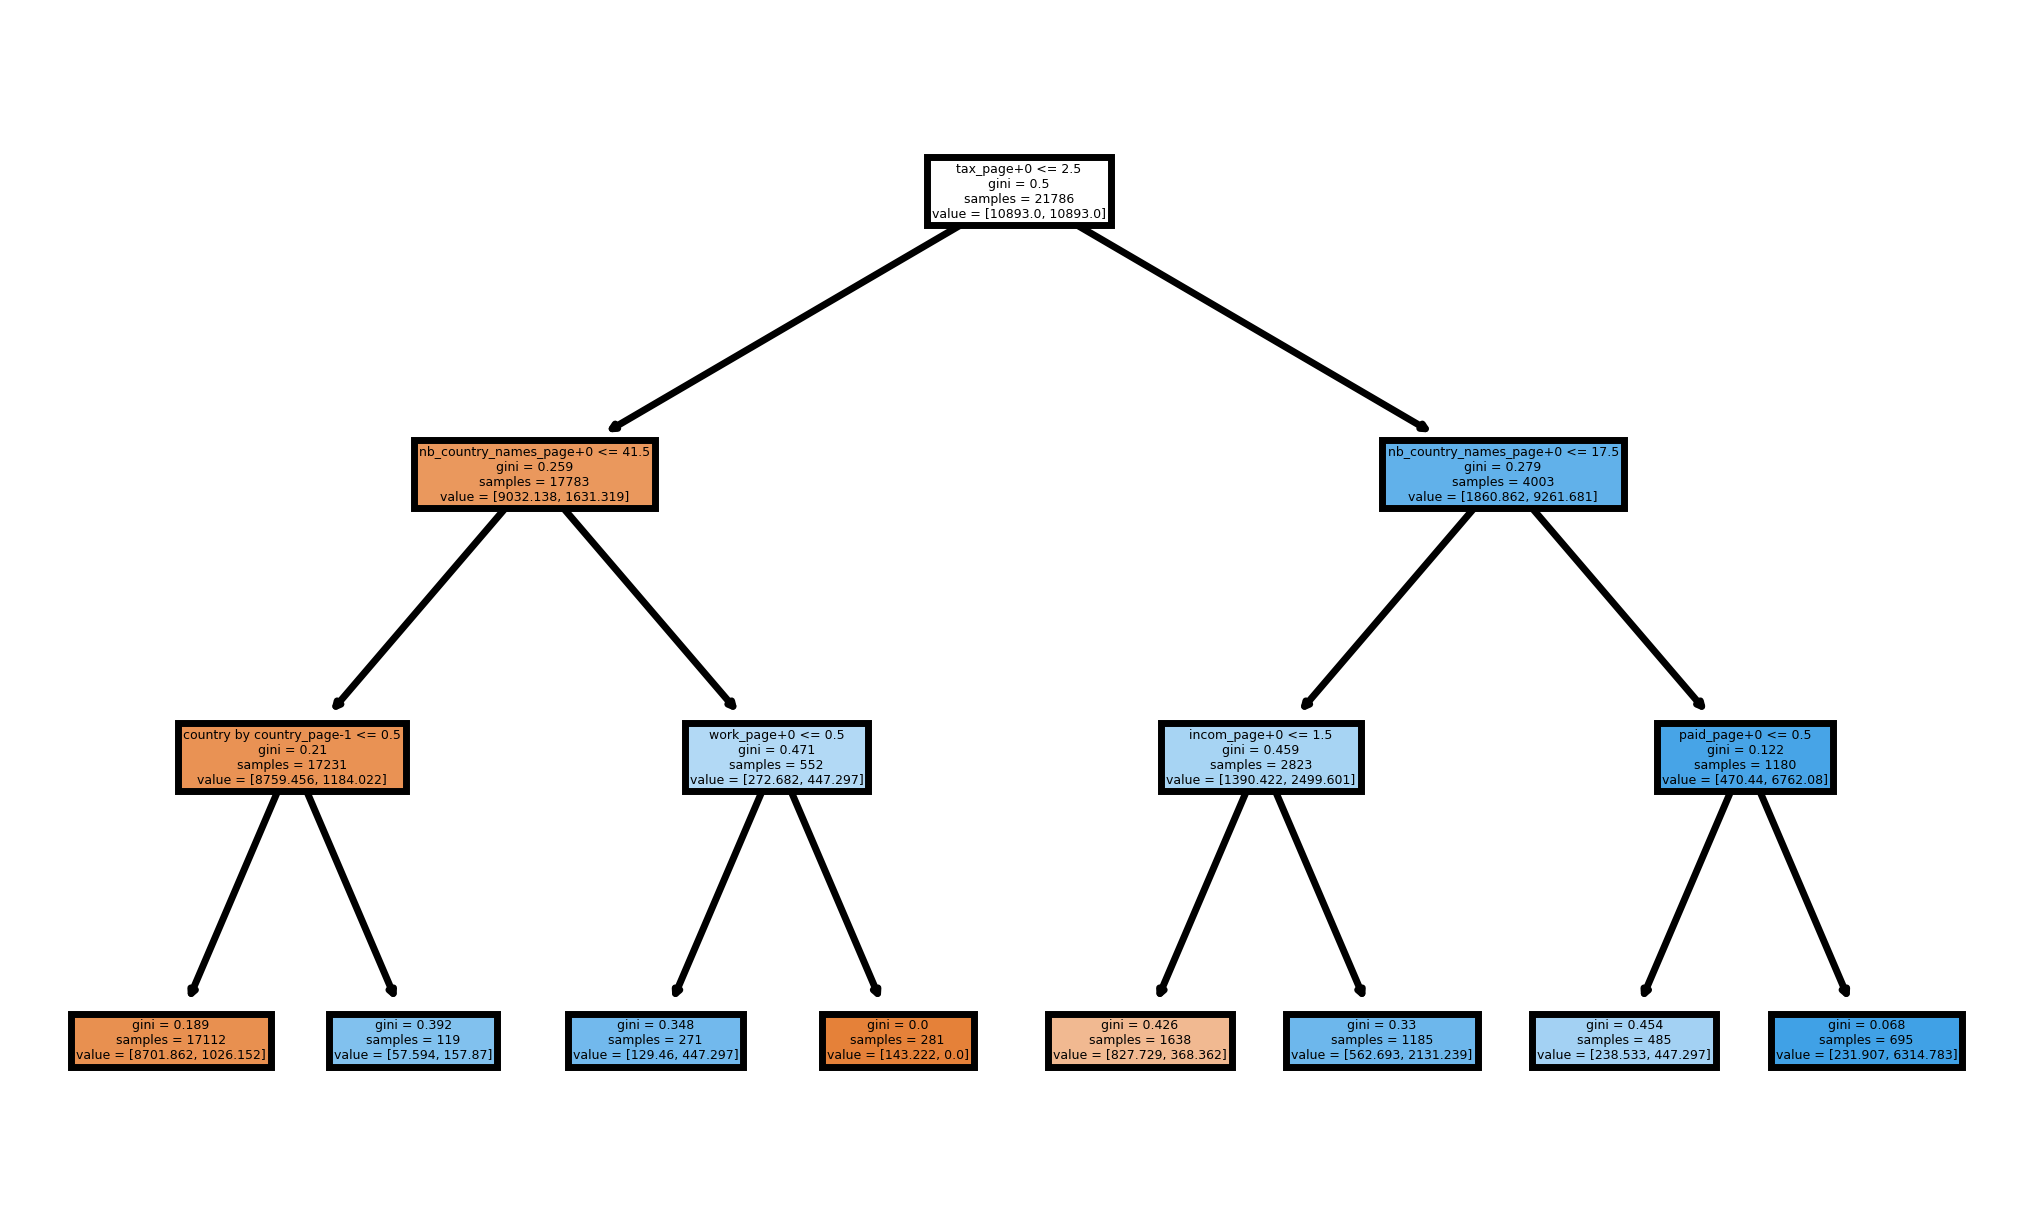

In [18]:
plt.figure(figsize=(5, 3), dpi=500)
plot_tree(best_dt_model, feature_names = df_train.columns, filled=True)
plt.show()

# Testing and validating the model  (Decision tree)

## Extract features form the testing data set

In [19]:
if "testing_dataset.csv" not in os.listdir():
    rows = []
    for f in tqdm(os.listdir("testing_dataset/"), desc="Extracting features from files"):
        for p in tqdm(range(len(os.listdir(f"testing_dataset/{f}"))), desc=f"Extracting features from pages of file {f}"):
            rows += [extract_feature_of_a_page("testing_dataset",f,p)]
    arr = np.vstack(rows)
    df_test= pd.DataFrame(arr[:,1:],columns=column_names[1:],index=arr[:,0])
    df_test.to_csv("testing_dataset.csv")
df_test = pd.read_csv("testing_dataset.csv", index_col=0)

Extracting features from files:   0%|                                                           | 0/58 [00:00<?, ?it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:   0%|                         | 0/172 [00:00<?, ?it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:   2%|▎                | 3/172 [00:00<00:08, 19.04it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:   3%|▍                | 5/172 [00:00<00:11, 14.46it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:   4%|▋                | 7/172 [00:00<00:12, 13.56it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:   5%|▉                | 9/172 [00:00<00:13, 11.88it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:   6%|█               | 11/172 [00:00<00:12, 12.78it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:   8%|█▏              | 13/172 [00:00<00:11, 14.35it/s]
Extracting features from pages of file A

Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  75%|███████████▎   | 129/172 [00:11<00:03, 13.02it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  76%|███████████▍   | 131/172 [00:11<00:02, 14.23it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  77%|███████████▌   | 133/172 [00:11<00:02, 15.23it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  78%|███████████▊   | 135/172 [00:11<00:02, 16.01it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  80%|███████████▉   | 137/172 [00:11<00:02, 15.38it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  81%|████████████   | 139/172 [00:11<00:02, 13.12it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  82%|████████████▎  | 141/172 [00:12<00:02, 12.26it/s]
Extracting features from pages of file Acciona_2021_CbCR_87.pdf:  83%|████████████▍  | 143/172 [00:12<00:02, 13.17it/s]
Extracting features from pages of file A

Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  35%|███▊       | 25/71 [00:05<00:12,  3.56it/s]
Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  37%|████       | 26/71 [00:05<00:10,  4.09it/s]
Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  38%|████▏      | 27/71 [00:05<00:10,  4.33it/s]
Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  39%|████▎      | 28/71 [00:06<00:11,  3.84it/s]
Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  41%|████▍      | 29/71 [00:06<00:12,  3.31it/s]
Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  42%|████▋      | 30/71 [00:07<00:14,  2.85it/s]
Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  44%|████▊      | 31/71 [00:07<00:14,  2.75it/s]
Extracting features from pages of file AkerSolutions_2014_CbCR_18.pdf:  45%|████▉      | 32/71 [00:07<00:13,  2.94it/s]
Extracting features from pages of file A

Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  57%|██████▎    | 29/51 [00:03<00:02,  7.50it/s]
Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  59%|██████▍    | 30/51 [00:03<00:02,  7.62it/s]
Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  63%|██████▉    | 32/51 [00:03<00:02,  9.00it/s]
Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  65%|███████    | 33/51 [00:03<00:01,  9.03it/s]
Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  67%|███████▎   | 34/51 [00:03<00:01,  9.02it/s]
Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  71%|███████▊   | 36/51 [00:03<00:01,  9.33it/s]
Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  73%|███████▉   | 37/51 [00:03<00:01,  8.40it/s]
Extracting features from pages of file AkerSolutions_2016_CbCR_36.pdf:  75%|████████▏  | 38/51 [00:04<00:01,  8.02it/s]
Extracting features from pages of file A

Extracting features from pages of file Allianz_2017_CbCR_7.pdf:  18%|███▍               | 2/11 [00:00<00:00, 12.65it/s]
Extracting features from pages of file Allianz_2017_CbCR_7.pdf:  36%|██████▉            | 4/11 [00:00<00:00,  8.26it/s]
Extracting features from pages of file Allianz_2017_CbCR_7.pdf:  45%|████████▋          | 5/11 [00:00<00:00,  7.65it/s]
Extracting features from pages of file Allianz_2017_CbCR_7.pdf:  55%|██████████▎        | 6/11 [00:00<00:00,  7.19it/s]
Extracting features from pages of file Allianz_2017_CbCR_7.pdf:  64%|████████████       | 7/11 [00:00<00:00,  7.40it/s]
Extracting features from pages of file Allianz_2017_CbCR_7.pdf:  73%|█████████████▊     | 8/11 [00:01<00:00,  7.15it/s]
Extracting features from pages of file Allianz_2017_CbCR_7.pdf:  82%|███████████████▌   | 9/11 [00:01<00:00,  6.86it/s]
Extracting features from pages of file Allianz_2017_CbCR_7.pdf: 100%|██████████████████| 11/11 [00:01<00:00,  7.74it/s]
Extracting features from files:  12%|███

Extracting features from pages of file Applus_2022_CbCR_138.pdf:  31%|█████           | 56/179 [00:06<00:14,  8.25it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  32%|█████           | 57/179 [00:06<00:14,  8.57it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  32%|█████▏          | 58/179 [00:07<00:14,  8.11it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  33%|█████▎          | 59/179 [00:07<00:16,  7.31it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  34%|█████▎          | 60/179 [00:07<00:15,  7.48it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  34%|█████▍          | 61/179 [00:07<00:15,  7.61it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  35%|█████▌          | 62/179 [00:07<00:14,  7.99it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  35%|█████▋          | 63/179 [00:07<00:15,  7.56it/s]
Extracting features from pages of file A

Extracting features from pages of file Applus_2022_CbCR_138.pdf:  70%|██████████▍    | 125/179 [00:16<00:11,  4.79it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  70%|██████████▌    | 126/179 [00:16<00:11,  4.46it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  71%|██████████▋    | 127/179 [00:16<00:12,  4.28it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  72%|██████████▋    | 128/179 [00:17<00:12,  4.19it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  72%|██████████▊    | 129/179 [00:17<00:12,  4.14it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  73%|██████████▉    | 130/179 [00:17<00:12,  4.01it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  73%|██████████▉    | 131/179 [00:17<00:11,  4.00it/s]
Extracting features from pages of file Applus_2022_CbCR_138.pdf:  74%|███████████    | 132/179 [00:18<00:11,  4.22it/s]
Extracting features from pages of file A

Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  24%|███▊            | 41/170 [00:04<00:17,  7.41it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  25%|███▉            | 42/170 [00:04<00:18,  6.84it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  25%|████            | 43/170 [00:04<00:19,  6.36it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  26%|████▏           | 44/170 [00:05<00:20,  6.26it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  26%|████▏           | 45/170 [00:05<00:19,  6.47it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  27%|████▎           | 46/170 [00:05<00:19,  6.41it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  28%|████▍           | 47/170 [00:05<00:19,  6.21it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  28%|████▌           | 48/170 [00:05<00:20,  5.95it/s]
Extracting features from pages of file A

Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  74%|███████████    | 125/170 [00:15<00:04,  9.04it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  74%|███████████    | 126/170 [00:15<00:04,  8.95it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  75%|███████████▎   | 128/170 [00:15<00:04,  9.07it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  76%|███████████▍   | 130/170 [00:15<00:04,  9.63it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  78%|███████████▋   | 132/170 [00:15<00:03, 10.67it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  79%|███████████▊   | 134/170 [00:15<00:03, 10.45it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  80%|████████████   | 136/170 [00:16<00:03,  9.55it/s]
Extracting features from pages of file ASTM_2021_CbCR_68-69.pdf:  81%|████████████▏  | 138/170 [00:16<00:03, 10.10it/s]
Extracting features from pages of file A

Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  26%|███▍         | 40/151 [00:06<00:14,  7.70it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  27%|███▌         | 41/151 [00:07<00:15,  7.31it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  28%|███▌         | 42/151 [00:07<00:16,  6.62it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  28%|███▋         | 43/151 [00:07<00:16,  6.55it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  29%|███▊         | 44/151 [00:07<00:15,  6.89it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  30%|███▊         | 45/151 [00:07<00:14,  7.15it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  30%|███▉         | 46/151 [00:07<00:14,  7.37it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  31%|████         | 47/151 [00:07<00:14,  7.28it/s]
Extracting features from pages of file B

Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  70%|████████▍   | 106/151 [00:18<00:07,  5.89it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  71%|████████▌   | 107/151 [00:18<00:07,  5.85it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  72%|████████▌   | 108/151 [00:18<00:07,  5.61it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  72%|████████▋   | 109/151 [00:19<00:07,  5.31it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  73%|████████▋   | 110/151 [00:19<00:07,  5.17it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  74%|████████▊   | 111/151 [00:19<00:07,  5.20it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  74%|████████▉   | 112/151 [00:19<00:07,  5.19it/s]
Extracting features from pages of file Barloworld_2021_CbCR_64.pdf:  75%|████████▉   | 113/151 [00:19<00:07,  5.14it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  16%|█▉          | 25/158 [00:03<00:19,  6.92it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  16%|█▉          | 26/158 [00:03<00:19,  6.65it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  17%|██          | 27/158 [00:03<00:20,  6.31it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  18%|██▏         | 28/158 [00:03<00:20,  6.39it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  18%|██▏         | 29/158 [00:04<00:20,  6.30it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  19%|██▎         | 30/158 [00:04<00:21,  6.00it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  20%|██▎         | 31/158 [00:04<00:22,  5.63it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  20%|██▍         | 32/158 [00:04<00:22,  5.50it/s]
Extracting features from pages of file B

Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  58%|██████▉     | 92/158 [00:17<00:11,  5.83it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  59%|███████     | 93/158 [00:17<00:10,  5.99it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  59%|███████▏    | 94/158 [00:17<00:09,  6.43it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  60%|███████▏    | 95/158 [00:17<00:08,  7.00it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  61%|███████▎    | 97/158 [00:17<00:07,  8.25it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  62%|███████▍    | 98/158 [00:17<00:07,  8.01it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  63%|███████▌    | 99/158 [00:17<00:07,  7.72it/s]
Extracting features from pages of file Bonava_2021_CbCR_139-140.pdf:  63%|██████▉    | 100/158 [00:18<00:08,  7.08it/s]
Extracting features from pages of file B

Extracting features from pages of file BT_2017_CbCR_9.pdf:  20%|████▊                   | 2/10 [00:00<00:00, 12.45it/s]
Extracting features from pages of file BT_2017_CbCR_9.pdf:  40%|█████████▌              | 4/10 [00:00<00:00, 11.12it/s]
Extracting features from pages of file BT_2017_CbCR_9.pdf:  60%|██████████████▍         | 6/10 [00:00<00:00, 11.80it/s]
Extracting features from pages of file BT_2017_CbCR_9.pdf: 100%|███████████████████████| 10/10 [00:00<00:00, 13.44it/s]
Extracting features from files:  22%|███████████▏                                      | 13/58 [02:34<11:17, 15.06s/it]
Extracting features from pages of file Cembre_2020_CbCR_56.PDF:   0%|                           | 0/68 [00:00<?, ?it/s]
Extracting features from pages of file Cembre_2020_CbCR_56.PDF:   4%|▊                  | 3/68 [00:00<00:03, 21.28it/s]
Extracting features from pages of file Cembre_2020_CbCR_56.PDF:   9%|█▋                 | 6/68 [00:00<00:03, 15.99it/s]
Extracting features from pages of file C

Extracting features from pages of file DNO_2021_CbCR_88.pdf:   0%|                             | 0/100 [00:00<?, ?it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:   2%|▍                    | 2/100 [00:00<00:05, 18.13it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:   4%|▊                    | 4/100 [00:00<00:07, 12.80it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:   6%|█▎                   | 6/100 [00:00<00:09,  9.58it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:   8%|█▋                   | 8/100 [00:01<00:14,  6.30it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:   9%|█▉                   | 9/100 [00:01<00:16,  5.46it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  10%|██                  | 10/100 [00:01<00:18,  4.92it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  11%|██▏                 | 11/100 [00:01<00:19,  4.49it/s]
Extracting features from pages of file D

Extracting features from pages of file DNO_2021_CbCR_88.pdf:  82%|████████████████▍   | 82/100 [00:12<00:02,  8.64it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  83%|████████████████▌   | 83/100 [00:12<00:01,  8.60it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  84%|████████████████▊   | 84/100 [00:13<00:01,  8.34it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  86%|█████████████████▏  | 86/100 [00:13<00:01,  9.41it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  87%|█████████████████▍  | 87/100 [00:13<00:01,  9.18it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  88%|█████████████████▌  | 88/100 [00:13<00:01,  9.30it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  90%|██████████████████  | 90/100 [00:13<00:00, 11.16it/s]
Extracting features from pages of file DNO_2021_CbCR_88.pdf:  93%|██████████████████▌ | 93/100 [00:13<00:00, 15.56it/s]
Extracting features from pages of file D

Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  38%|█████▎        | 82/216 [00:08<00:16,  8.13it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  38%|█████▍        | 83/216 [00:09<00:15,  8.33it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  39%|█████▍        | 84/216 [00:09<00:15,  8.59it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  40%|█████▌        | 86/216 [00:09<00:13,  9.40it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  40%|█████▋        | 87/216 [00:09<00:14,  8.61it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  41%|█████▋        | 88/216 [00:09<00:19,  6.72it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  41%|█████▊        | 89/216 [00:09<00:23,  5.42it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  42%|█████▊        | 90/216 [00:10<00:25,  4.94it/s]
Extracting features from pages of file E

Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  75%|█████████▋   | 161/216 [00:19<00:06,  8.61it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  75%|█████████▊   | 162/216 [00:19<00:06,  7.79it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  75%|█████████▊   | 163/216 [00:19<00:06,  7.66it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  76%|█████████▉   | 165/216 [00:19<00:05, 10.04it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  77%|██████████   | 167/216 [00:19<00:04, 11.02it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  78%|██████████▏  | 169/216 [00:19<00:03, 12.63it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  79%|██████████▎  | 171/216 [00:19<00:03, 14.15it/s]
Extracting features from pages of file ENAV_2020_CbCR_179-180.pdf:  80%|██████████▍  | 173/216 [00:19<00:02, 14.49it/s]
Extracting features from pages of file E

Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  81%|██████████████▌   | 58/72 [00:06<00:01,  7.33it/s]
Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  82%|██████████████▊   | 59/72 [00:06<00:01,  7.30it/s]
Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  83%|███████████████   | 60/72 [00:07<00:01,  7.52it/s]
Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  85%|███████████████▎  | 61/72 [00:07<00:01,  7.00it/s]
Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  86%|███████████████▌  | 62/72 [00:07<00:02,  4.81it/s]
Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  88%|███████████████▊  | 63/72 [00:07<00:01,  5.33it/s]
Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  90%|████████████████▎ | 65/72 [00:07<00:00,  7.07it/s]
Extracting features from pages of file Endesa_2019_CbCR_57.pdf:  92%|████████████████▌ | 66/72 [00:08<00:00,  7.47it/s]
Extracting features from pages of file E

Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  21%|███▉               | 7/34 [00:00<00:03,  7.43it/s]
Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  24%|████▍              | 8/34 [00:01<00:03,  6.97it/s]
Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  26%|█████              | 9/34 [00:01<00:03,  6.82it/s]
Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  32%|█████▊            | 11/34 [00:01<00:02,  8.00it/s]
Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  38%|██████▉           | 13/34 [00:01<00:02,  7.79it/s]
Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  41%|███████▍          | 14/34 [00:01<00:02,  7.10it/s]
Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  44%|███████▉          | 15/34 [00:02<00:03,  6.27it/s]
Extracting features from pages of file ENI_2020_CbCR_12-13.pdf:  47%|████████▍         | 16/34 [00:02<00:03,  5.86it/s]
Extracting features from pages of file E

Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  18%|██▉             | 28/152 [00:03<00:15,  7.89it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  19%|███             | 29/152 [00:03<00:16,  7.61it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  20%|███▏            | 30/152 [00:03<00:17,  6.87it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  20%|███▎            | 31/152 [00:03<00:19,  6.36it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  21%|███▎            | 32/152 [00:04<00:20,  5.74it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  22%|███▍            | 33/152 [00:04<00:21,  5.53it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  22%|███▌            | 34/152 [00:04<00:20,  5.66it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  23%|███▋            | 35/152 [00:04<00:18,  6.40it/s]
Extracting features from pages of file F

Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  72%|██████████▊    | 109/152 [00:15<00:03, 13.55it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  73%|██████████▉    | 111/152 [00:15<00:03, 11.16it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  74%|███████████▏   | 113/152 [00:15<00:04,  9.49it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  76%|███████████▎   | 115/152 [00:16<00:04,  8.27it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  76%|███████████▍   | 116/152 [00:16<00:04,  7.86it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  77%|███████████▌   | 117/152 [00:16<00:04,  7.15it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  78%|███████████▋   | 118/152 [00:16<00:05,  6.62it/s]
Extracting features from pages of file Feralpi_2021_CbCR_55.pdf:  78%|███████████▋   | 119/152 [00:16<00:05,  6.23it/s]
Extracting features from pages of file F

Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  23%|███▍           | 35/153 [00:06<00:18,  6.43it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  24%|███▌           | 36/153 [00:06<00:18,  6.46it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  24%|███▋           | 37/153 [00:06<00:18,  6.11it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  25%|███▋           | 38/153 [00:06<00:19,  5.88it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  25%|███▊           | 39/153 [00:06<00:19,  5.80it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  26%|███▉           | 40/153 [00:07<00:19,  5.65it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  27%|████           | 41/153 [00:07<00:21,  5.21it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  27%|████           | 42/153 [00:07<00:21,  5.16it/s]
Extracting features from pages of file F

Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  66%|█████████▏    | 101/153 [00:23<00:09,  5.36it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  67%|█████████▎    | 102/153 [00:24<00:11,  4.63it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  67%|█████████▍    | 103/153 [00:24<00:13,  3.78it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  68%|█████████▌    | 104/153 [00:24<00:13,  3.61it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  69%|█████████▌    | 105/153 [00:24<00:12,  3.87it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  69%|█████████▋    | 106/153 [00:25<00:10,  4.64it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  70%|█████████▊    | 107/153 [00:25<00:09,  5.06it/s]
Extracting features from pages of file Finnair_2021_CbCR_144.pdf:  71%|█████████▉    | 108/153 [00:25<00:08,  5.37it/s]
Extracting features from pages of file F

Extracting features from pages of file Fortum_2018_CbCR_12-13.pdf:  87%|█████████████  | 13/15 [00:02<00:00,  5.43it/s]
Extracting features from pages of file Fortum_2018_CbCR_12-13.pdf:  93%|██████████████ | 14/15 [00:02<00:00,  5.58it/s]
Extracting features from pages of file Fortum_2018_CbCR_12-13.pdf: 100%|███████████████| 15/15 [00:02<00:00,  5.64it/s]
Extracting features from files:  43%|█████████████████████▌                            | 25/58 [04:44<07:22, 13.42s/it]
Extracting features from pages of file IKEA_2022_CbCR_10-11.pdf:   0%|                          | 0/13 [00:00<?, ?it/s]
Extracting features from pages of file IKEA_2022_CbCR_10-11.pdf:  15%|██▊               | 2/13 [00:00<00:00, 14.62it/s]
Extracting features from pages of file IKEA_2022_CbCR_10-11.pdf:  31%|█████▌            | 4/13 [00:00<00:00, 10.88it/s]
Extracting features from pages of file IKEA_2022_CbCR_10-11.pdf:  46%|████████▎         | 6/13 [00:00<00:00, 10.71it/s]
Extracting features from pages of file I

Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  41%|██████         | 53/130 [00:09<00:13,  5.50it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  42%|██████▏        | 54/130 [00:09<00:13,  5.60it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  42%|██████▎        | 55/130 [00:10<00:13,  5.53it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  43%|██████▍        | 56/130 [00:10<00:13,  5.29it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  44%|██████▌        | 57/130 [00:10<00:14,  5.09it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  45%|██████▋        | 58/130 [00:10<00:15,  4.74it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  45%|██████▊        | 59/130 [00:10<00:15,  4.55it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  46%|██████▉        | 60/130 [00:11<00:15,  4.59it/s]
Extracting features from pages of file I

Extracting features from pages of file Indra_2020_CbCR_37-39.pdf:  96%|█████████████▍| 125/130 [00:20<00:00,  9.02it/s]
Extracting features from pages of file Indra_2020_CbCR_37-39.pdf: 100%|██████████████| 130/130 [00:20<00:00,  6.29it/s]
Extracting features from files:  47%|███████████████████████▎                          | 27/58 [05:06<06:44, 13.05s/it]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:   0%|                  | 0/108 [00:00<?, ?it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:   2%|▏         | 2/108 [00:00<00:10,  9.89it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:   3%|▎         | 3/108 [00:00<00:10,  9.87it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:   4%|▎         | 4/108 [00:00<00:10,  9.50it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:   6%|▌         | 6/108 [00:00<00:11,  9.27it/s]
Extracting features from pages of file I

Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  78%|███████  | 84/108 [00:09<00:03,  7.61it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  80%|███████▏ | 86/108 [00:09<00:02,  8.86it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  81%|███████▎ | 88/108 [00:09<00:02,  9.20it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  82%|███████▍ | 89/108 [00:09<00:02,  9.08it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  83%|███████▌ | 90/108 [00:10<00:02,  8.84it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  84%|███████▌ | 91/108 [00:10<00:01,  8.87it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  85%|███████▋ | 92/108 [00:10<00:01,  8.56it/s]
Extracting features from pages of file InsudPharma_2020_CbCR_97-98.pdf:  86%|███████▊ | 93/108 [00:10<00:01,  8.54it/s]
Extracting features from pages of file I

Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  53%|███▋   | 62/116 [00:07<00:04, 11.02it/s]
Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  56%|███▉   | 65/116 [00:07<00:03, 14.98it/s]
Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  58%|████   | 67/116 [00:07<00:03, 14.49it/s]
Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  59%|████▏  | 69/116 [00:07<00:03, 13.66it/s]
Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  61%|████▎  | 71/116 [00:07<00:03, 13.19it/s]
Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  63%|████▍  | 73/116 [00:07<00:03, 13.02it/s]
Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  65%|████▌  | 75/116 [00:07<00:03, 13.16it/s]
Extracting features from pages of file InsudPharma_2021_CbCR_106-107.pdf:  66%|████▋  | 77/116 [00:08<00:02, 13.04it/s]
Extracting features from pages of file I

Extracting features from pages of file KPN_2022_CbCR_229.pdf:  16%|███▏               | 41/249 [00:07<00:37,  5.61it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  17%|███▏               | 42/249 [00:07<00:40,  5.17it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  17%|███▎               | 43/249 [00:07<00:42,  4.80it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  18%|███▎               | 44/249 [00:07<00:43,  4.73it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  18%|███▍               | 45/249 [00:07<00:42,  4.82it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  18%|███▌               | 46/249 [00:08<00:40,  4.95it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  19%|███▌               | 47/249 [00:08<00:42,  4.76it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  19%|███▋               | 48/249 [00:08<00:42,  4.76it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2022_CbCR_229.pdf:  45%|████████▏         | 113/249 [00:20<00:23,  5.90it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  46%|████████▏         | 114/249 [00:20<00:23,  5.72it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  46%|████████▎         | 115/249 [00:20<00:23,  5.60it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  47%|████████▍         | 116/249 [00:20<00:26,  5.08it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  47%|████████▍         | 117/249 [00:20<00:25,  5.19it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  47%|████████▌         | 118/249 [00:21<00:24,  5.30it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  48%|████████▌         | 119/249 [00:21<00:23,  5.63it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  48%|████████▋         | 120/249 [00:21<00:23,  5.57it/s]
Extracting features from pages of file K

Extracting features from pages of file KPN_2022_CbCR_229.pdf:  73%|█████████████     | 181/249 [00:33<00:17,  3.87it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  73%|█████████████▏    | 182/249 [00:33<00:17,  3.72it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  73%|█████████████▏    | 183/249 [00:33<00:17,  3.81it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  74%|█████████████▎    | 184/249 [00:33<00:17,  3.70it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  74%|█████████████▎    | 185/249 [00:34<00:17,  3.62it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  75%|█████████████▍    | 186/249 [00:34<00:17,  3.56it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  75%|█████████████▌    | 187/249 [00:34<00:15,  3.92it/s]
Extracting features from pages of file KPN_2022_CbCR_229.pdf:  76%|█████████████▌    | 188/249 [00:34<00:13,  4.39it/s]
Extracting features from pages of file K

Extracting features from files:  52%|█████████████████████████▊                        | 30/58 [06:14<10:23, 22.28s/it]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:   0%|                       | 0/432 [00:00<?, ?it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:   0%|               | 1/432 [00:00<00:56,  7.64it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:   0%|               | 2/432 [00:00<01:19,  5.41it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:   1%|               | 3/432 [00:00<01:29,  4.79it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:   1%|▏              | 4/432 [00:00<01:19,  5.39it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:   1%|▏              | 5/432 [00:00<01:09,  6.13it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:   1%|▏              | 6/432 [00:00<01:02,  6.78it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  16%|██▎           | 71/432 [00:11<01:07,  5.36it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  17%|██▎           | 72/432 [00:11<01:03,  5.70it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  17%|██▎           | 73/432 [00:11<00:55,  6.42it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  17%|██▍           | 75/432 [00:11<00:44,  8.03it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  18%|██▍           | 76/432 [00:11<00:42,  8.36it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  18%|██▌           | 78/432 [00:11<00:35,  9.93it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  19%|██▌           | 80/432 [00:12<00:40,  8.79it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  19%|██▋           | 81/432 [00:12<00:42,  8.32it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  34%|████▍        | 146/432 [00:22<00:53,  5.34it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  34%|████▍        | 147/432 [00:23<00:58,  4.88it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  34%|████▍        | 148/432 [00:23<00:56,  5.06it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  34%|████▍        | 149/432 [00:23<00:50,  5.66it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  35%|████▌        | 150/432 [00:23<00:45,  6.17it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  35%|████▌        | 151/432 [00:23<00:46,  6.04it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  35%|████▌        | 152/432 [00:24<00:49,  5.61it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  35%|████▌        | 153/432 [00:24<00:51,  5.43it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  50%|██████▌      | 218/432 [00:34<00:45,  4.73it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  51%|██████▌      | 219/432 [00:34<00:45,  4.65it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  51%|██████▌      | 220/432 [00:34<00:44,  4.73it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  51%|██████▋      | 221/432 [00:35<00:40,  5.18it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  52%|██████▋      | 223/432 [00:35<00:29,  6.98it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  52%|██████▊      | 225/432 [00:35<00:27,  7.40it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  52%|██████▊      | 226/432 [00:35<00:29,  6.97it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  53%|██████▊      | 227/432 [00:35<00:31,  6.47it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  68%|████████▉    | 295/432 [00:45<00:13, 10.23it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  69%|████████▉    | 297/432 [00:45<00:12, 10.59it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  69%|████████▉    | 299/432 [00:45<00:16,  7.87it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  69%|█████████    | 300/432 [00:46<00:19,  6.68it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  70%|█████████    | 301/432 [00:46<00:22,  5.91it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  70%|█████████    | 302/432 [00:46<00:23,  5.60it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  70%|█████████    | 303/432 [00:46<00:23,  5.58it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  70%|█████████▏   | 304/432 [00:46<00:22,  5.61it/s]
Extracting features from pages of file L

Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  85%|███████████  | 369/432 [00:56<00:09,  6.82it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  86%|███████████▏ | 370/432 [00:56<00:09,  6.24it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  86%|███████████▏ | 371/432 [00:56<00:10,  5.92it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  86%|███████████▏ | 372/432 [00:56<00:10,  5.71it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  86%|███████████▏ | 373/432 [00:56<00:10,  5.59it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  87%|███████████▎ | 374/432 [00:57<00:10,  5.53it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  87%|███████████▎ | 375/432 [00:57<00:10,  5.51it/s]
Extracting features from pages of file Leonardo_2021_CbCR_399.pdf:  87%|███████████▎ | 376/432 [00:57<00:09,  5.70it/s]
Extracting features from pages of file L

Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  15%|██▎            | 6/40 [00:00<00:03,  9.63it/s]
Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  20%|███            | 8/40 [00:00<00:03,  8.61it/s]
Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  25%|███▌          | 10/40 [00:01<00:03,  8.89it/s]
Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  28%|███▊          | 11/40 [00:01<00:03,  9.07it/s]
Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  30%|████▏         | 12/40 [00:01<00:03,  8.35it/s]
Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  32%|████▌         | 13/40 [00:01<00:03,  7.73it/s]
Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  35%|████▉         | 14/40 [00:01<00:03,  7.19it/s]
Extracting features from pages of file Newmont_2022_CbCR_20-21.pdf:  38%|█████▎        | 15/40 [00:01<00:03,  7.62it/s]
Extracting features from pages of file N

Extracting features from pages of file OTB_2020_CbCR_83.pdf:  38%|████████             | 34/89 [00:05<00:11,  4.84it/s]
Extracting features from pages of file OTB_2020_CbCR_83.pdf:  39%|████████▎            | 35/89 [00:06<00:10,  4.97it/s]
Extracting features from pages of file OTB_2020_CbCR_83.pdf:  40%|████████▍            | 36/89 [00:06<00:09,  5.56it/s]
Extracting features from pages of file OTB_2020_CbCR_83.pdf:  42%|████████▋            | 37/89 [00:06<00:09,  5.74it/s]
Extracting features from pages of file OTB_2020_CbCR_83.pdf:  43%|████████▉            | 38/89 [00:06<00:09,  5.62it/s]
Extracting features from pages of file OTB_2020_CbCR_83.pdf:  44%|█████████▏           | 39/89 [00:06<00:09,  5.11it/s]
Extracting features from pages of file OTB_2020_CbCR_83.pdf:  45%|█████████▍           | 40/89 [00:06<00:09,  4.94it/s]
Extracting features from pages of file OTB_2020_CbCR_83.pdf:  46%|█████████▋           | 41/89 [00:07<00:09,  5.14it/s]
Extracting features from pages of file O

Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:   9%|▎   | 15/164 [00:01<00:15,  9.56it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  10%|▍   | 17/164 [00:01<00:14, 10.00it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  12%|▍   | 19/164 [00:01<00:12, 11.40it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  13%|▌   | 21/164 [00:01<00:12, 11.38it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  14%|▌   | 23/164 [00:02<00:12, 10.98it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  15%|▌   | 25/164 [00:02<00:13,  9.97it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  16%|▋   | 27/164 [00:02<00:15,  8.57it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  17%|▋   | 28/164 [00:02<00:15,  8.66it/s]
Extracting features from pages of file P

Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  64%|█▉ | 105/164 [00:13<00:10,  5.51it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  65%|█▉ | 106/164 [00:14<00:11,  5.07it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  65%|█▉ | 107/164 [00:14<00:10,  5.44it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  66%|█▉ | 108/164 [00:14<00:10,  5.54it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  66%|█▉ | 109/164 [00:14<00:09,  5.90it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  67%|██ | 110/164 [00:14<00:10,  5.35it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  68%|██ | 111/164 [00:15<00:11,  4.74it/s]
Extracting features from pages of file Piaggio_2020_CbCR_Full_Report_69.pdf:  68%|██ | 112/164 [00:15<00:11,  4.46it/s]
Extracting features from pages of file P

Extracting features from pages of file Prudential_2021_CBCR_8.pdf: 100%|███████████████| 20/20 [00:03<00:00,  6.29it/s]
Extracting features from files:  66%|████████████████████████████████▊                 | 38/58 [08:07<03:29, 10.49s/it]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:   0%|                       | 0/424 [00:00<?, ?it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:   1%|▏              | 4/424 [00:00<00:15, 27.05it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:   2%|▏              | 7/424 [00:00<00:24, 16.91it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:   2%|▎              | 9/424 [00:00<00:31, 13.19it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:   3%|▎             | 11/424 [00:00<00:38, 10.73it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:   3%|▍             | 13/424 [00:01<00:44,  9.30it/s]
Extracting features from pages of file P

Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  17%|██▍           | 74/424 [00:10<00:52,  6.66it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  18%|██▍           | 75/424 [00:11<00:48,  7.22it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  18%|██▌           | 76/424 [00:11<00:47,  7.37it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  18%|██▌           | 77/424 [00:11<00:46,  7.38it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  18%|██▌           | 78/424 [00:11<00:51,  6.73it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  19%|██▌           | 79/424 [00:11<00:56,  6.13it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  19%|██▋           | 80/424 [00:11<01:03,  5.46it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  19%|██▋           | 81/424 [00:12<01:08,  5.03it/s]
Extracting features from pages of file P

Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  34%|████▍        | 143/424 [00:23<00:36,  7.63it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  34%|████▍        | 144/424 [00:23<00:38,  7.27it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  34%|████▍        | 145/424 [00:24<00:43,  6.47it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  34%|████▍        | 146/424 [00:24<00:45,  6.06it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  35%|████▌        | 147/424 [00:24<00:47,  5.83it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  35%|████▌        | 148/424 [00:24<00:49,  5.60it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  35%|████▌        | 149/424 [00:24<00:52,  5.20it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  35%|████▌        | 150/424 [00:25<00:54,  4.99it/s]
Extracting features from pages of file P

Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  50%|██████▍      | 211/424 [00:35<00:31,  6.81it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  50%|██████▌      | 213/424 [00:35<00:23,  8.97it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  51%|██████▌      | 215/424 [00:35<00:18, 11.19it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  51%|██████▋      | 217/424 [00:35<00:16, 12.26it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  52%|██████▋      | 219/424 [00:36<00:15, 13.33it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  52%|██████▊      | 221/424 [00:36<00:14, 13.76it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  53%|██████▊      | 223/424 [00:36<00:18, 11.13it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  53%|██████▉      | 225/424 [00:36<00:20,  9.52it/s]
Extracting features from pages of file P

Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  71%|█████████▏   | 301/424 [00:46<00:20,  5.88it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  71%|█████████▎   | 302/424 [00:46<00:22,  5.34it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  71%|█████████▎   | 303/424 [00:46<00:23,  5.10it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  72%|█████████▎   | 304/424 [00:46<00:24,  4.96it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  72%|█████████▎   | 305/424 [00:47<00:24,  4.93it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  72%|█████████▍   | 306/424 [00:47<00:24,  4.84it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  72%|█████████▍   | 307/424 [00:47<00:23,  4.97it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  73%|█████████▍   | 308/424 [00:47<00:21,  5.31it/s]
Extracting features from pages of file P

Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  92%|███████████▉ | 389/424 [00:57<00:04,  7.09it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  92%|███████████▉ | 390/424 [00:57<00:04,  7.04it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  92%|███████████▉ | 391/424 [00:57<00:04,  7.20it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  92%|████████████ | 392/424 [00:57<00:04,  7.41it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  93%|████████████ | 393/424 [00:58<00:04,  7.12it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  93%|████████████ | 394/424 [00:58<00:04,  6.69it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  93%|████████████ | 395/424 [00:58<00:04,  6.22it/s]
Extracting features from pages of file Prysmian_2021_CbCR_115.pdf:  93%|████████████▏| 396/424 [00:58<00:04,  5.87it/s]
Extracting features from pages of file P

Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  16%|█▋        | 51/310 [00:06<00:32,  8.06it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  17%|█▋        | 53/310 [00:06<00:27,  9.40it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  17%|█▋        | 54/310 [00:06<00:30,  8.35it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  18%|█▊        | 55/310 [00:06<00:34,  7.35it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  18%|█▊        | 56/310 [00:07<00:34,  7.35it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  18%|█▊        | 57/310 [00:07<00:32,  7.85it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  19%|█▊        | 58/310 [00:07<00:31,  7.99it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  19%|█▉        | 59/310 [00:07<00:33,  7.50it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  43%|███▊     | 133/310 [00:17<00:20,  8.46it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  43%|███▉     | 134/310 [00:17<00:23,  7.50it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  44%|███▉     | 135/310 [00:17<00:26,  6.64it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  44%|███▉     | 136/310 [00:18<00:28,  6.10it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  44%|███▉     | 137/310 [00:18<00:28,  6.15it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  45%|████     | 138/310 [00:18<00:27,  6.36it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  45%|████     | 139/310 [00:18<00:24,  6.91it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  45%|████     | 140/310 [00:18<00:24,  6.96it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  67%|██████   | 208/310 [00:28<00:17,  5.84it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  67%|██████   | 209/310 [00:28<00:18,  5.60it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  68%|██████   | 210/310 [00:28<00:18,  5.36it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  68%|██████▏  | 211/310 [00:29<00:19,  4.99it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  68%|██████▏  | 212/310 [00:29<00:19,  5.13it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  69%|██████▏  | 213/310 [00:29<00:17,  5.39it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  69%|██████▏  | 214/310 [00:29<00:16,  5.78it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  69%|██████▏  | 215/310 [00:29<00:15,  6.28it/s]
Extracting features from pages of file R

Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  89%|████████ | 277/310 [00:39<00:07,  4.64it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  90%|████████ | 278/310 [00:39<00:06,  5.07it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  90%|████████▏| 280/310 [00:39<00:04,  7.37it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  91%|████████▏| 281/310 [00:39<00:03,  7.78it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  91%|████████▏| 282/310 [00:40<00:03,  7.31it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  91%|████████▏| 283/310 [00:40<00:04,  6.58it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  92%|████████▏| 284/310 [00:40<00:03,  6.55it/s]
Extracting features from pages of file Randstad_2021_CbCR_153-155.pdf:  92%|████████▎| 285/310 [00:40<00:03,  6.87it/s]
Extracting features from pages of file R

Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  35%|█████▌          | 42/120 [00:04<00:08,  9.42it/s]
Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  36%|█████▋          | 43/120 [00:04<00:08,  8.98it/s]
Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  38%|██████          | 45/120 [00:04<00:07, 10.15it/s]
Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  39%|██████▎         | 47/120 [00:04<00:06, 10.89it/s]
Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  41%|██████▌         | 49/120 [00:04<00:06, 11.30it/s]
Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  42%|██████▊         | 51/120 [00:05<00:06, 10.51it/s]
Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  44%|███████         | 53/120 [00:05<00:08,  8.23it/s]
Extracting features from pages of file SAES_2021_CbCR_84-85.pdf:  45%|███████▏        | 54/120 [00:05<00:08,  7.81it/s]
Extracting features from pages of file S

Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  28%|█████             | 21/75 [00:04<00:14,  3.69it/s]
Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  29%|█████▎            | 22/75 [00:04<00:13,  3.81it/s]
Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  31%|█████▌            | 23/75 [00:04<00:11,  4.52it/s]
Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  32%|█████▊            | 24/75 [00:05<00:10,  4.94it/s]
Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  33%|██████            | 25/75 [00:05<00:11,  4.34it/s]
Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  35%|██████▏           | 26/75 [00:05<00:13,  3.64it/s]
Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  36%|██████▍           | 27/75 [00:06<00:14,  3.39it/s]
Extracting features from pages of file SGR_2018_CbCR_62-63.pdf:  37%|██████▋           | 28/75 [00:06<00:13,  3.58it/s]
Extracting features from pages of file S

Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  28%|████▍           | 14/50 [00:02<00:05,  6.77it/s]
Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  30%|████▊           | 15/50 [00:02<00:05,  6.71it/s]
Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  32%|█████           | 16/50 [00:02<00:05,  6.47it/s]
Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  34%|█████▍          | 17/50 [00:02<00:05,  6.32it/s]
Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  36%|█████▊          | 18/50 [00:02<00:05,  6.31it/s]
Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  38%|██████          | 19/50 [00:02<00:04,  6.45it/s]
Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  40%|██████▍         | 20/50 [00:03<00:04,  6.45it/s]
Extracting features from pages of file SHELL_2018_CbCR_48-50.pdf:  42%|██████▋         | 21/50 [00:03<00:04,  6.22it/s]
Extracting features from pages of file S

Extracting features from pages of file Siltronic_2021_CbCR_30.pdf:  97%|██████████████▌| 32/33 [00:05<00:00,  4.17it/s]
Extracting features from pages of file Siltronic_2021_CbCR_30.pdf: 100%|███████████████| 33/33 [00:05<00:00,  5.65it/s]
Extracting features from files:  79%|███████████████████████████████████████▋          | 46/58 [10:34<02:13, 11.12s/it]
Extracting features from pages of file SOL_2021_CbCR_48-49.pdf:   0%|                           | 0/59 [00:00<?, ?it/s]
Extracting features from pages of file SOL_2021_CbCR_48-49.pdf:   3%|▋                  | 2/59 [00:00<00:04, 13.50it/s]
Extracting features from pages of file SOL_2021_CbCR_48-49.pdf:   7%|█▎                 | 4/59 [00:00<00:07,  7.48it/s]
Extracting features from pages of file SOL_2021_CbCR_48-49.pdf:   8%|█▌                 | 5/59 [00:00<00:07,  6.76it/s]
Extracting features from pages of file SOL_2021_CbCR_48-49.pdf:  10%|█▉                 | 6/59 [00:00<00:07,  7.04it/s]
Extracting features from pages of file S

Extracting features from pages of file South32_2019_CbCR_15.pdf:  38%|██████▊           | 9/24 [00:00<00:01,  8.73it/s]
Extracting features from pages of file South32_2019_CbCR_15.pdf:  42%|███████          | 10/24 [00:01<00:01,  7.95it/s]
Extracting features from pages of file South32_2019_CbCR_15.pdf:  46%|███████▊         | 11/24 [00:01<00:01,  7.66it/s]
Extracting features from pages of file South32_2019_CbCR_15.pdf:  50%|████████▌        | 12/24 [00:01<00:01,  7.25it/s]
Extracting features from pages of file South32_2019_CbCR_15.pdf:  54%|█████████▏       | 13/24 [00:01<00:01,  7.12it/s]
Extracting features from pages of file South32_2019_CbCR_15.pdf:  58%|█████████▉       | 14/24 [00:01<00:01,  7.03it/s]
Extracting features from pages of file South32_2019_CbCR_15.pdf:  62%|██████████▋      | 15/24 [00:01<00:01,  6.98it/s]
Extracting features from pages of file South32_2019_CbCR_15.pdf:  67%|███████████▎     | 16/24 [00:02<00:01,  6.76it/s]
Extracting features from pages of file S

Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  14%|██▏             | 25/184 [00:03<00:28,  5.64it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  14%|██▎             | 26/184 [00:03<00:26,  5.86it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  15%|██▍             | 28/184 [00:03<00:21,  7.31it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  16%|██▌             | 30/184 [00:03<00:18,  8.48it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  17%|██▊             | 32/184 [00:03<00:16,  9.16it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  18%|██▉             | 34/184 [00:03<00:15,  9.98it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  20%|███▏            | 36/184 [00:04<00:17,  8.55it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  20%|███▏            | 37/184 [00:04<00:20,  7.11it/s]
Extracting features from pages of file T

Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  53%|████████▍       | 97/184 [00:16<00:34,  2.55it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  53%|████████▌       | 98/184 [00:16<00:34,  2.47it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  54%|████████▌       | 99/184 [00:17<00:33,  2.51it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  54%|████████▏      | 100/184 [00:17<00:31,  2.70it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  55%|████████▏      | 101/184 [00:17<00:27,  3.01it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  55%|████████▎      | 102/184 [00:17<00:25,  3.23it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  56%|████████▍      | 103/184 [00:18<00:22,  3.60it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  57%|████████▍      | 104/184 [00:18<00:19,  4.18it/s]
Extracting features from pages of file T

Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  91%|█████████████▌ | 167/184 [00:29<00:02,  7.40it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  91%|█████████████▋ | 168/184 [00:29<00:02,  7.21it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  92%|█████████████▊ | 169/184 [00:29<00:02,  7.26it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  92%|█████████████▊ | 170/184 [00:29<00:01,  7.37it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  93%|██████████████ | 172/184 [00:29<00:01,  9.27it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  95%|██████████████▏| 174/184 [00:29<00:00, 11.70it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  97%|██████████████▌| 178/184 [00:29<00:00, 15.47it/s]
Extracting features from pages of file Telenor_2020_CbCR_74.pdf:  98%|██████████████▋| 180/184 [00:30<00:00, 10.43it/s]
Extracting features from pages of file T

Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  32%|█████           | 59/187 [00:12<00:29,  4.40it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  32%|█████▏          | 60/187 [00:12<00:27,  4.61it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  33%|█████▏          | 61/187 [00:12<00:24,  5.12it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  33%|█████▎          | 62/187 [00:12<00:23,  5.22it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  34%|█████▍          | 63/187 [00:12<00:21,  5.90it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  34%|█████▍          | 64/187 [00:13<00:21,  5.85it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  35%|█████▌          | 65/187 [00:13<00:18,  6.44it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  35%|█████▋          | 66/187 [00:13<00:19,  6.27it/s]
Extracting features from pages of file T

Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  70%|██████████▍    | 130/187 [00:24<00:11,  4.95it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  70%|██████████▌    | 131/187 [00:24<00:10,  5.28it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  71%|██████████▌    | 132/187 [00:24<00:10,  5.32it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  71%|██████████▋    | 133/187 [00:25<00:09,  5.73it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  72%|██████████▋    | 134/187 [00:25<00:08,  6.22it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  72%|██████████▊    | 135/187 [00:25<00:08,  6.23it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  73%|██████████▉    | 136/187 [00:25<00:08,  5.67it/s]
Extracting features from pages of file Telenor_2022_CbCR_69.pdf:  73%|██████████▉    | 137/187 [00:25<00:09,  5.25it/s]
Extracting features from pages of file T

Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  49%|███▉    | 30/61 [00:03<00:04,  6.69it/s]
Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  51%|████    | 31/61 [00:03<00:04,  6.97it/s]
Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  52%|████▏   | 32/61 [00:03<00:04,  6.99it/s]
Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  54%|████▎   | 33/61 [00:03<00:03,  7.34it/s]
Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  56%|████▍   | 34/61 [00:03<00:03,  7.56it/s]
Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  59%|████▋   | 36/61 [00:03<00:02,  9.27it/s]
Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  61%|████▊   | 37/61 [00:04<00:02,  8.64it/s]
Extracting features from pages of file TotalEnergies_2021_CbCR_39-45.pdf:  62%|████▉   | 38/61 [00:04<00:02,  8.15it/s]
Extracting features from pages of file T

Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  52%|██████▋      | 46/89 [00:07<00:06,  6.30it/s]
Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  53%|██████▊      | 47/89 [00:08<00:06,  6.53it/s]
Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  54%|███████      | 48/89 [00:08<00:06,  6.55it/s]
Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  55%|███████▏     | 49/89 [00:08<00:05,  6.77it/s]
Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  56%|███████▎     | 50/89 [00:08<00:05,  7.27it/s]
Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  57%|███████▍     | 51/89 [00:08<00:04,  7.61it/s]
Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  58%|███████▌     | 52/89 [00:08<00:04,  8.03it/s]
Extracting features from pages of file VODAFONE_2017_CbCR_78-80.pdf:  60%|███████▋     | 53/89 [00:08<00:04,  8.00it/s]
Extracting features from pages of file V

Extracting features from pages of file VR_2022_CbCR_53.pdf:  33%|███████▏              | 26/79 [00:04<00:10,  4.83it/s]
Extracting features from pages of file VR_2022_CbCR_53.pdf:  34%|███████▌              | 27/79 [00:04<00:10,  5.01it/s]
Extracting features from pages of file VR_2022_CbCR_53.pdf:  35%|███████▊              | 28/79 [00:04<00:09,  5.13it/s]
Extracting features from pages of file VR_2022_CbCR_53.pdf:  37%|████████              | 29/79 [00:04<00:08,  5.95it/s]
Extracting features from pages of file VR_2022_CbCR_53.pdf:  38%|████████▎             | 30/79 [00:04<00:07,  6.19it/s]
Extracting features from pages of file VR_2022_CbCR_53.pdf:  39%|████████▋             | 31/79 [00:05<00:07,  6.58it/s]
Extracting features from pages of file VR_2022_CbCR_53.pdf:  41%|████████▉             | 32/79 [00:05<00:07,  6.08it/s]
Extracting features from pages of file VR_2022_CbCR_53.pdf:  42%|█████████▏            | 33/79 [00:05<00:08,  5.71it/s]
Extracting features from pages of file V

## Compute accuracy

In [20]:
y_pred = best_dt_model.predict(df_test.iloc[:,:-1])
confusion_matrix(df_test.iloc[:,-1], y_pred)
# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_dt_model, X, y, cv=stratified_kfold, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
y_pred = best_dt_model.predict(df_test.iloc[:,:-1])
confusion_matrix(df_test.iloc[:,-1], y_pred)

Cross-Validation Scores: [0.87402478 0.8831765  0.88478311 0.89740647 0.87284829]
Mean Accuracy: 0.8824478299388565


array([[4557,  577],
       [  16,   88]], dtype=int64)

In [21]:
print(f"False positive : {confusion_matrix(df_test.iloc[:,-1], y_pred)[0][1]}")
print(f"False negative : {confusion_matrix(df_test.iloc[:,-1], y_pred)[1][0]}")
print(f"True positive : {confusion_matrix(df_test.iloc[:,-1], y_pred)[1][1]}")
print(f"True negative : {confusion_matrix(df_test.iloc[:,-1], y_pred)[0][0]}")

False positive : 577
False negative : 16
True positive : 88
True negative : 4557


## Export the model

In [24]:
joblib.dump(best_dt_model, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

## Find where it did not work

In [25]:
incorrect_predictions = ((y_pred != df_test.iloc[:,-1]))
df_test[incorrect_predictions]

,nb_country_names_page-1,tax_page-1,countr_page-1,country by country_page-1,country-by-country_page-1,report_page-1,cbc_page-1,revenu_page-1,transparen_page-1,ethic_page-1,...,retained_page+1,current_page+1,plant_page+1,work_page+1,intragroup_page+1,remuneration_page+1,debt_page+1,contribution_page+1,per country_page+1,page_contains_table
"Acciona_2021_CbCR_87.pdf,84",13.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
"Acciona_2021_CbCR_87.pdf,96",13.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,False
"Acciona_2021_CbCR_87.pdf,139",22.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,False
"Acciona_2021_CbCR_87.pdf,146",7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
"Acciona_2021_CbCR_87.pdf,159",20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Yara_2021_CbCR_4-13.pdf,14",47.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
"Yara_2021_CbCR_4-13.pdf,15",59.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
"Yara_2021_CbCR_4-13.pdf,16",56.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
"Yara_2021_CbCR_4-13.pdf,17",58.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [26]:
# The dataset is sometime corrected by the decision tree, for example for Atlantia_2021_CbCR_152-153.pdf,150

# Train the model (Random Forest)

In [27]:
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]
class_weights = compute_class_weight('balanced', classes = np.unique(y), y=y)
param_grid = {
    'max_depth': range(2,10),
    'class_weight': ['balanced',{False:1,True:200},{False:1,True:400}],
    'n_estimators': range(1,10),
}
rf_classifier = RandomForestClassifier()
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy')
grid_search.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
print("Best Hyperparameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 6}


In [28]:
#Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 6}

# Compute accuracy (Random Forest)

In [29]:
y_pred = best_rf_model.predict(df_test.iloc[:,:-1])
confusion_matrix(df_test.iloc[:,-1], y_pred)

array([[5049,   85],
       [  19,   85]], dtype=int64)

In [30]:
print(f"False positive : {confusion_matrix(df_test.iloc[:,-1], y_pred)[0][1]}")
print(f"False negative : {confusion_matrix(df_test.iloc[:,-1], y_pred)[1][0]}")
print(f"True positive : {confusion_matrix(df_test.iloc[:,-1], y_pred)[1][1]}")
print(f"True negative : {confusion_matrix(df_test.iloc[:,-1], y_pred)[0][0]}")

False positive : 85
False negative : 19
True positive : 85
True negative : 5049


In [31]:
"""False positive : 51
False negative : 20
True positive : 51
True negative : 4966"""

'False positive : 51\nFalse negative : 20\nTrue positive : 51\nTrue negative : 4966'

## Find where it did not work

In [32]:
incorrect_predictions = ((y_pred != df_test.iloc[:,-1]) * df_test.iloc[:,-1] == True)
df_test[incorrect_predictions]

,nb_country_names_page-1,tax_page-1,countr_page-1,country by country_page-1,country-by-country_page-1,report_page-1,cbc_page-1,revenu_page-1,transparen_page-1,ethic_page-1,...,retained_page+1,current_page+1,plant_page+1,work_page+1,intragroup_page+1,remuneration_page+1,debt_page+1,contribution_page+1,per country_page+1,page_contains_table
"Acciona_2021_CbCR_87.pdf,86",14.0,24.0,2.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,True
"AkerSolutions_2014_CbCR_18.pdf,17",28.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,7.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,True
"Allianz_2020_CbCR_10-11.pdf,10",30.0,12.0,4.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
"Cembre_2020_CbCR_56.PDF,55",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
"Cyient_2021_CbCR_24.pdf,23",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,True
"InsudPharma_2020_CbCR_97-98.pdf,96",3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
"InsudPharma_2020_CbCR_97-98.pdf,97",20.0,10.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
"InsudPharma_2021_CbCR_106-107.pdf,105",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
"InsudPharma_2021_CbCR_106-107.pdf,106",19.0,10.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
"MegaHoldings_2020_CbCR_55.pdf,54",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [33]:
# MegaHoldings-2020 is full images
# Piquadro-2022 must be translated
# SGR-2020 must be translated
# Tod-2020 must be translated

## Export the model

In [35]:
joblib.dump(best_rf_model, 'random_forest_model_low_false_positive.joblib')

['random_forest_model_low_false_positive.joblib']

# Train second model if first failed

In [36]:
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]
class_weights = compute_class_weight('balanced', classes = np.unique(y), y=y)
param_grid = {
    'max_depth': range(2,10),
    'class_weight': [None, 'balanced'],
    'n_estimators': range(1,10),
}
rf_classifier = RandomForestClassifier()
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=stratified_kfold, scoring='recall')
grid_search.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
print("Best Hyperparameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 7}


In [37]:
y_pred = best_rf_model.predict(df_test.iloc[:,:-1])
confusion_matrix(df_test.iloc[:,-1], y_pred)

array([[4708,  426],
       [  10,   94]], dtype=int64)

In [38]:
print(f"False positive : {confusion_matrix(df_test.iloc[:,-1], y_pred)[0][1]}")
print(f"False negative : {confusion_matrix(df_test.iloc[:,-1], y_pred)[1][0]}")
print(f"True positive : {confusion_matrix(df_test.iloc[:,-1], y_pred)[1][1]}")
print(f"True negative : {confusion_matrix(df_test.iloc[:,-1], y_pred)[0][0]}")

False positive : 426
False negative : 10
True positive : 94
True negative : 4708


In [39]:
joblib.dump(best_rf_model, 'random_forest_model_high_false_positive.joblib')

['random_forest_model_high_false_positive.joblib']